In [2]:
from cmdstanpy import CmdStanModel
import arviz as az
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import logging
import sys

In [3]:
#Translates a string in a form of yyyy-mm to a date
def translate_date(string: str):
    date = string.split("-")
    return datetime.date(int(date[0]), int(date[1]), 1)

def translate_all(dataframe):
    for i in range(len(dataframe)):
        dataframe.loc[i, "TIME"] = translate_date(dataframe.loc[i, "TIME"])
    return dataframe

def truncate_dates(inflation_df, unemployment_df):
    inflation_date_start = inflation_df["TIME"][:1].values[0]
    unemployment_date_start = unemployment_df["TIME"][:1].values[0]
    inflation_date_end = inflation_df["TIME"][-1:].values[0]
    unemployment_date_end = unemployment_df["TIME"][-1:].values[0]

    # print("inflation dates: " + str(inflation_date_start) + " - " + str(inflation_date_end))
    # print("unemployment dates: " + str(unemployment_date_start) + " - " + str(unemployment_date_end))


    if inflation_date_start > unemployment_date_start:
        unemployment_df = unemployment_df.loc[unemployment_df["TIME"] >= inflation_date_start]
    else:
        inflation_df = inflation_df.loc[inflation_df["TIME"] >= unemployment_date_start]
    
    if inflation_date_end < unemployment_date_end:
        unemployment_df = unemployment_df.loc[unemployment_df["TIME"] <= inflation_date_end]
    else:
        inflation_df = inflation_df.loc[inflation_df["TIME"] <= unemployment_date_end]

    return [inflation_df, unemployment_df]



inflation = pd.read_csv("inflacja.csv")
inflation = translate_all(inflation)

unemployment = pd.read_csv("unemployment.csv")
unemployment = translate_all(unemployment)

In [31]:
x1 = np.array([])
x2 = np.array([4, 5, 6])
x3 = np.append(x1, x2)
x3

array([4., 5., 6.])

In [101]:
def sample_models(country, span, span_start_idx, model1, model2):
    # 1 month = 1 sample
    infl_value = np.array(country[0]["Value"][span_start_idx:span_start_idx + span])
    unemp_value = np.array(country[1]["Value"][span_start_idx:span_start_idx + span])
    comp = np.array([infl_value, unemp_value]).T
    comp = comp[comp[:, 1].argsort()].T

    data = {
    "N": span,
    "x": comp[1, :],
    "y": comp[0, :]
    }

    fit1 = model1.sample(data = data, iter_sampling = 1000, iter_warmup=500)
    fit2 = model2.sample(data = data, iter_sampling = 1000, iter_warmup=500)
    return fit1, fit2

def concatenate_all_data(country_list):
    infl_value_all = np.array([])
    unemp_value_all = np.array([])
    for country in country_list:
        infl_value = np.array(country[0]["Value"][:])
        unemp_value = np.array(country[1]["Value"][:])
        infl_value_all = np.append(infl_value, infl_value_all)
        unemp_value_all = np.append(unemp_value, unemp_value_all)
    comp = np.array([infl_value_all, unemp_value_all]).T
    comp = comp[comp[:, 1].argsort()].T
    return comp
    

def plot_results(country, fit1, fit2, fig_nr, span):

    infl_value = np.array(country[0]["Value"][span_start_idx:span_start_idx + span])
    unemp_value = np.array(country[1]["Value"][span_start_idx:span_start_idx + span])

    comp = np.array([infl_value, unemp_value]).T
    comp = comp[comp[:, 1].argsort()].T

    df1 = fit1.draws_pd()
    df2 = fit2.draws_pd()

    time = country[0]["TIME"][span_start_idx:span_start_idx + span]

    model1_med5 = np.zeros(span)
    model1_med50 = np.zeros(span)
    model1_med95 = np.zeros(span)
    model2_med5 = np.zeros(span)
    model2_med50 = np.zeros(span)
    model2_med95 = np.zeros(span)
    model1_data_idx = 10
    model2_data_idx = 11
    lin_params = ["alpha", "beta", "sigma"]
    phil_params = ["alpha", "beta", "gamma", "sigma"]
    country_name = country[0].iloc[0, 0]

    for i in range(span):
        model1_med5[i] = np.quantile(df1.iloc[:, i + model1_data_idx], 0.05)
        model1_med50[i] = np.quantile(df1.iloc[:, i + model1_data_idx], 0.5)
        model1_med95[i] = np.quantile(df1.iloc[:, i + model1_data_idx], 0.95)
        model2_med5[i] = np.quantile(df2.iloc[:, i + model2_data_idx], 0.05)
        model2_med50[i] = np.quantile(df2.iloc[:, i + model2_data_idx], 0.5)
        model2_med95[i] = np.quantile(df2.iloc[:, i + model2_data_idx], 0.95)

    plt.figure(figsize=(8, 8))
    plt.plot(time, infl_value)
    plt.plot(time, unemp_value)
    plt.legend(["Inflation", "Unemployment"])
    plt.title(country_name + " " + str(fig_nr + 1))
    plt.show()

    plt.figure(figsize=(8, 8))
    plt.plot(comp[1, :], comp[0, :], 'o')
    plt.xlabel("Unemployment", fontsize=14)
    plt.ylabel("Inflation", fontsize=14)
    plt.title(country_name + " Linear " + str(fig_nr + 1))

    plt.plot(comp[1, :], model1_med5, '#8B0000', linewidth=1.75)
    plt.plot(comp[1, :], model1_med50, '#DC143C', linewidth=1.75)
    plt.plot(comp[1, :], model1_med95, '#FF0000', linewidth=1.75)
    plt.title("Real data and quantiles 5%, 50% and 95%")
    plt.legend(["Real data", "quantile 5%", "quantile 50%", "quantile 95%"])
    plt.show()

    _, axes = plt.subplots(1, 3, figsize = (21, 7))
    for j, param in enumerate(lin_params):
        axes[j].hist(fit1.stan_variable(param), bins = 15, edgecolor='k')
        axes[j].set_title(param)
    plt.show()

    plt.figure(figsize=(8, 8))
    plt.plot(comp[1, :], comp[0, :], 'o')
    plt.xlabel("Unemployment", fontsize=14)
    plt.ylabel("Inflation", fontsize=14)
    plt.title(country_name + " Phillips " + str(fig_nr + 1))

    plt.plot(comp[1, :], model2_med5, '#008000', linewidth=1.75)
    plt.plot(comp[1, :], model2_med50, '#32CD32', linewidth=1.75)
    plt.plot(comp[1, :], model2_med95, '#00FF00', linewidth=1.75)
    plt.title("Real data and quantiles 5%, 50% and 95%")
    plt.legend(["Real data", "quantile 5%", "quantile 50%", "quantile 95%"])
    # plt.plot(comp[1, :], model2_med5, linewidth=1.75)
    # plt.plot(comp[1, :], model2_med50, linewidth=1.75)
    # plt.plot(comp[1, :], model2_med95, linewidth=1.75)
    plt.show()

    _, axes = plt.subplots(2, 2, figsize = (14, 14))
    subplt_idx = [[0, 0], [0, 1], [1, 0], [1, 1]]
    for j, param in enumerate(phil_params):
        axes[subplt_idx[j][0], subplt_idx[j][1]].hist(fit2.stan_variable(param), bins = 15, edgecolor='k')
        axes[subplt_idx[j][0], subplt_idx[j][1]].set_title(param)
    plt.show()

    plt.figure(figsize=(8, 8))
    plt.plot(comp[1, :], comp[0, :], 'o')
    plt.xlabel("Unemployment", fontsize=14)
    plt.ylabel("Inflation", fontsize=14)
    plt.title("Model comparison")
    plt.plot(comp[1, :], model1_med50, '#DC143C', linewidth=1.75)
    plt.plot(comp[1, :], model2_med50, '#32CD32', linewidth=1.75)
    plt.legend(["Model linear", "Model Phillips curve"])
    plt.show()
    

In [100]:
def plot_results_all_data(country, fit1, fit2, fig_nr, span):
    infl_value = country[0]
    unemp_value = country[1]

    comp = np.array([infl_value, unemp_value]).T
    comp = comp[comp[:, 1].argsort()].T

    df1 = fit1.draws_pd()
    df2 = fit2.draws_pd()

    model1_med5 = np.zeros(span)
    model1_med50 = np.zeros(span)
    model1_med95 = np.zeros(span)
    model2_med5 = np.zeros(span)
    model2_med50 = np.zeros(span)
    model2_med95 = np.zeros(span)
    model1_data_idx = 10
    model2_data_idx = 11
    lin_params = ["alpha", "beta", "sigma"]
    phil_params = ["alpha", "beta", "gamma", "sigma"]
    country_name = 'All countries'

    for i in range(span):
        model1_med5[i] = np.quantile(df1.iloc[:, i + model1_data_idx], 0.05)
        model1_med50[i] = np.quantile(df1.iloc[:, i + model1_data_idx], 0.5)
        model1_med95[i] = np.quantile(df1.iloc[:, i + model1_data_idx], 0.95)
        model2_med5[i] = np.quantile(df2.iloc[:, i + model2_data_idx], 0.05)
        model2_med50[i] = np.quantile(df2.iloc[:, i + model2_data_idx], 0.5)
        model2_med95[i] = np.quantile(df2.iloc[:, i + model2_data_idx], 0.95)


    plt.figure(figsize=(8, 8))
    plt.plot(comp[1, :], comp[0, :], 'o')
    plt.xlabel("Unemployment", fontsize=14)
    plt.ylabel("Inflation", fontsize=14)
    plt.title(country_name + " Linear " + str(fig_nr + 1))

    plt.plot(comp[1, :], model1_med5, '#8B0000', linewidth=1.75)
    plt.plot(comp[1, :], model1_med50, '#DC143C', linewidth=1.75)
    plt.plot(comp[1, :], model1_med95, '#FF0000', linewidth=1.75)
    plt.title("Real data and quantiles 5%, 50% and 95%")
    plt.legend(["Real data", "quantile 5%", "quantile 50%", "quantile 95%"])
    plt.show()

    _, axes = plt.subplots(1, 3, figsize = (21, 7))
    for j, param in enumerate(lin_params):
        axes[j].hist(fit1.stan_variable(param), bins = 15, edgecolor='k')
        axes[j].set_title(param)
    plt.show()

    plt.figure(figsize=(8, 8))
    plt.plot(comp[1, :], comp[0, :], 'o')
    plt.xlabel("Unemployment", fontsize=14)
    plt.ylabel("Inflation", fontsize=14)
    plt.title(country_name + " Phillips " + str(fig_nr + 1))

    plt.plot(comp[1, :], model2_med5, '#008000', linewidth=1.75)
    plt.plot(comp[1, :], model2_med50, '#32CD32', linewidth=1.75)
    plt.plot(comp[1, :], model2_med95, '#00FF00', linewidth=1.75)
    plt.title("Real data and quantiles 5%, 50% and 95%")
    plt.legend(["Real data", "quantile 5%", "quantile 50%", "quantile 95%"])
    plt.show()

    _, axes = plt.subplots(2, 2, figsize = (14, 14))
    subplt_idx = [[0, 0], [0, 1], [1, 0], [1, 1]]
    for j, param in enumerate(phil_params):
        axes[subplt_idx[j][0], subplt_idx[j][1]].hist(fit2.stan_variable(param), bins = 15, edgecolor='k')
        axes[subplt_idx[j][0], subplt_idx[j][1]].set_title(param)
    plt.show()

    plt.figure(figsize=(8, 8))
    plt.plot(comp[1, :], comp[0, :], 'o')
    plt.xlabel("Unemployment", fontsize=14)
    plt.ylabel("Inflation", fontsize=14)
    plt.title("Model comparison")
    plt.plot(comp[1, :], model1_med50, '#DC143C', linewidth=1.75)
    plt.plot(comp[1, :], model2_med50, '#32CD32', linewidth=1.75)
    plt.legend(["Model linear", "Model Phillips curve"])
    plt.show()

In [88]:
def sample_models_all_data(country, span, span_start_idx, model1, model2):
    # 1 month = 1 sample
    infl_value = country[0]
    unemp_value = country[1]
    comp = np.array([infl_value, unemp_value]).T
    comp = comp[comp[:, 1].argsort()].T

    data = {
    "N": span,
    "x": comp[1, :],
    "y": comp[0, :]
    }

    fit1 = model1.sample(data = data, iter_sampling = 1000, iter_warmup=500)
    fit2 = model2.sample(data = data, iter_sampling = 1000, iter_warmup=500)
    return fit1, fit2

In [8]:
locations = ["POL", "HUN", "CZE", "DEU", "ESP", "FRA", "USA", "CAN", "CHL", "JPN"]
infl_list = []
unemp_list = []
country_list = []
for count, location in enumerate(locations):
    infl, unemp = truncate_dates(inflation.loc[inflation["LOCATION"] == location], unemployment.loc[unemployment["LOCATION"] == location])
    # infl_list.append(infl)
    # unemp_list.append(unemp)
    country = infl, unemp
    country_list.append(country)
    # plt.figure(count)
    # plt.plot(infl["TIME"], infl["Value"])
    # plt.plot(unemp["TIME"], unemp["Value"])
    # plt.legend(["Inflation", "Unemployment"])
    # plt.title(location)
    # plt.show

C:\Users\Maciej\AppData\Local\Temp/ipykernel_20132/3079895504.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(plt_num, figsize=(8, 8))


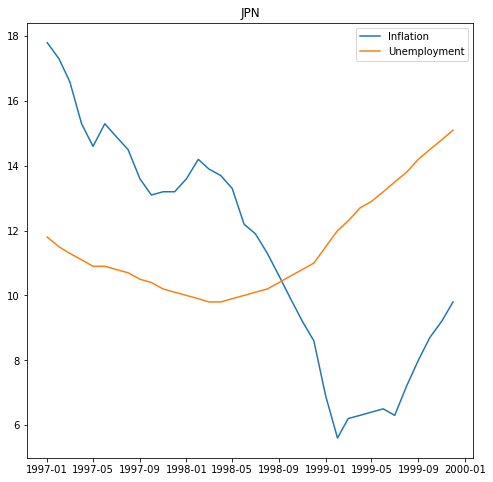

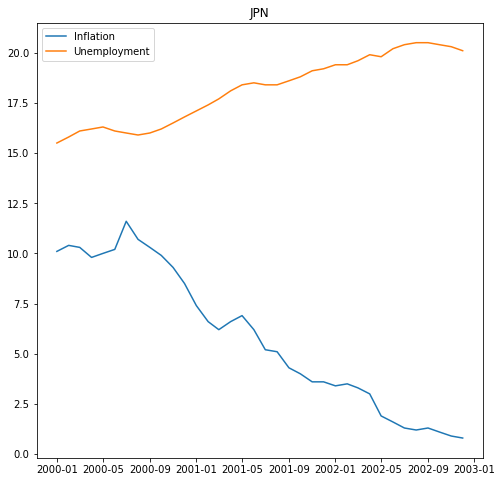

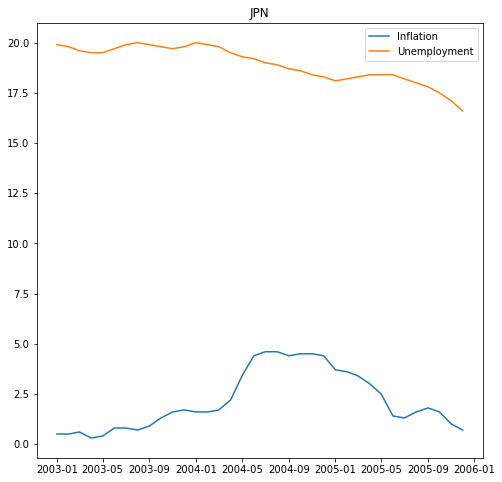

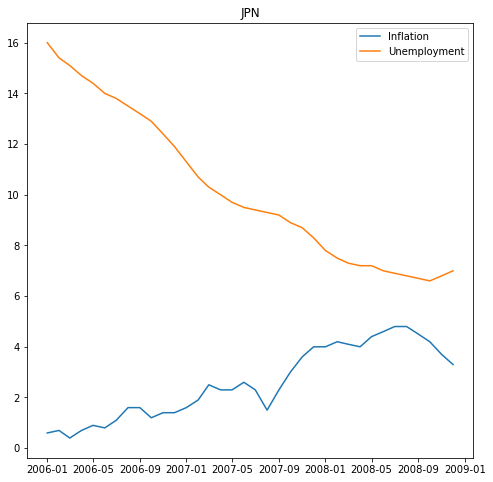

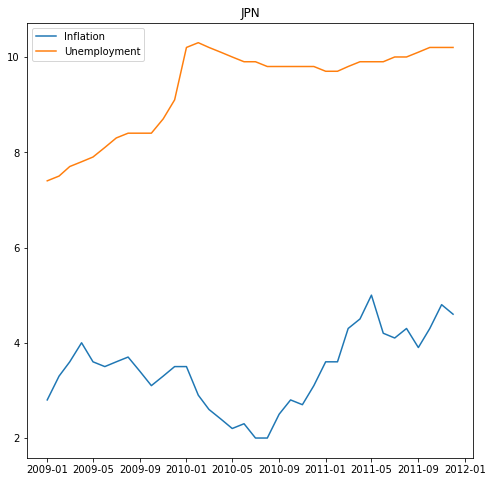

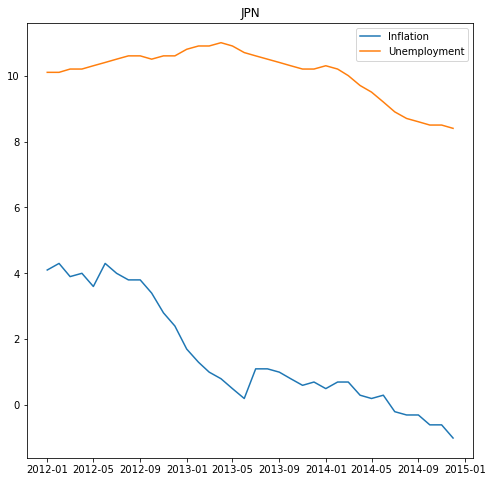

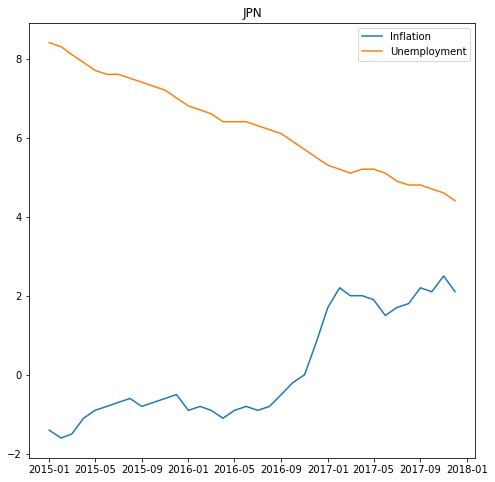

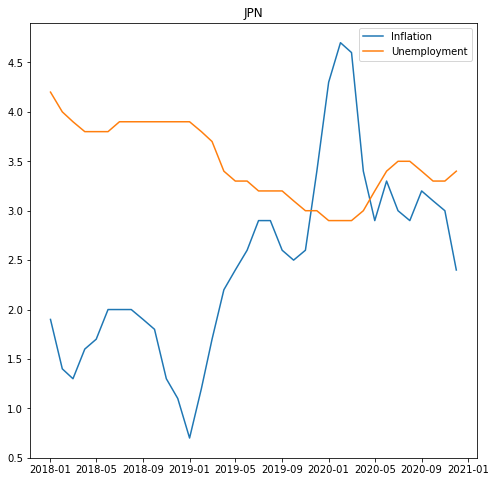

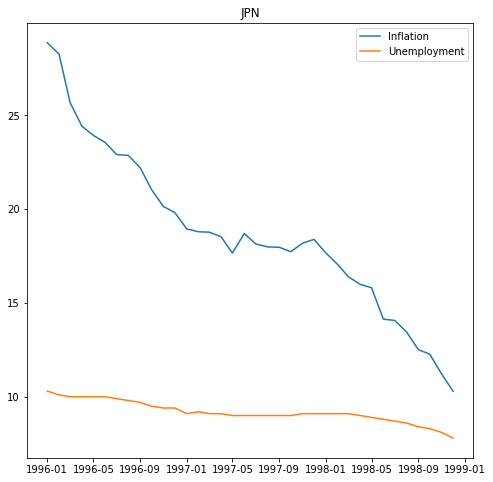

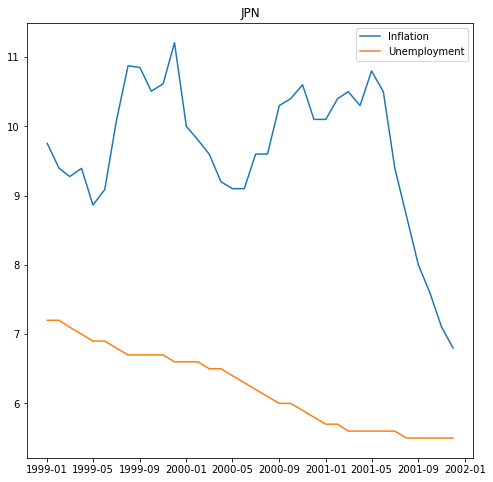

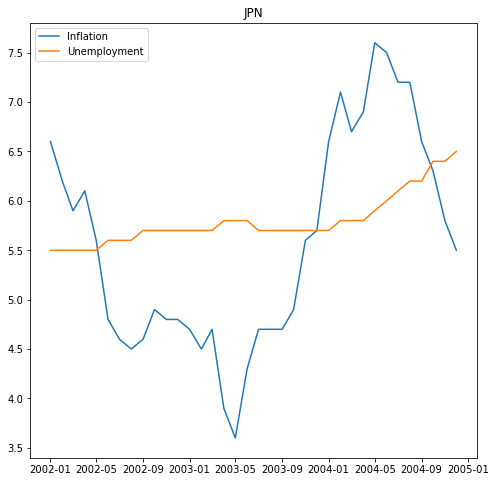

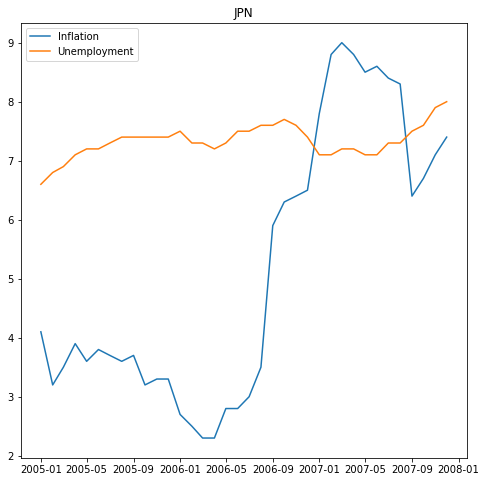

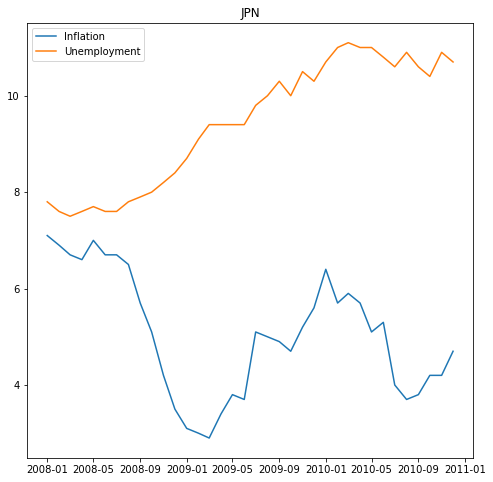

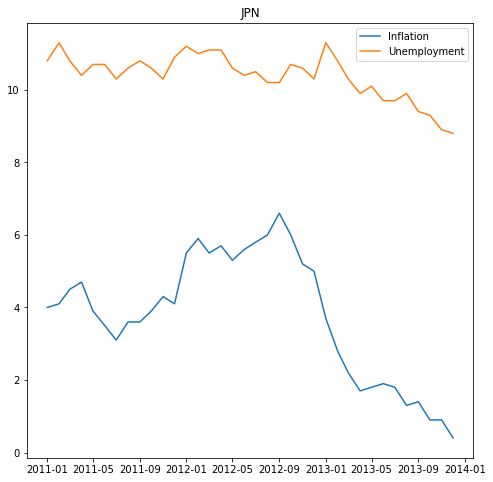

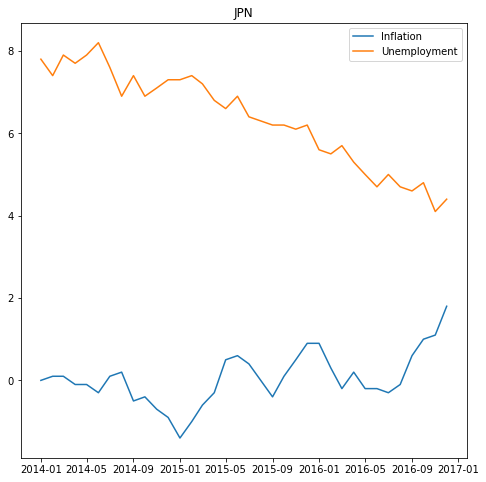

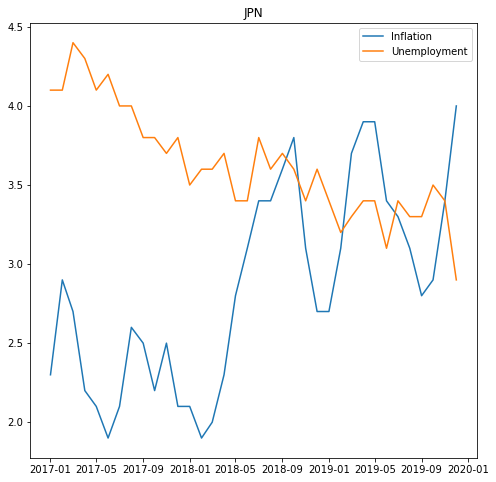

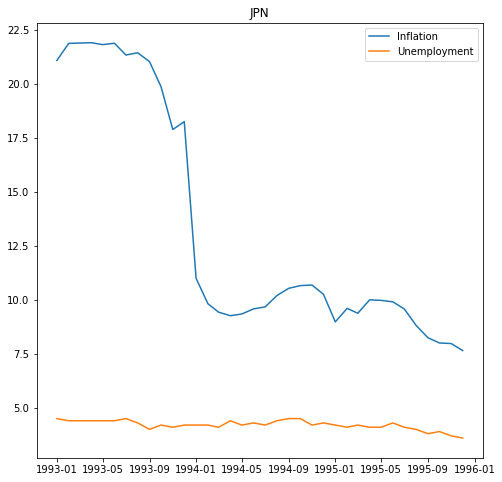

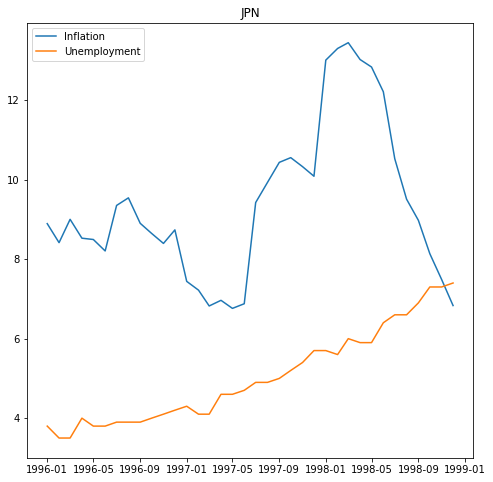

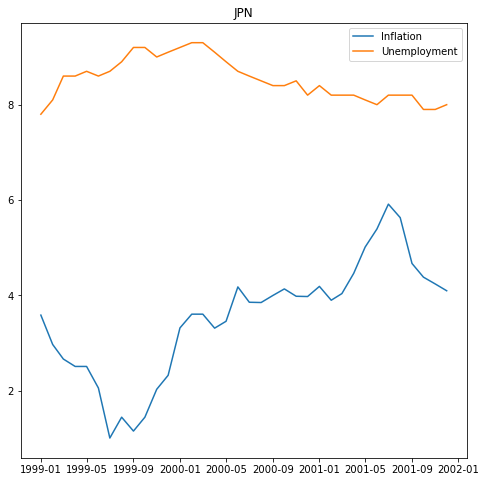

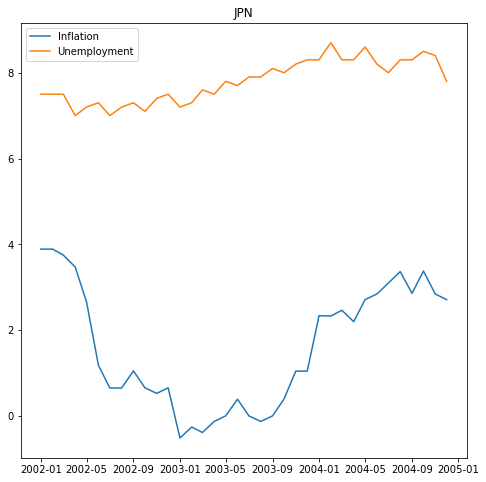

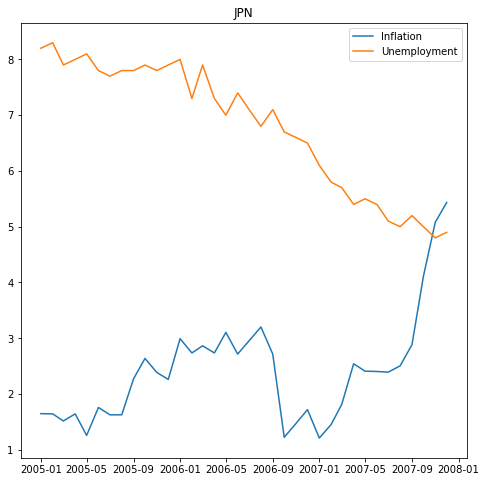

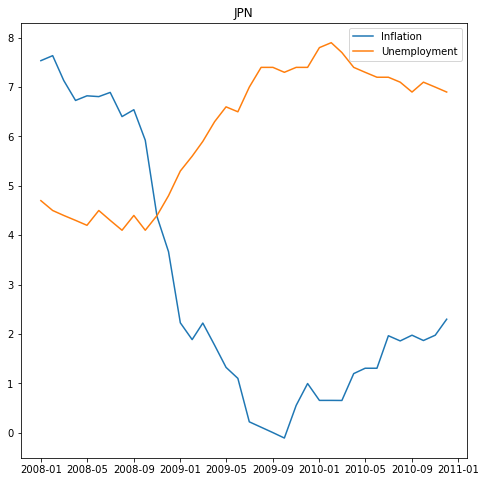

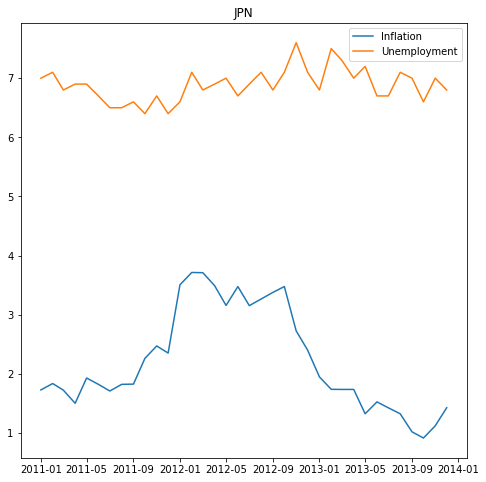

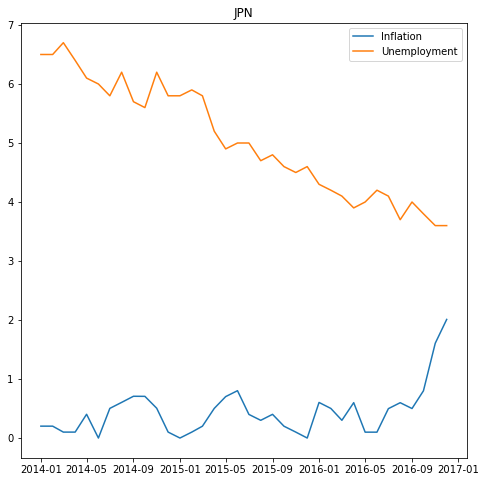

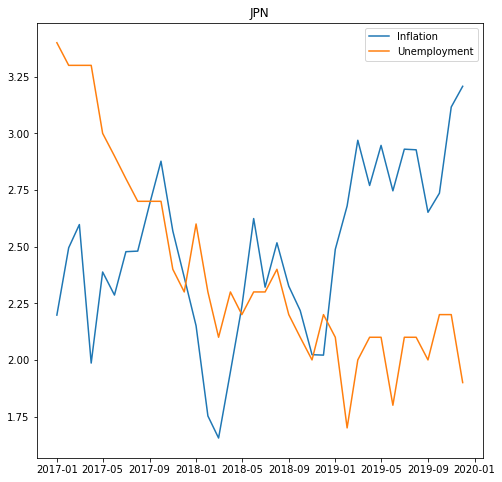

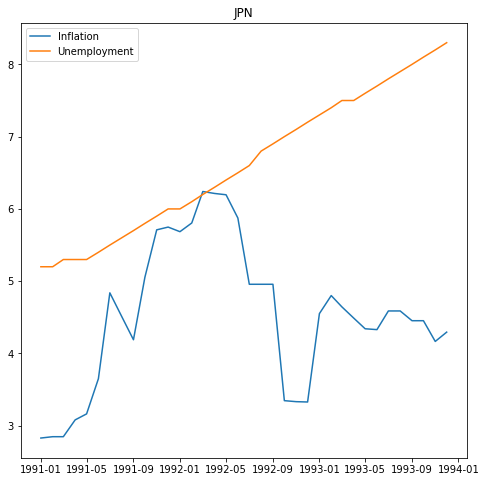

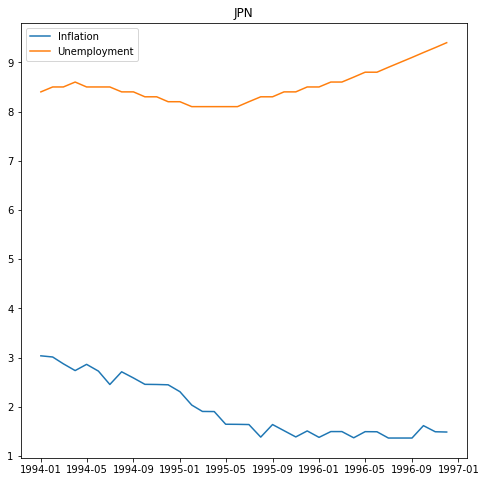

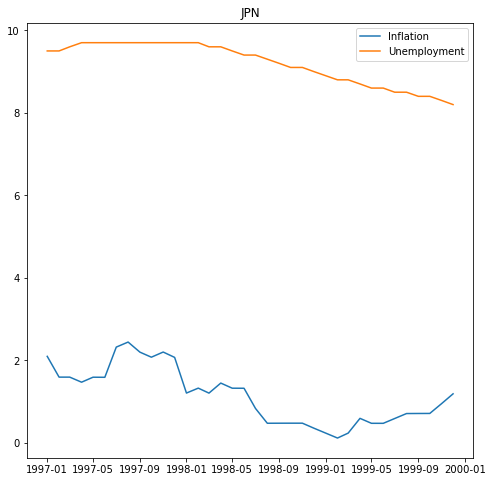

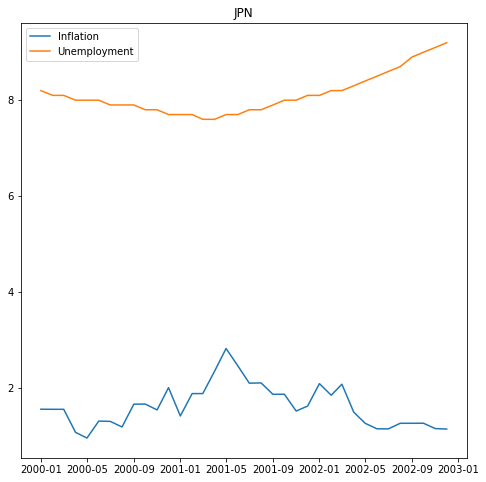

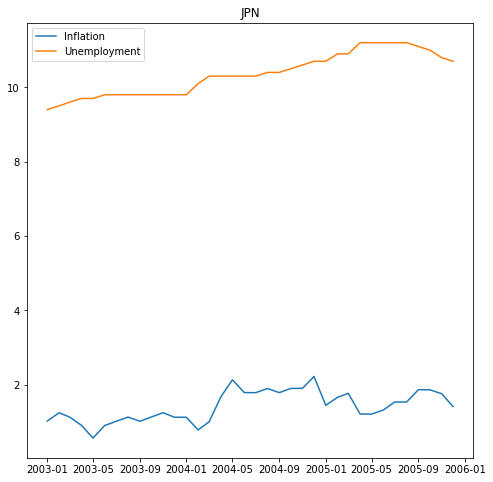

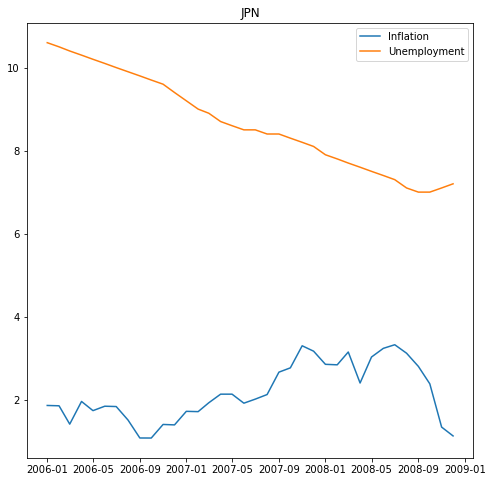

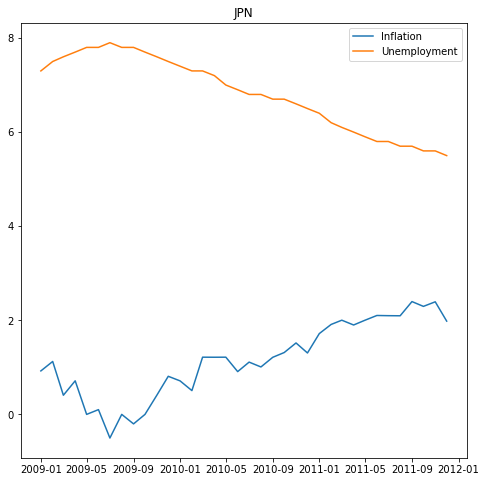

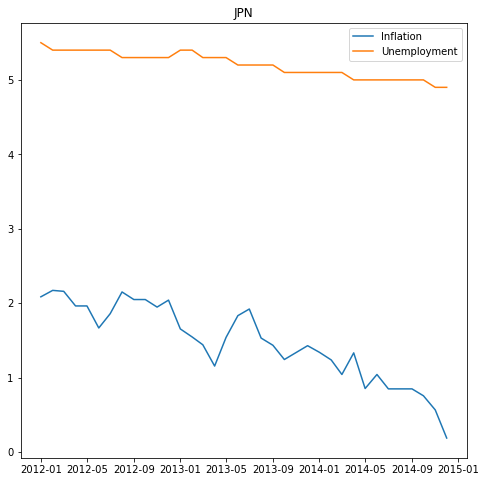

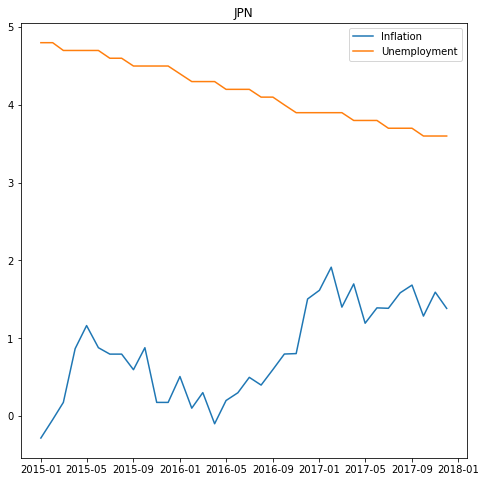

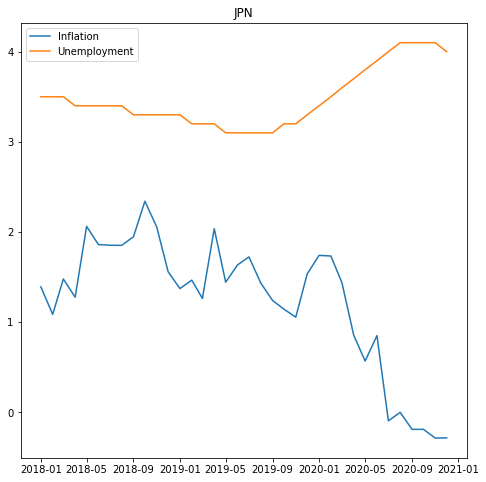

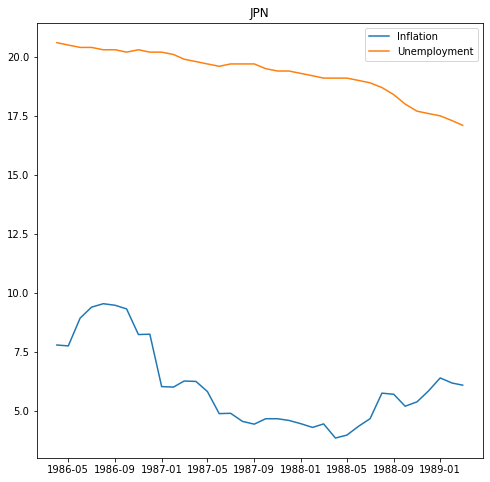

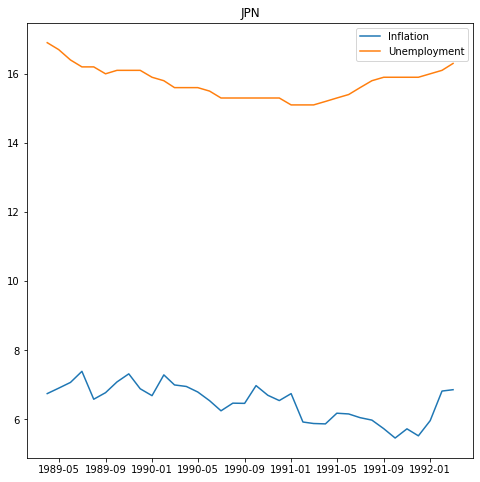

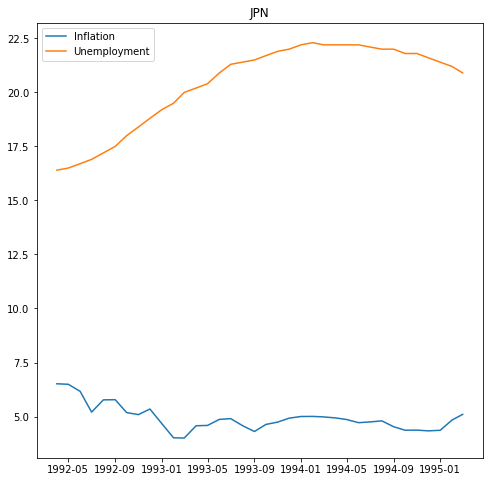

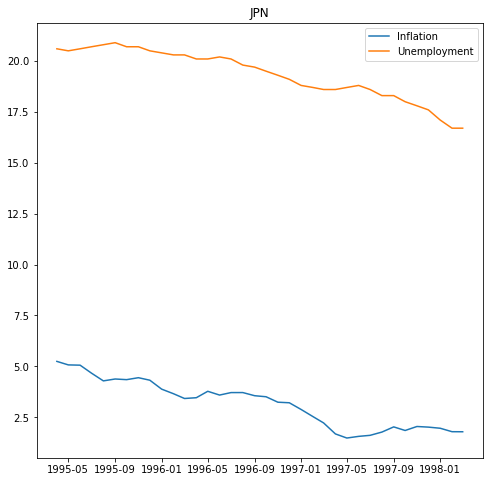

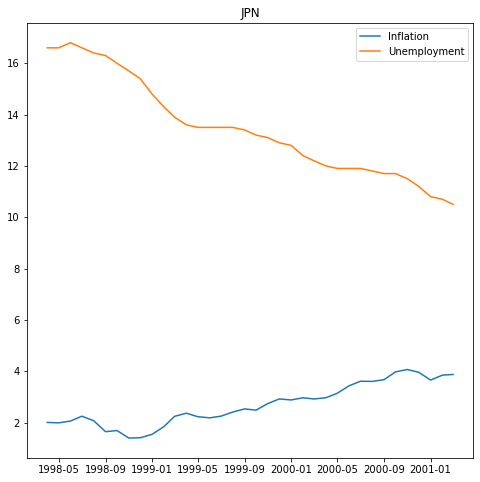

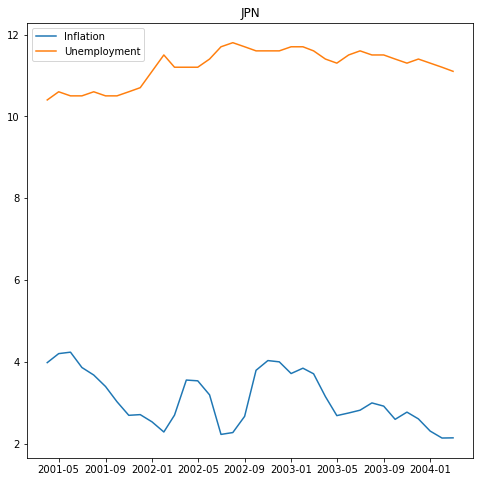

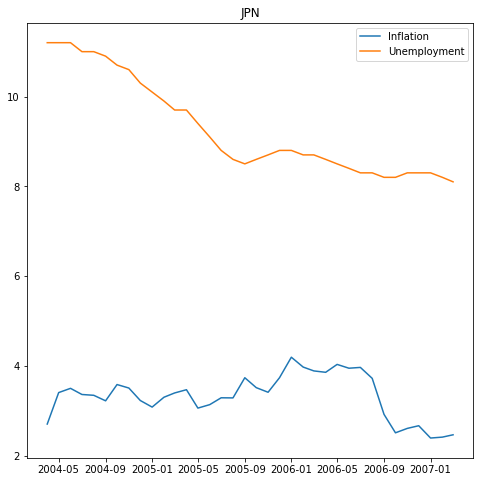

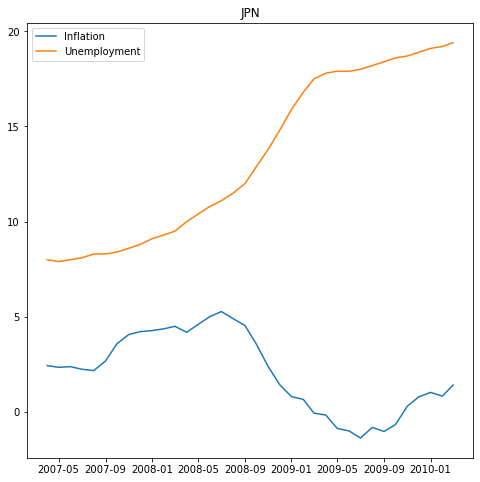

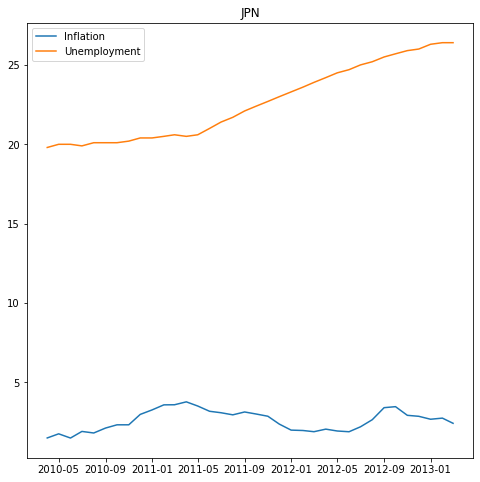

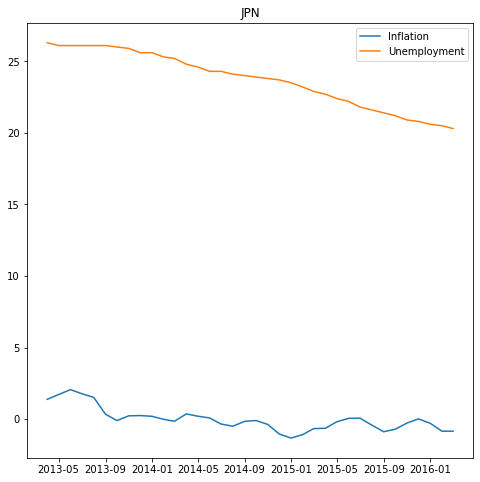

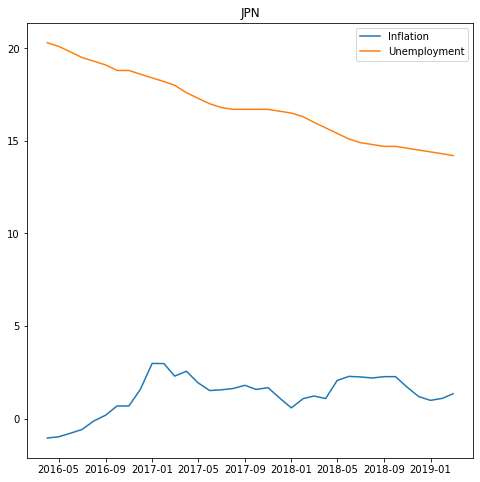

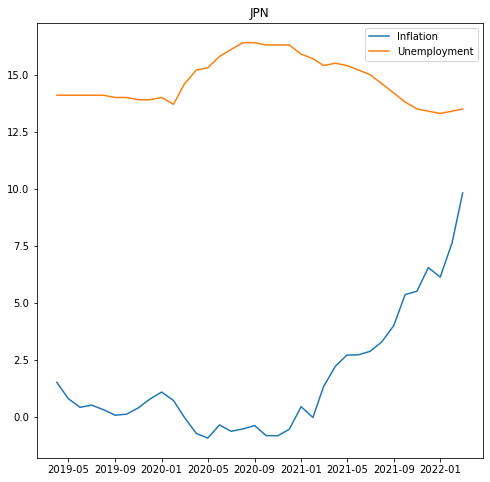

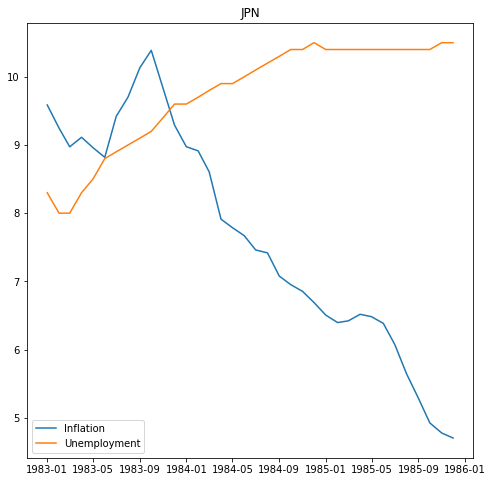

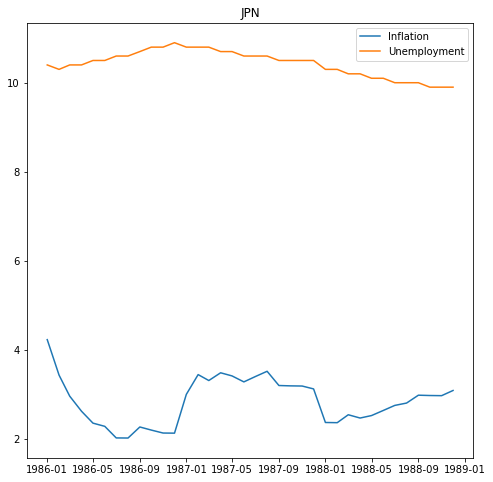

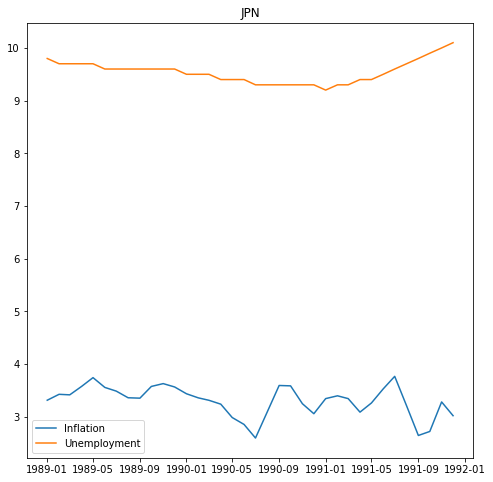

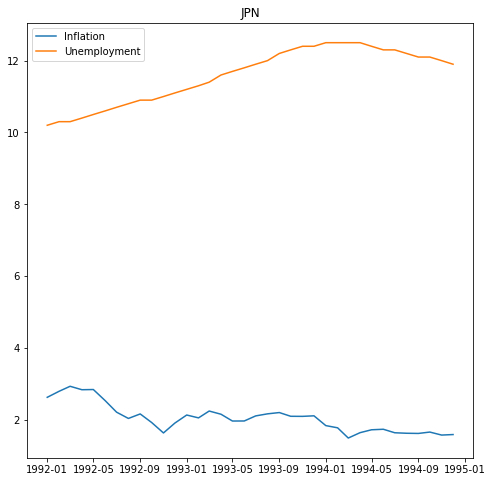

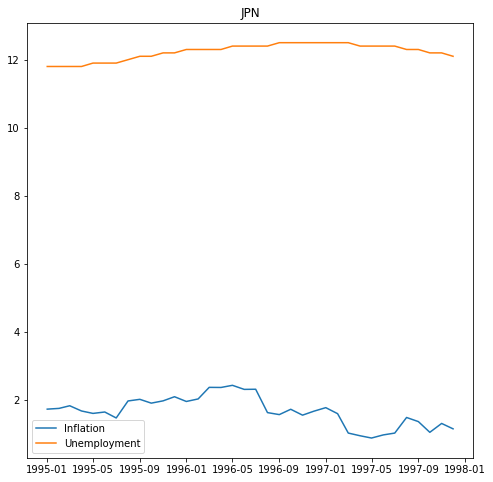

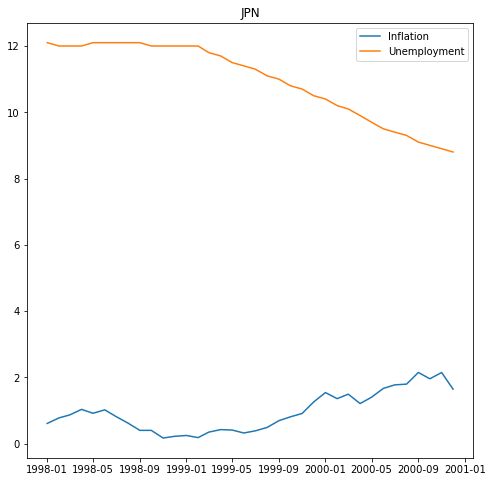

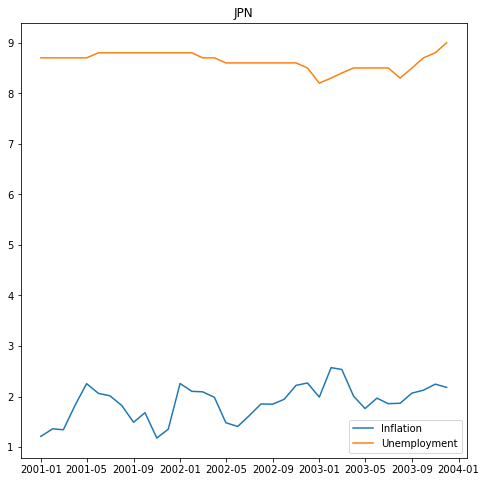

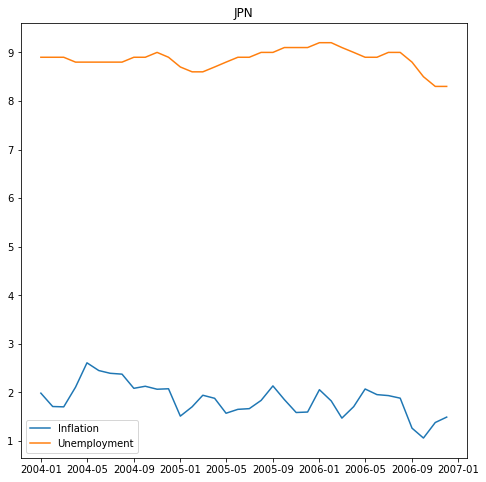

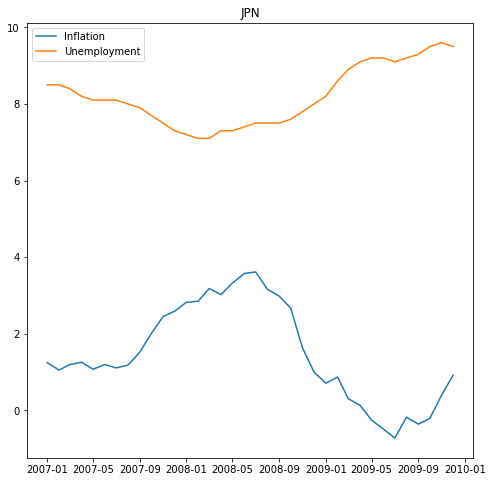

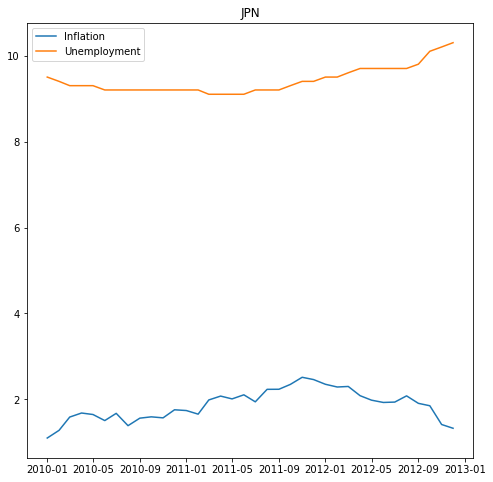

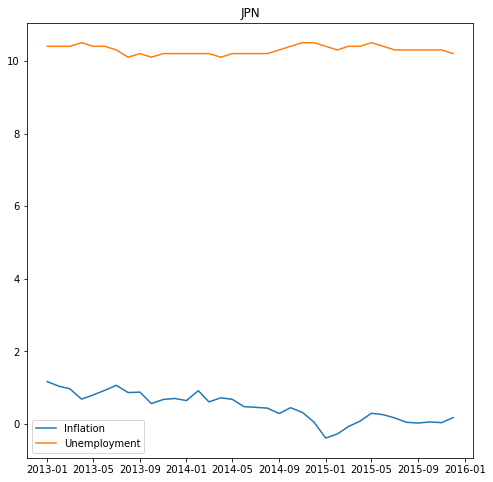

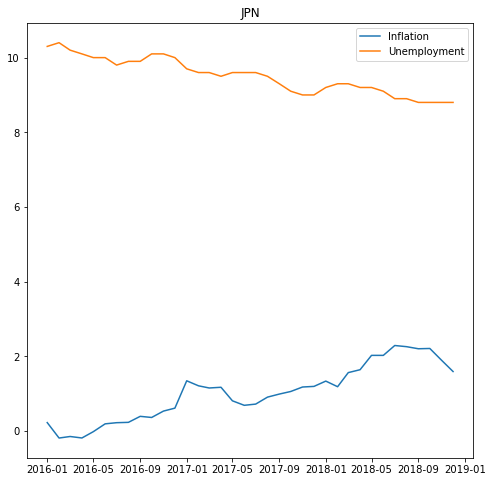

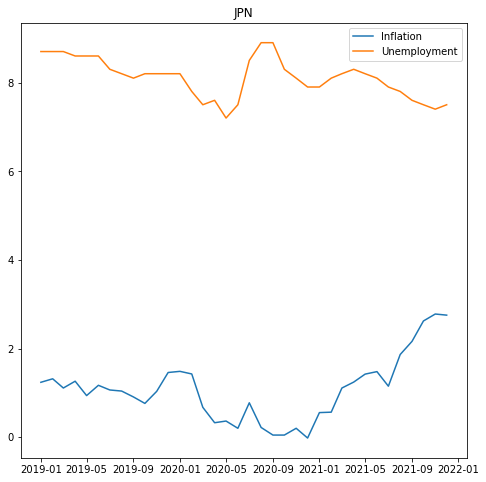

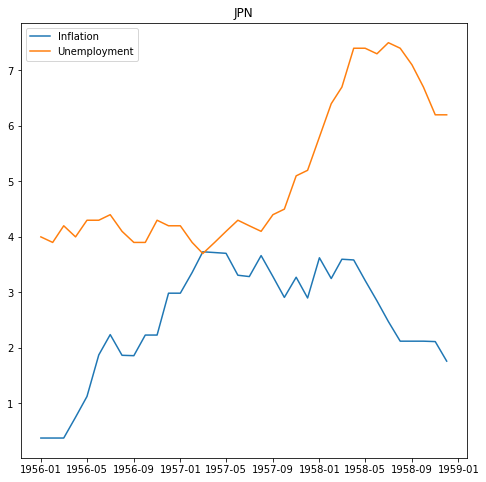

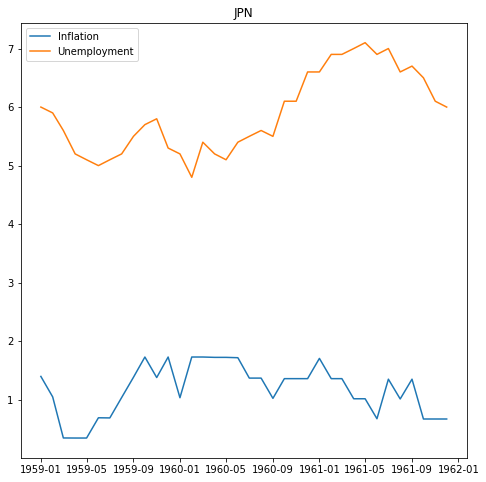

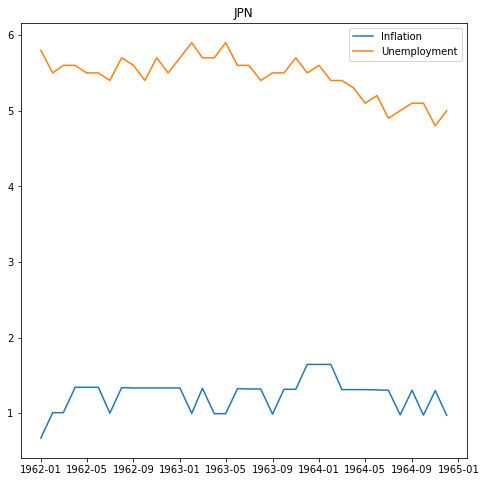

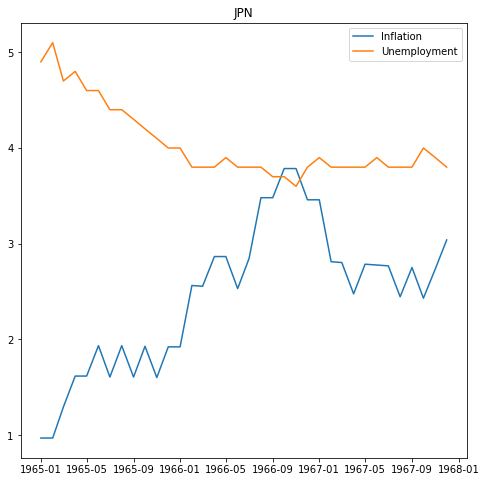

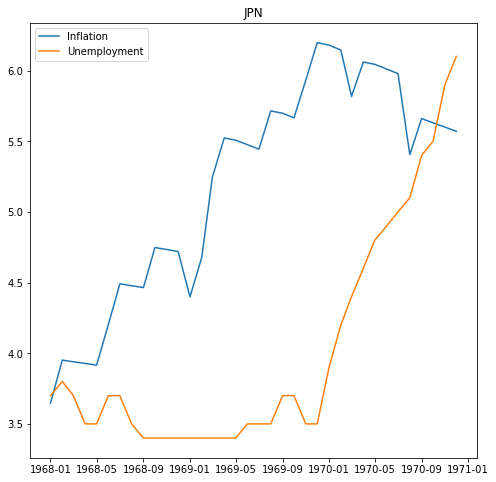

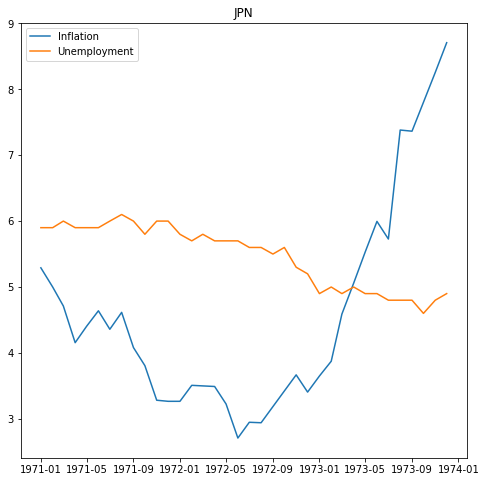

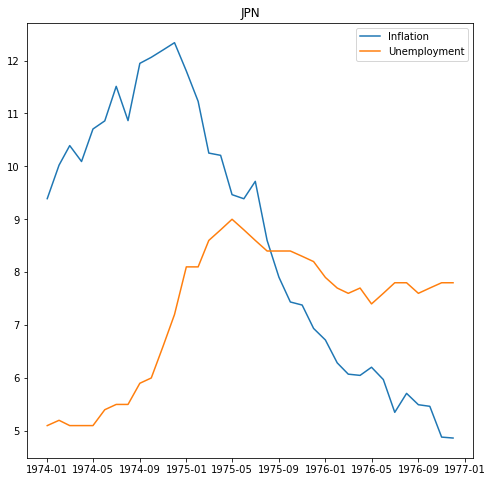

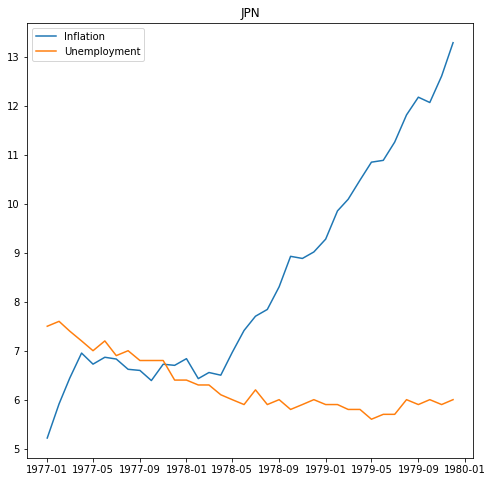

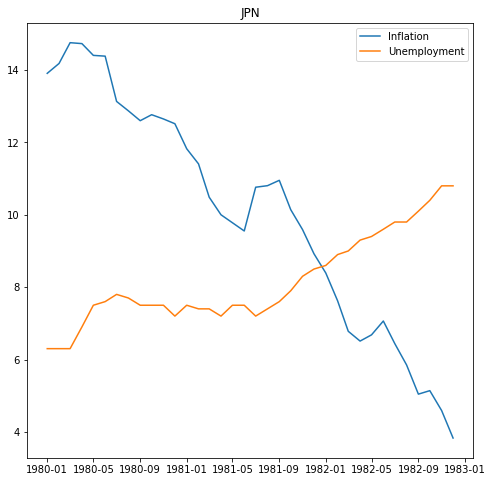

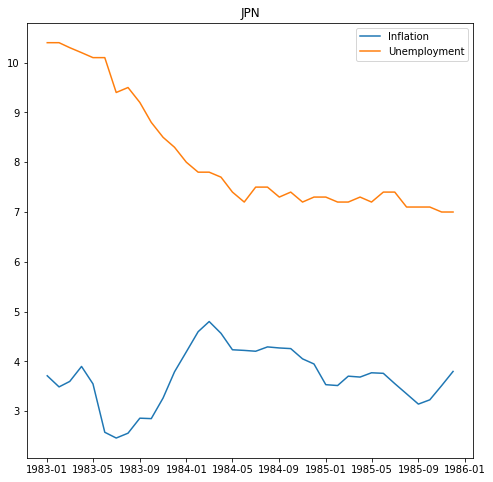

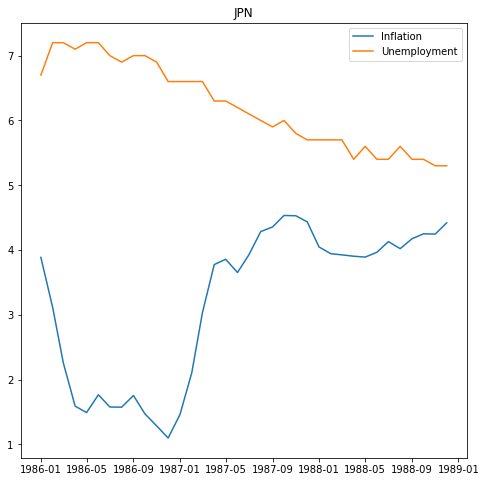

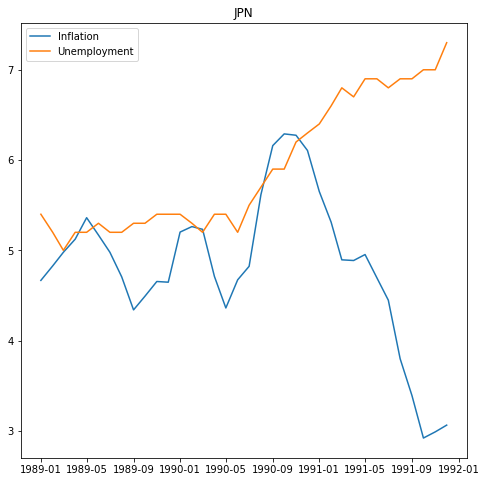

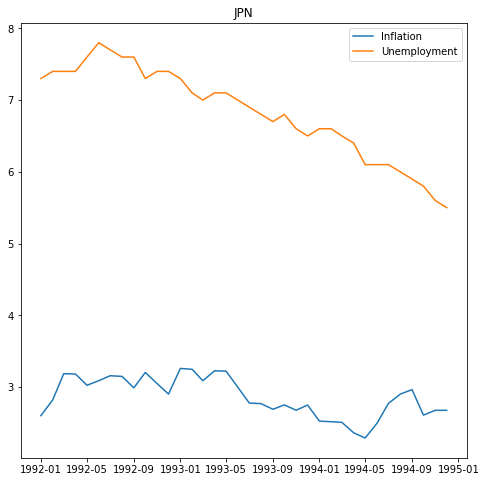

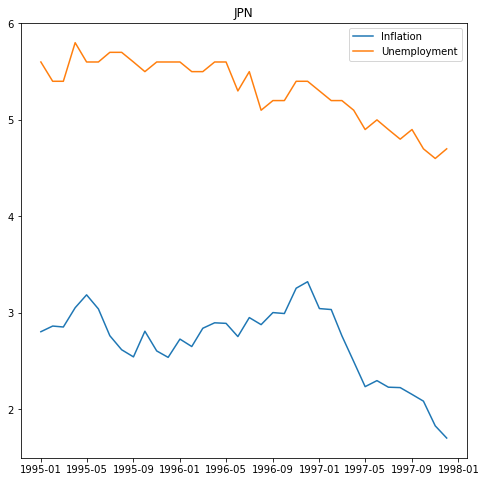

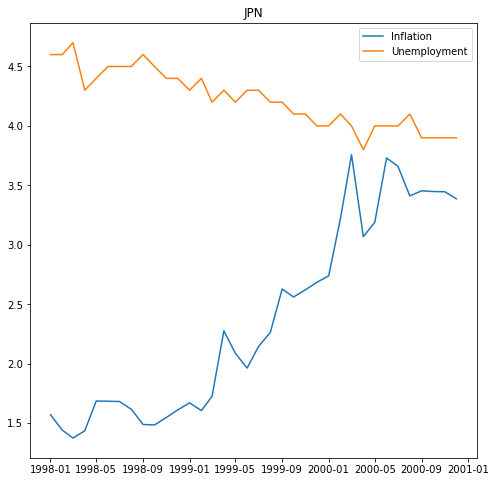

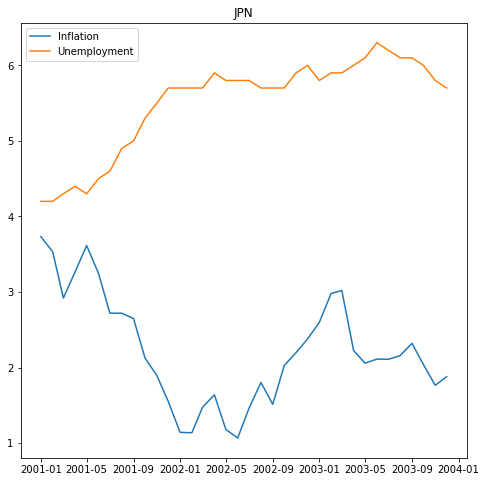

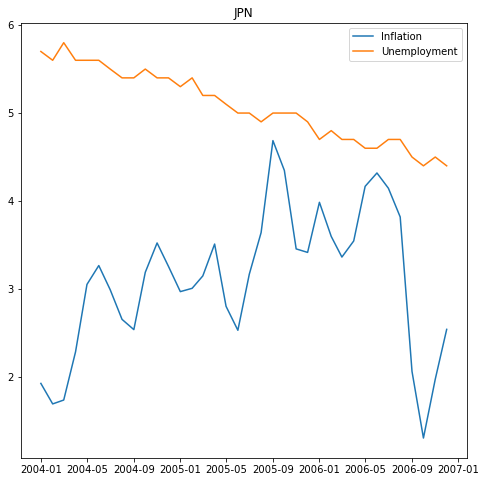

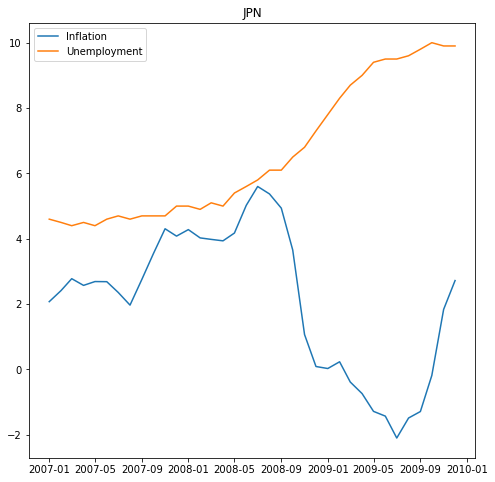

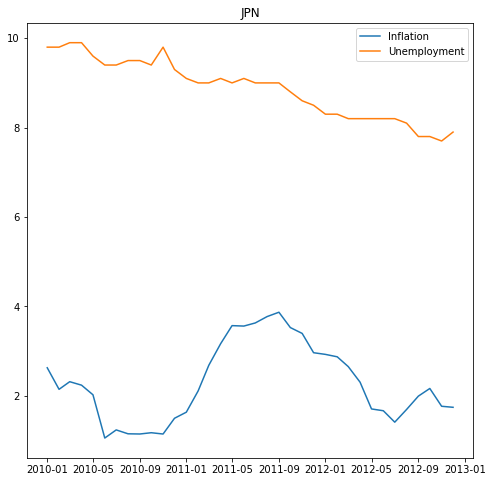

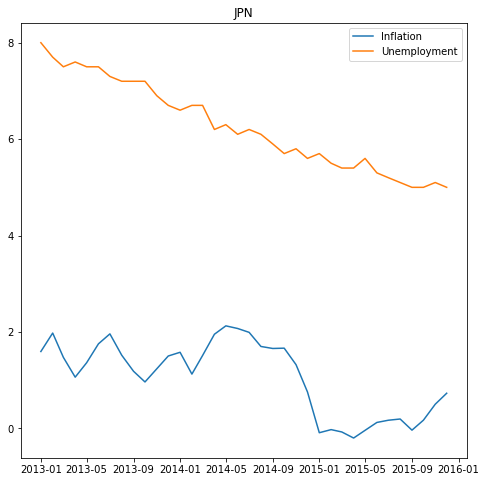

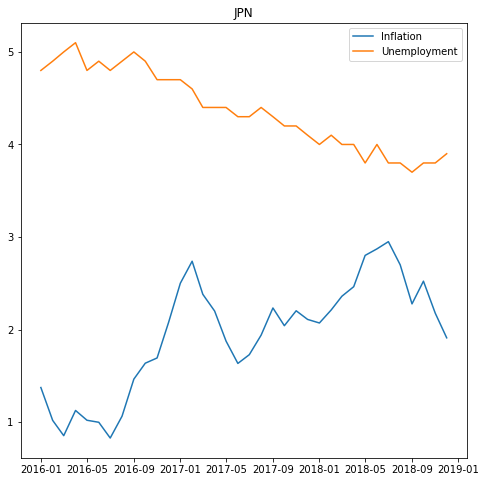

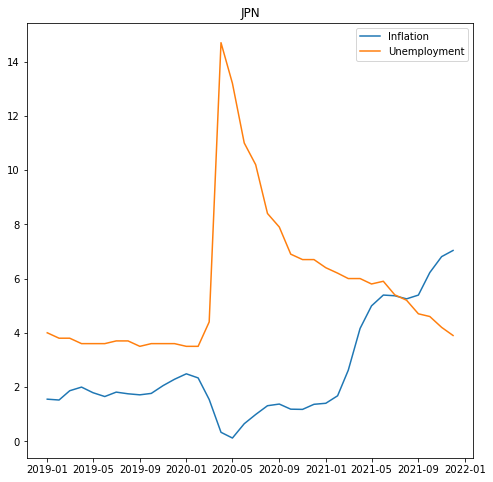

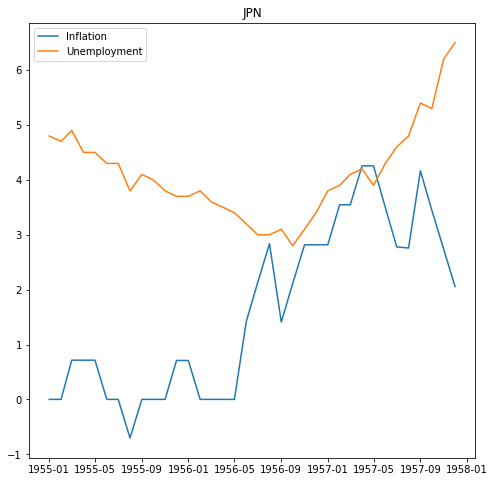

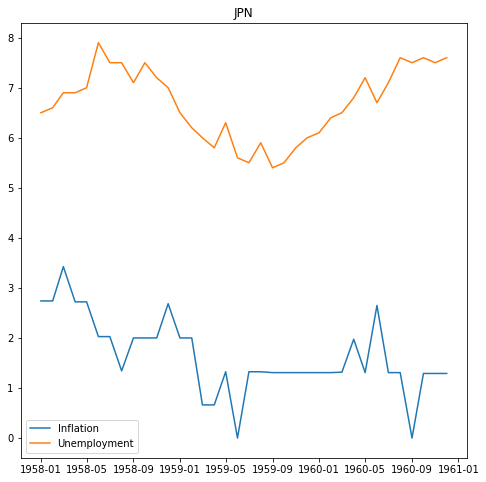

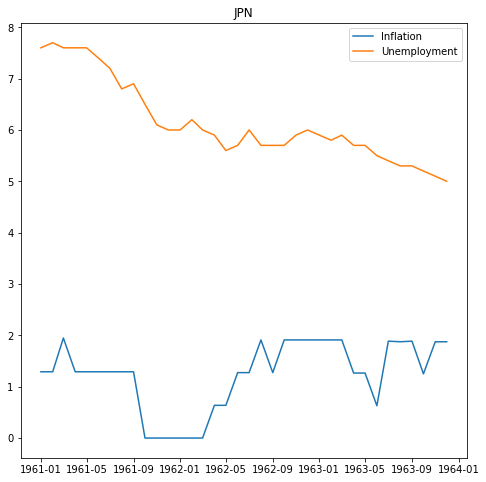

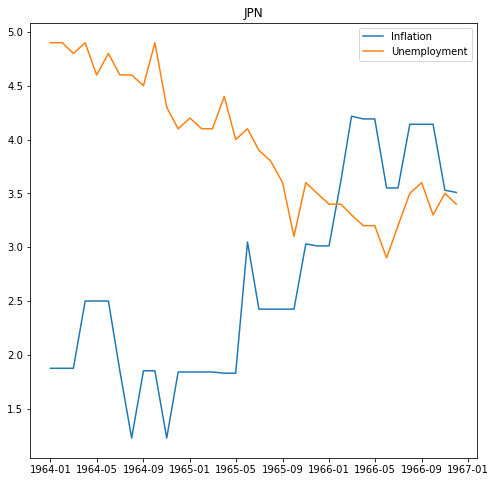

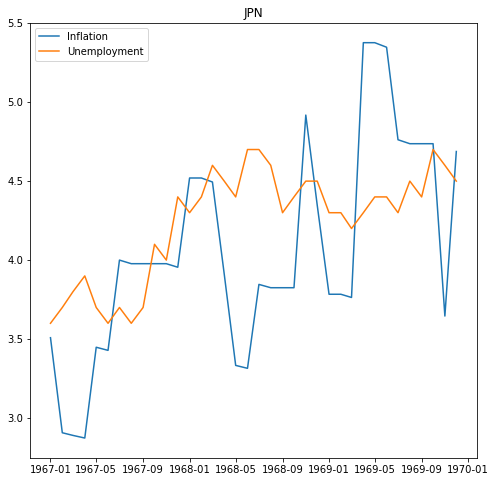

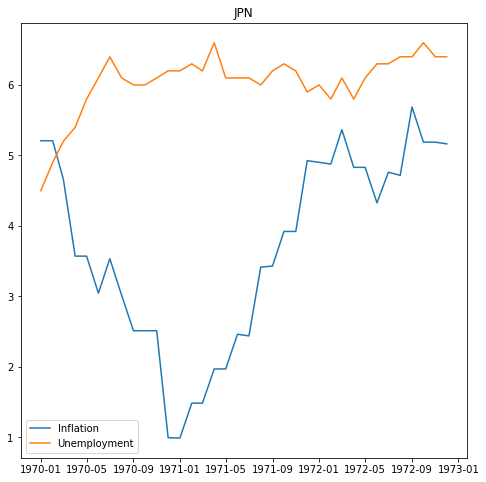

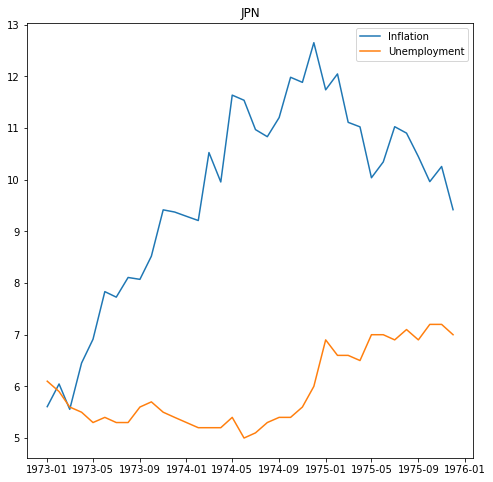

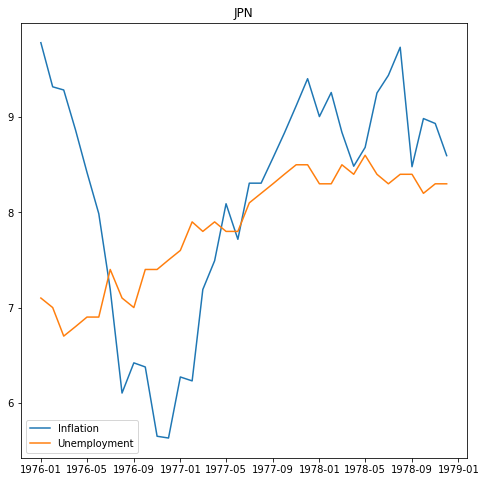

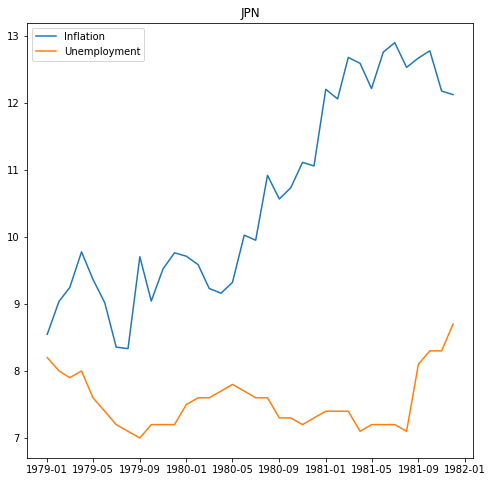

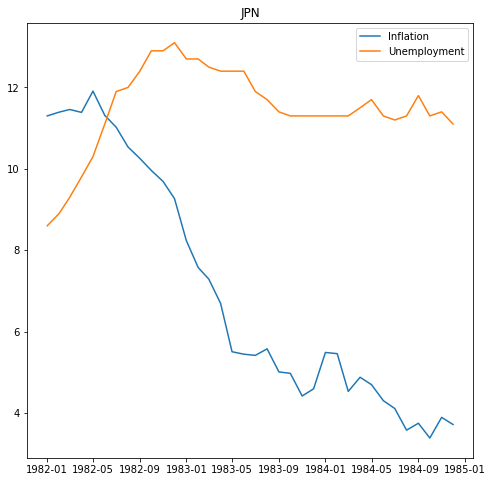

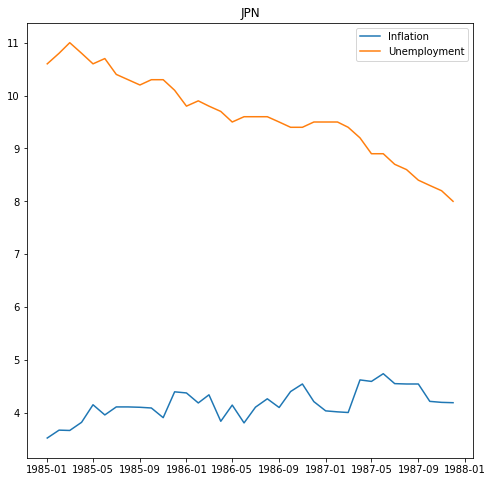

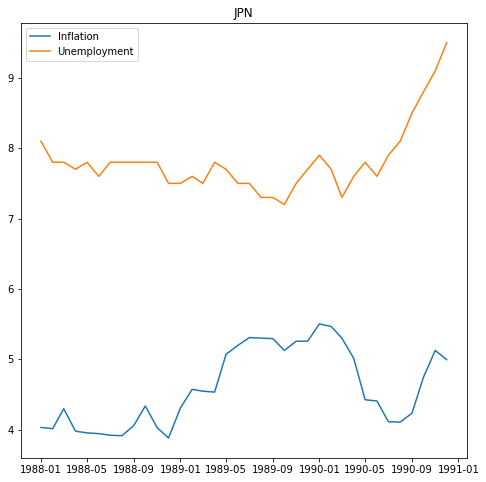

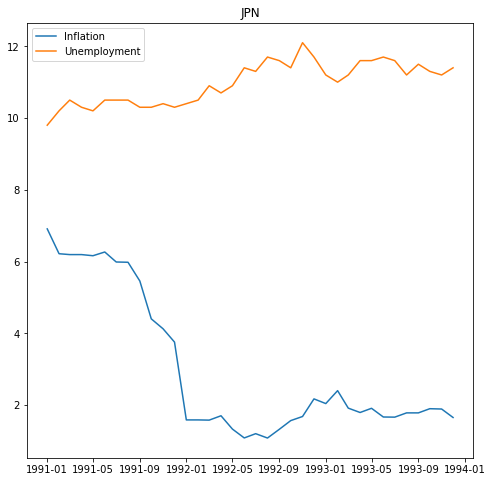

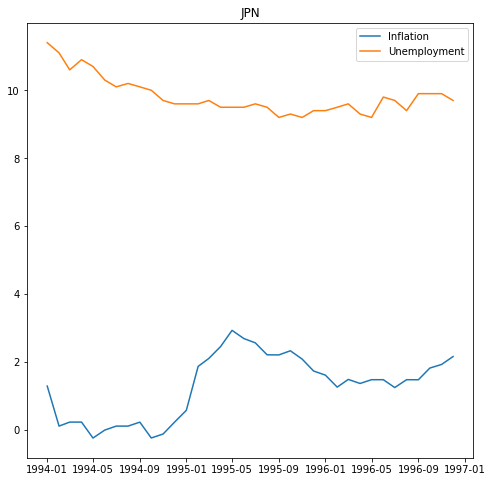

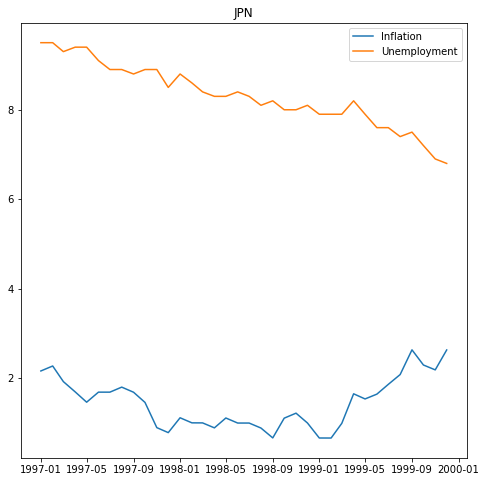

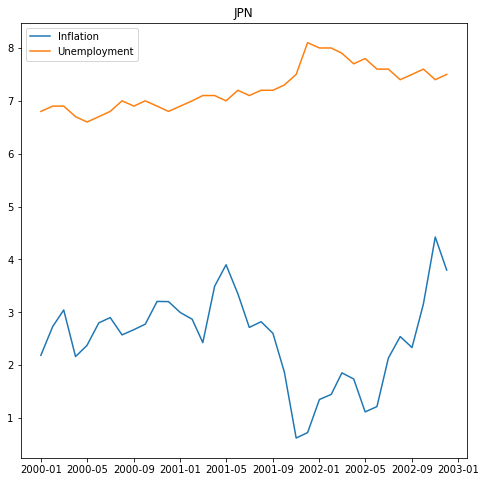

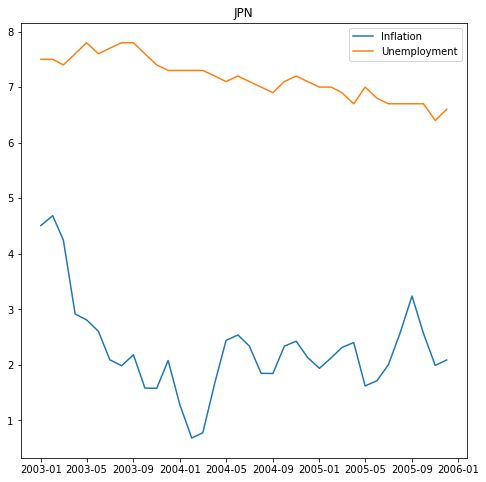

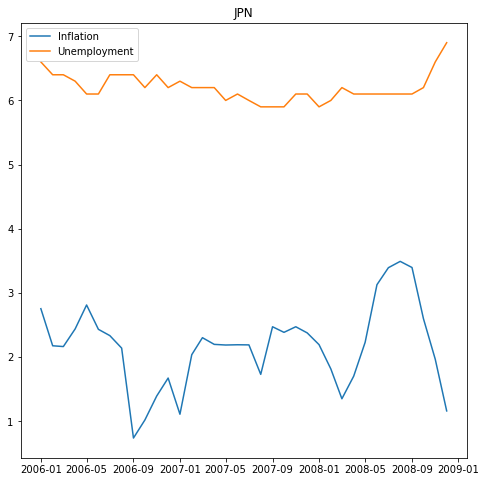

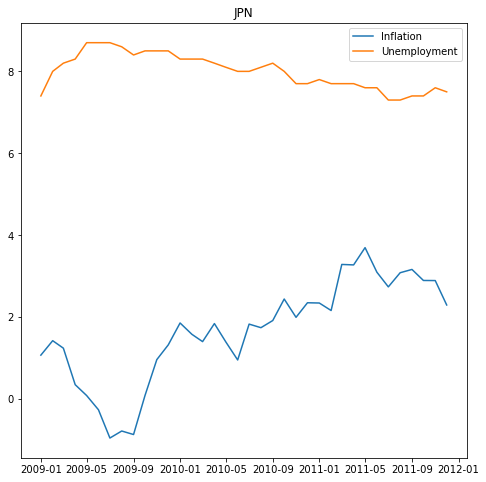

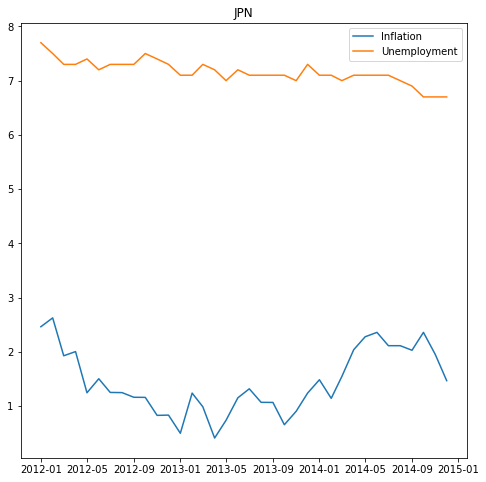

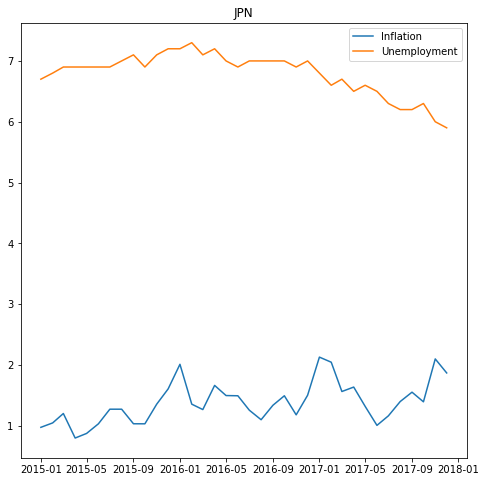

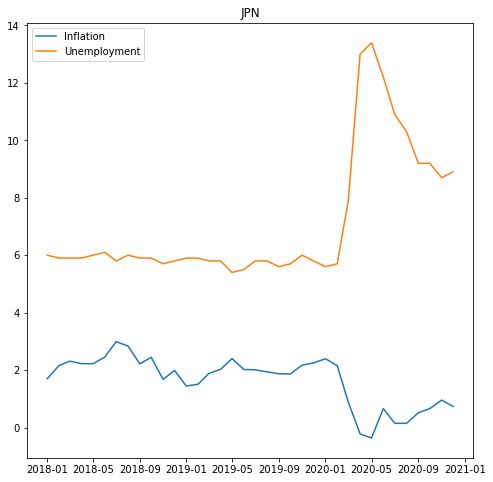

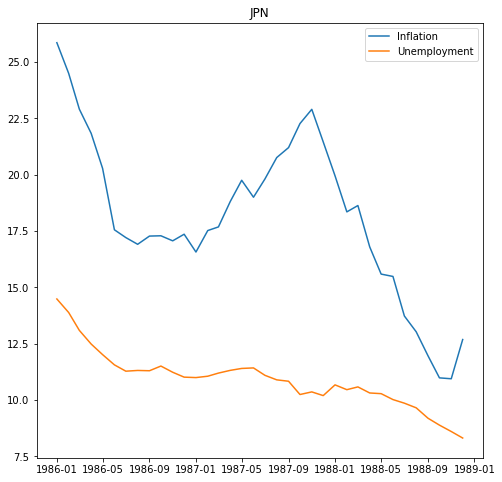

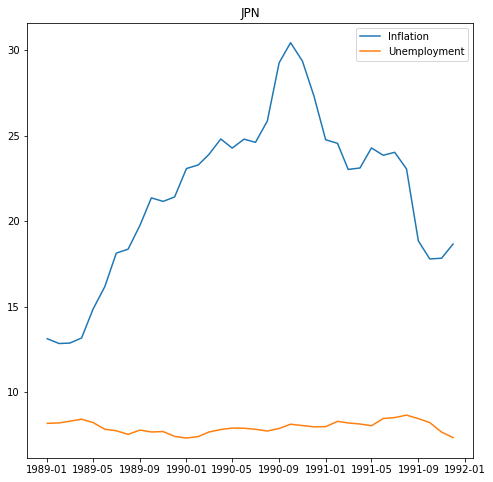

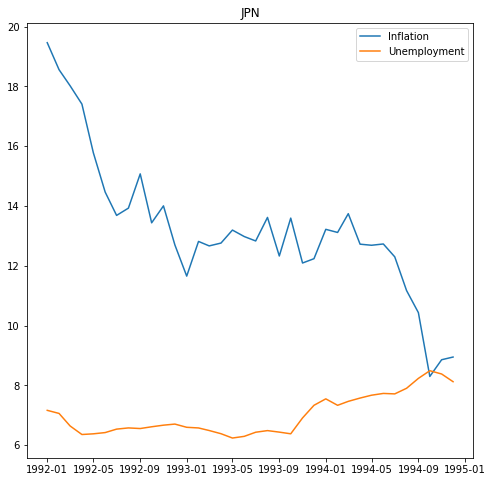

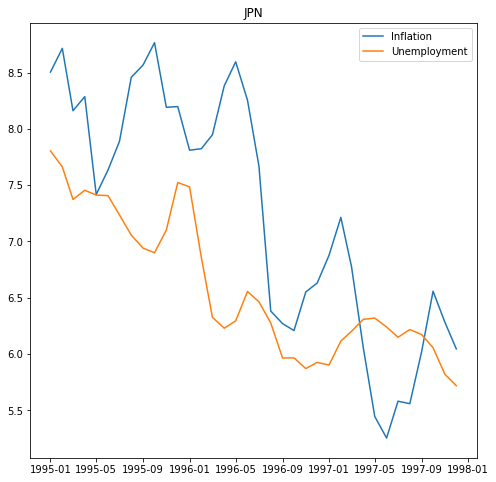

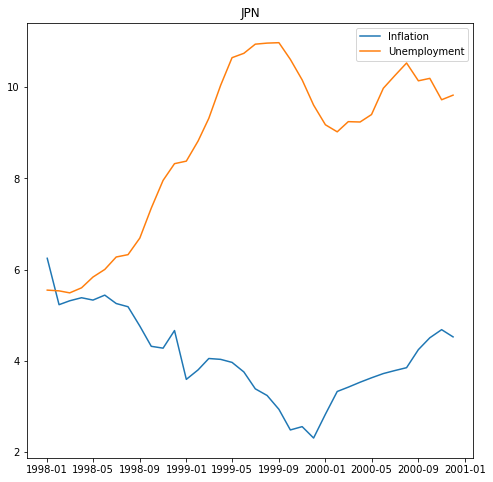

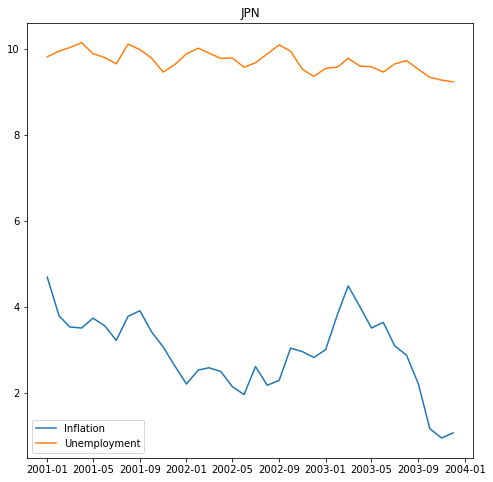

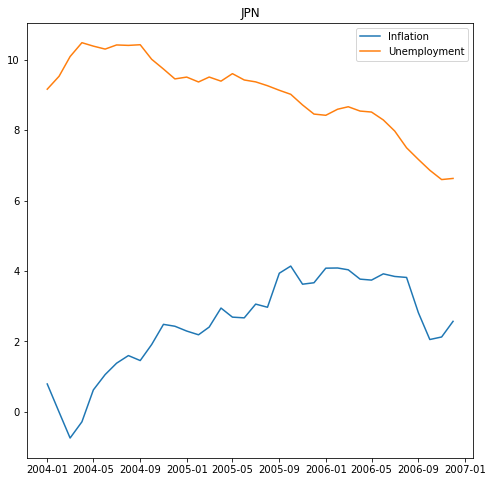

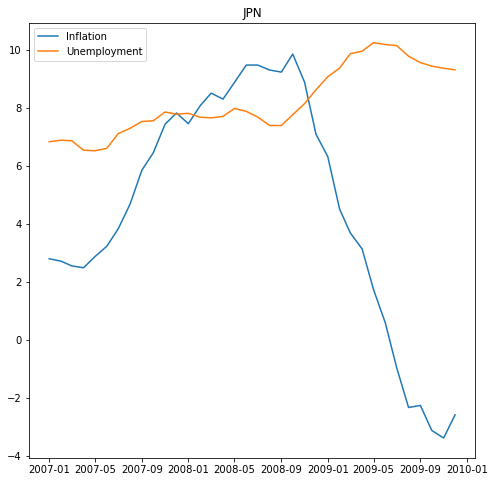

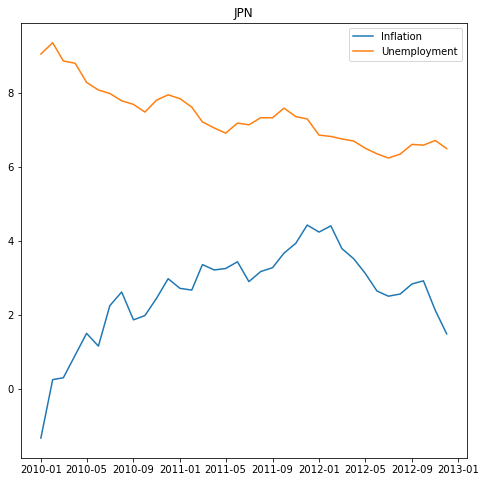

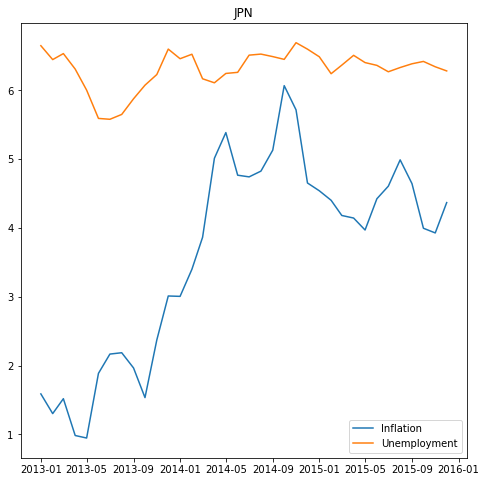

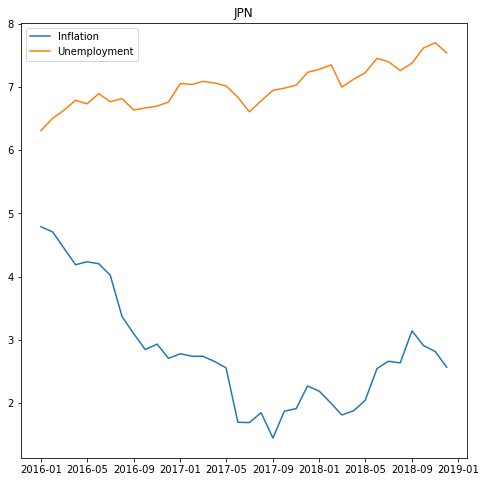

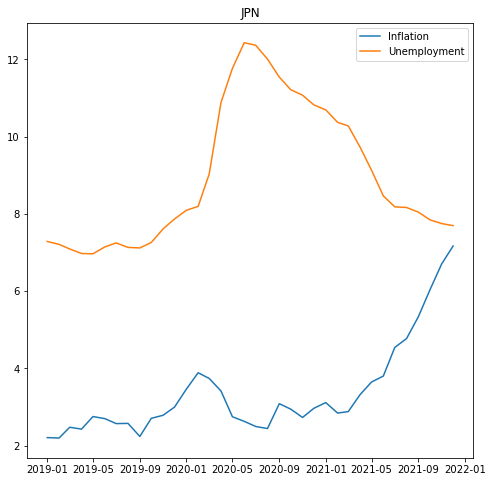

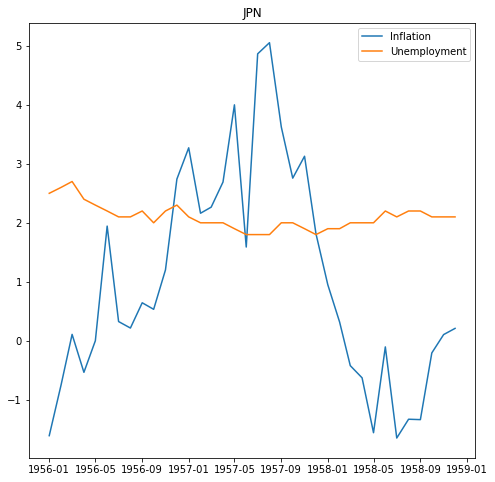

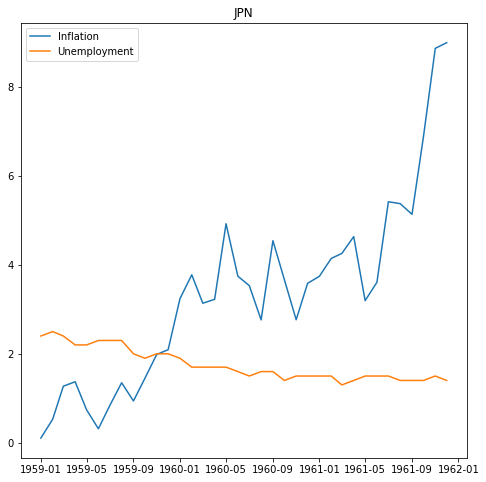

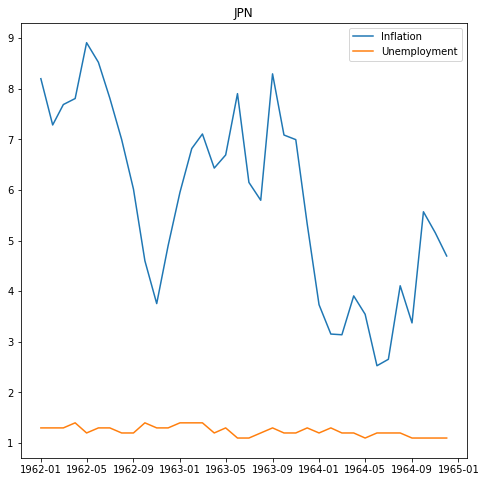

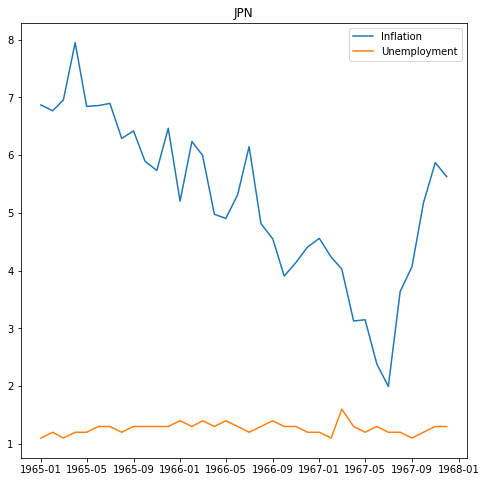

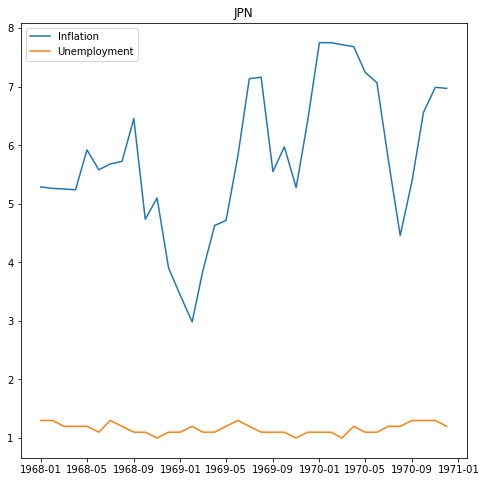

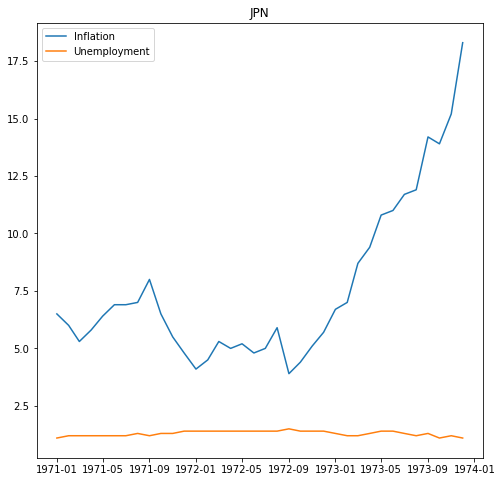

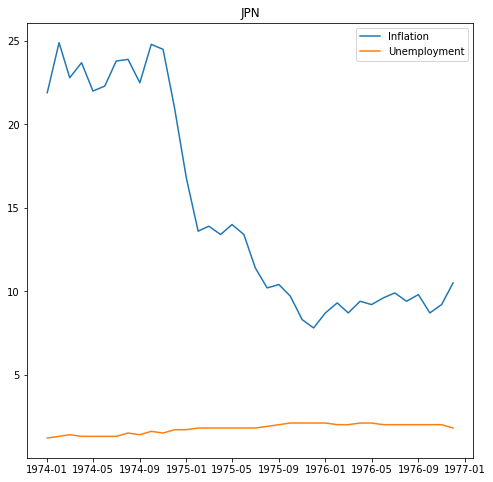

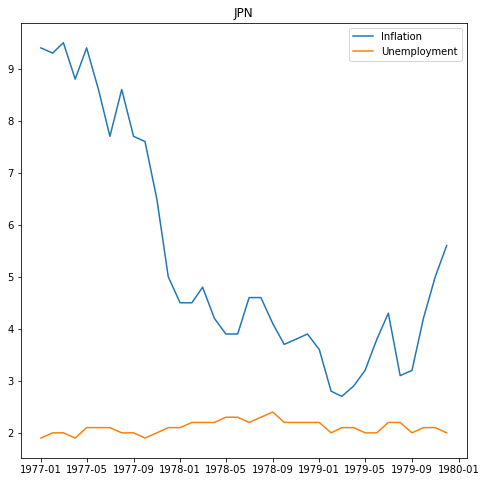

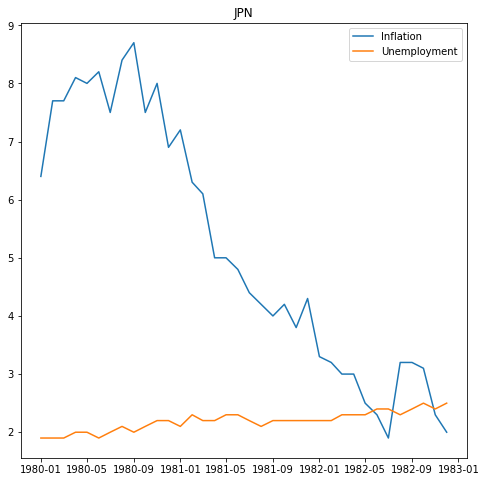

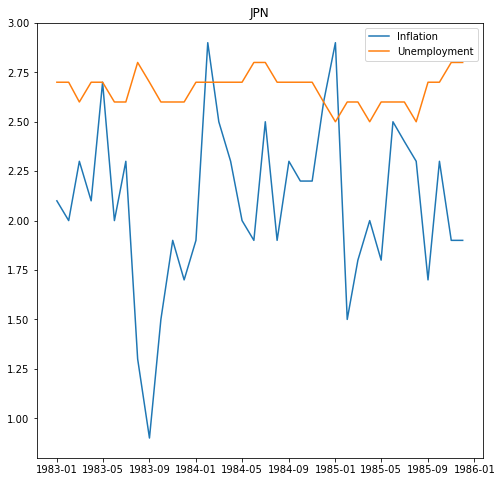

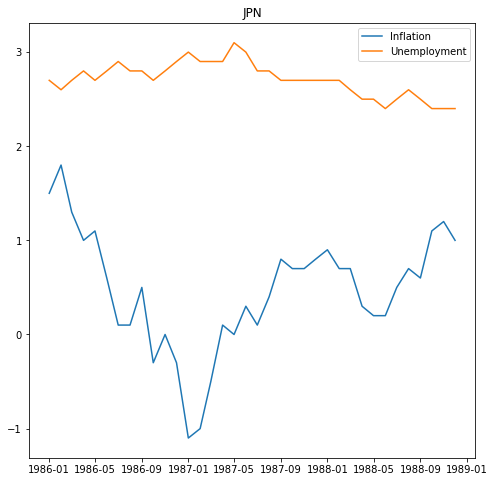

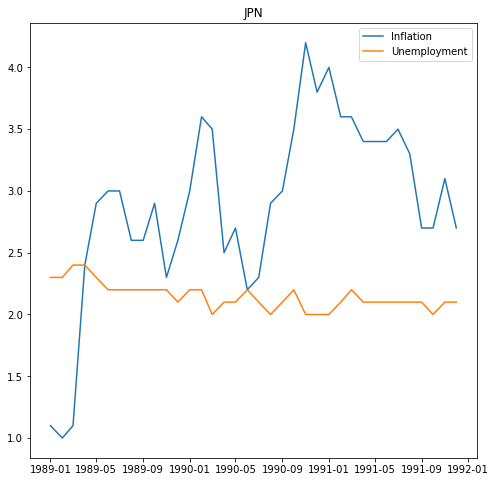

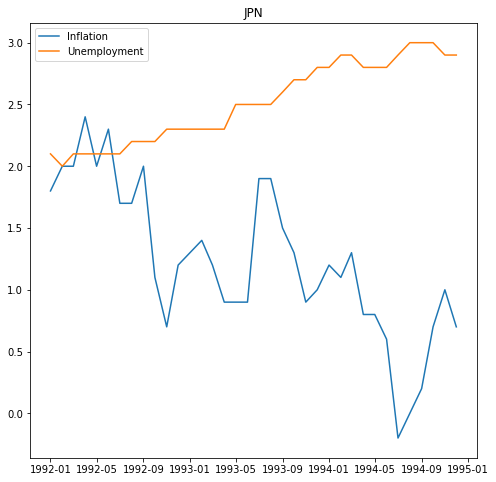

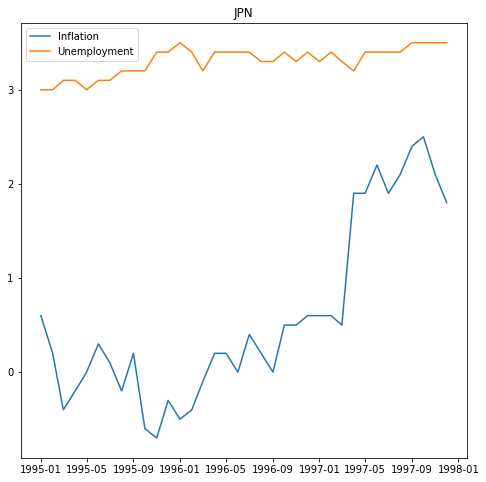

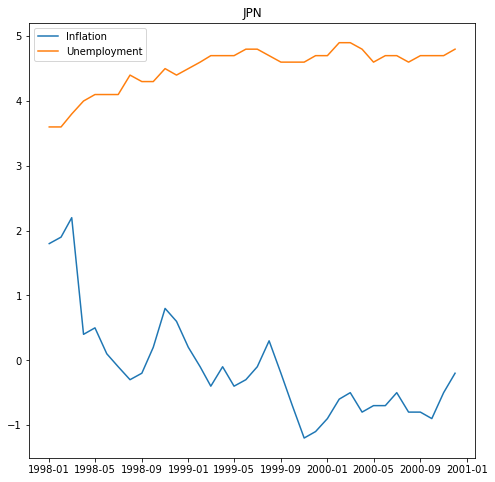

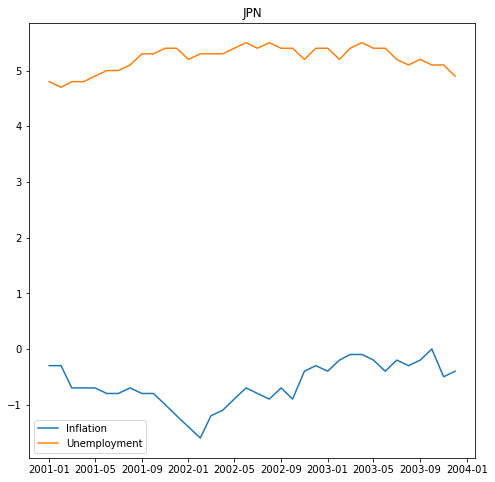

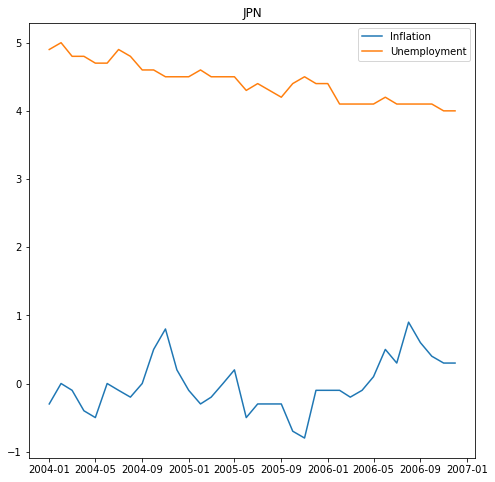

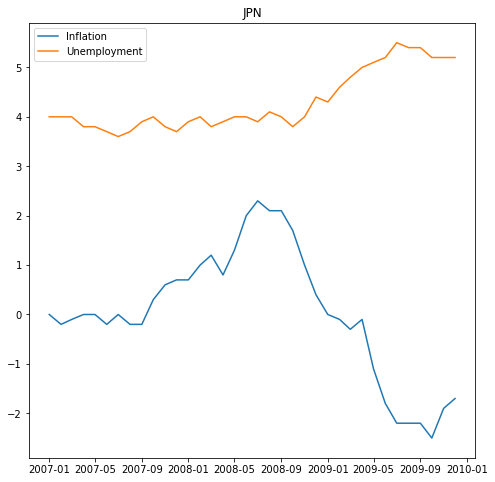

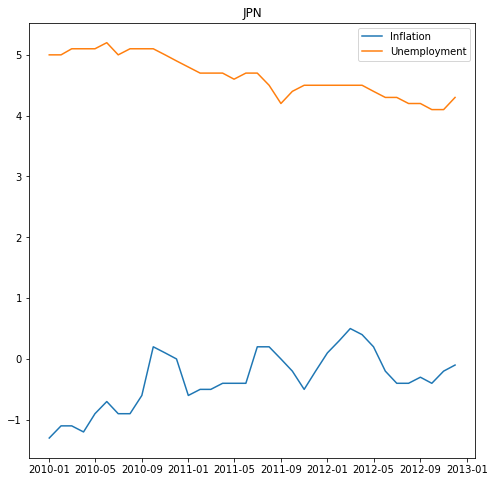

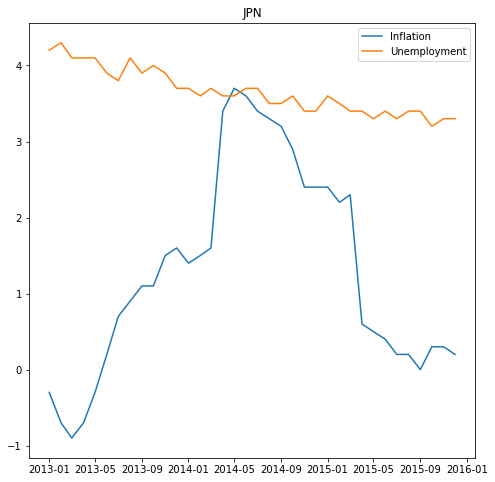

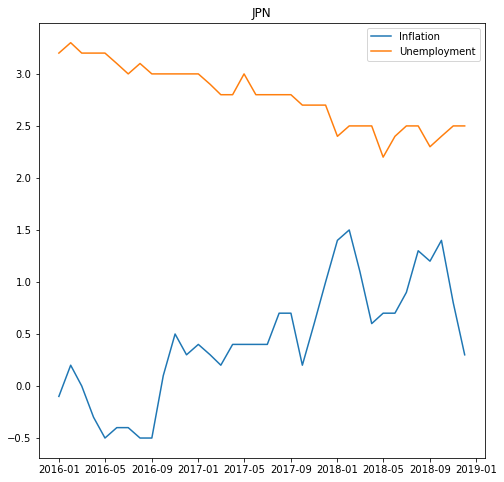

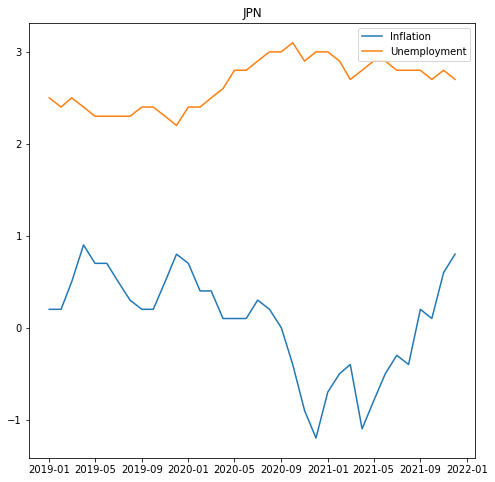

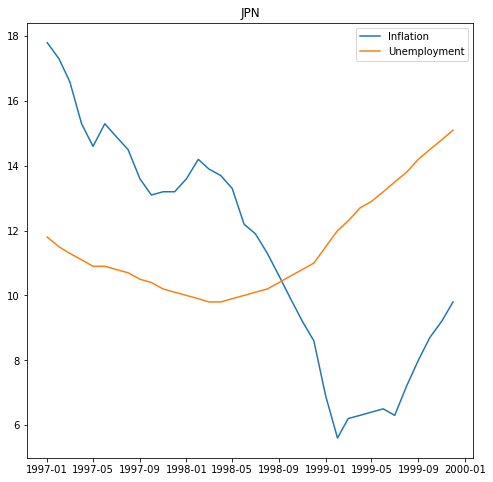

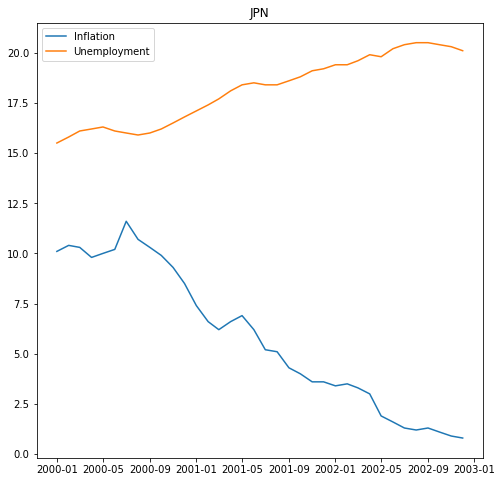

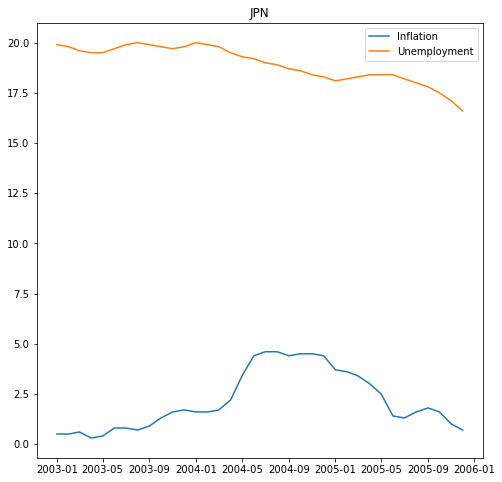

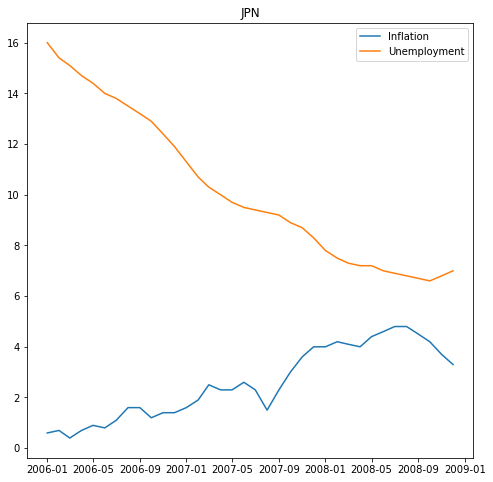

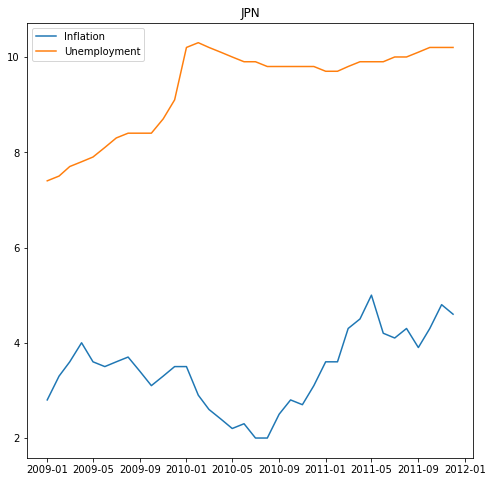

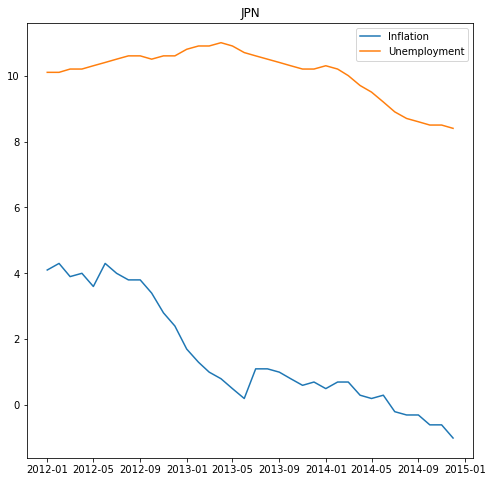

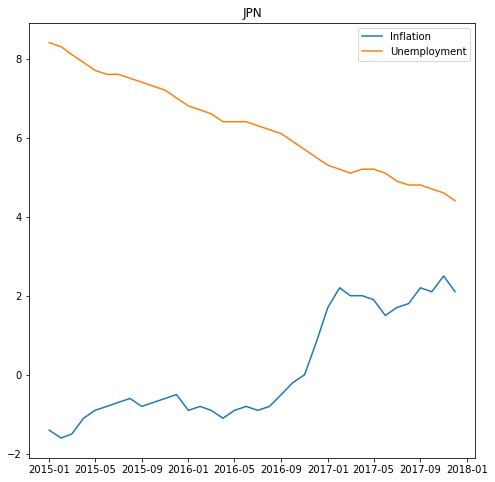

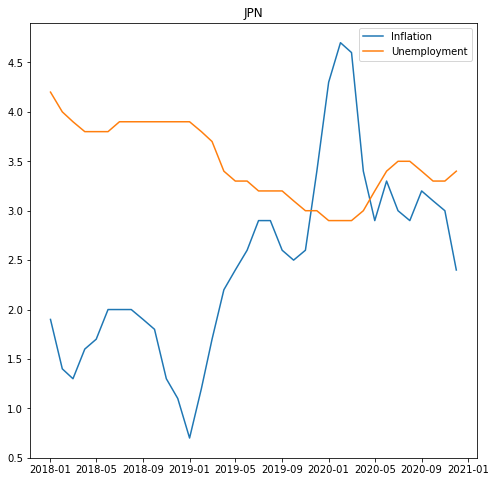

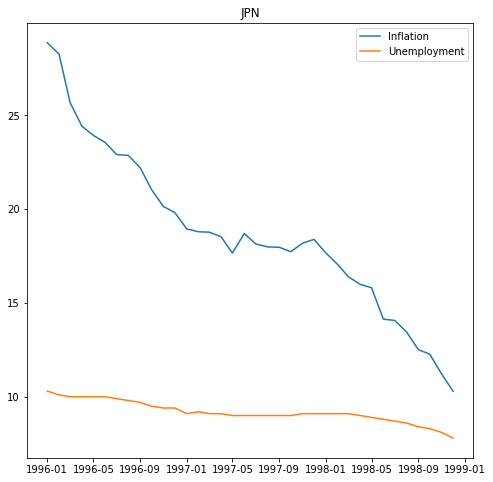

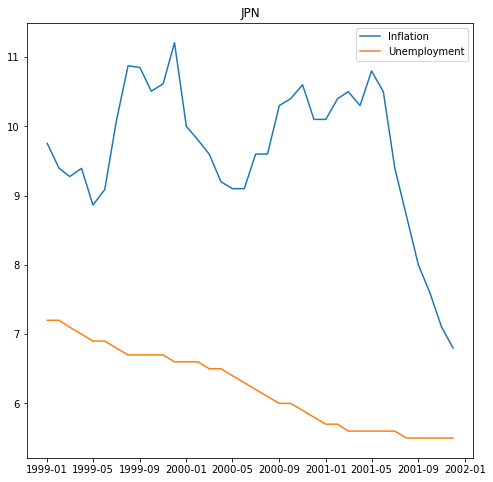

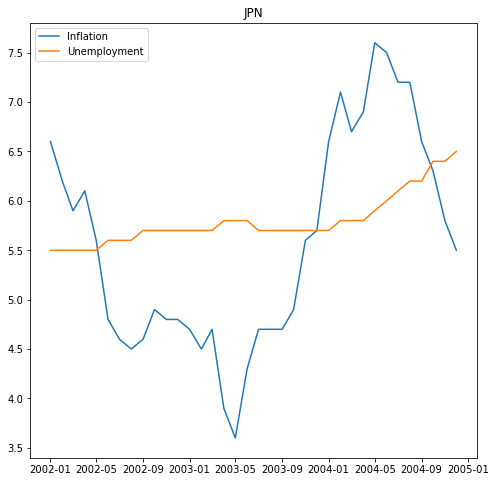

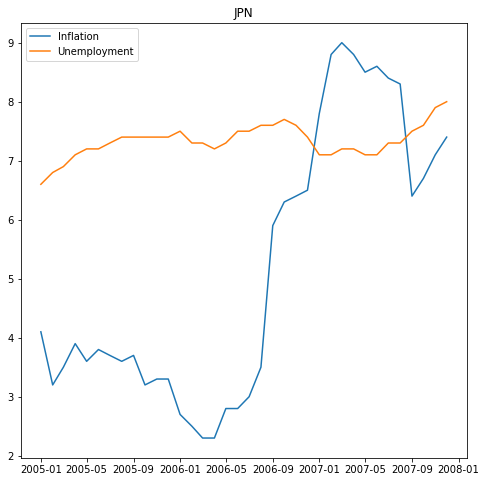

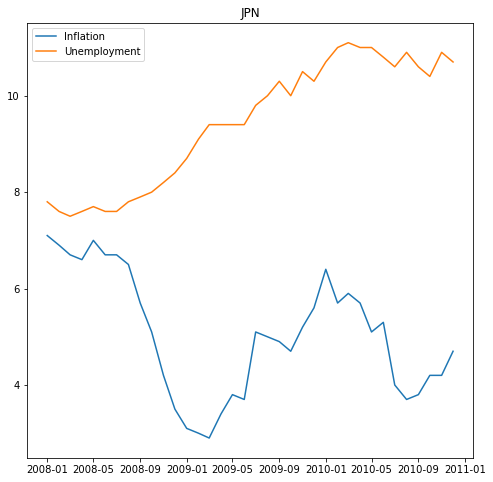

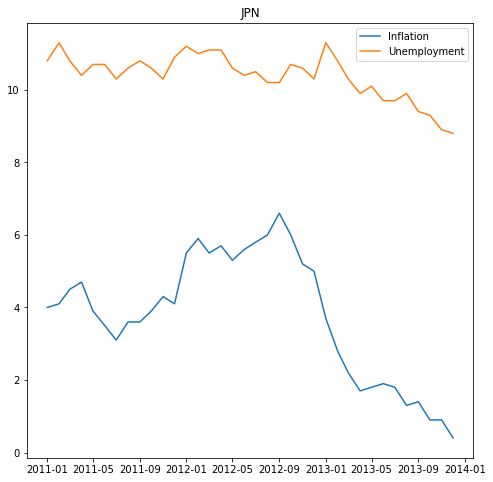

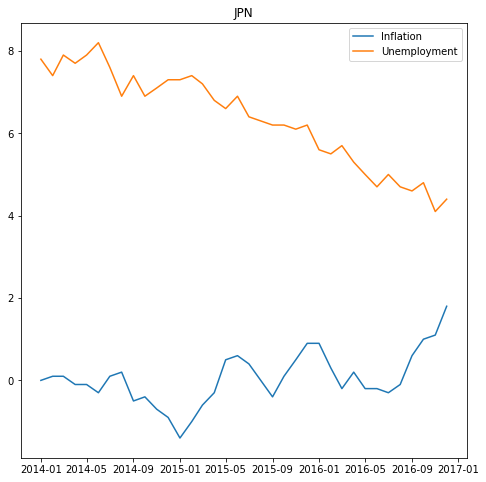

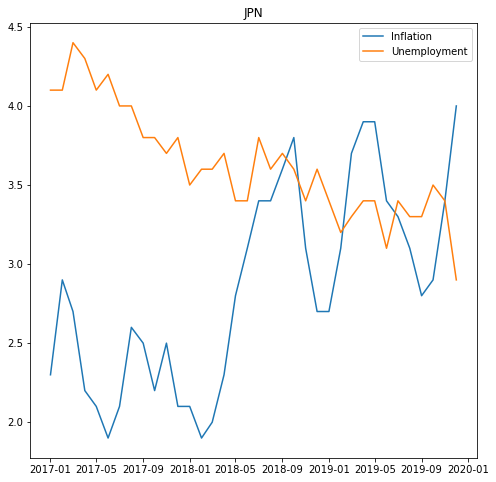

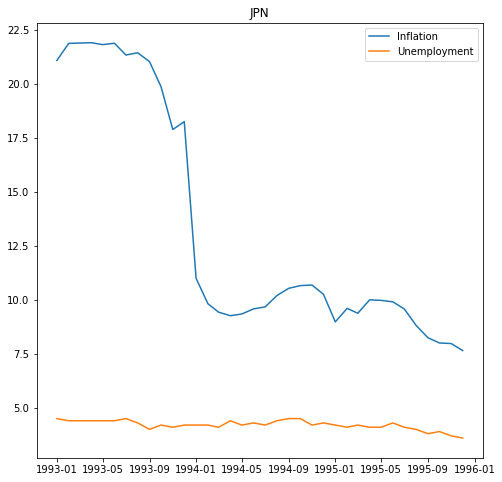

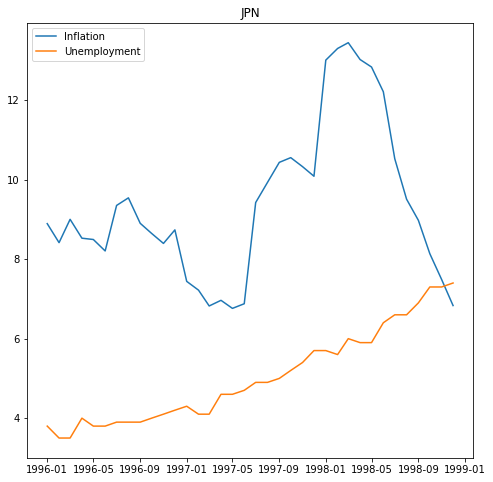

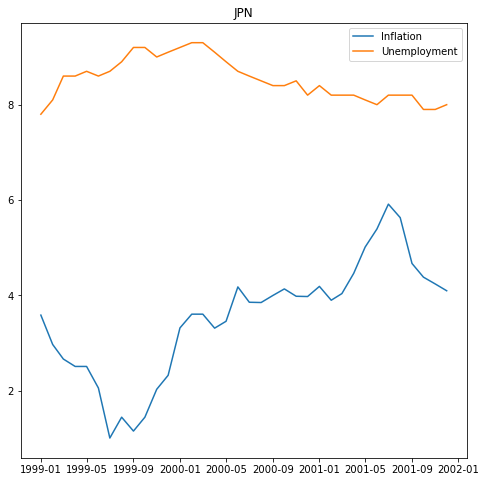

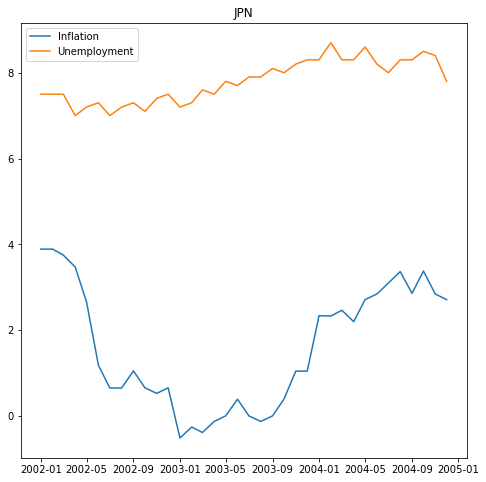

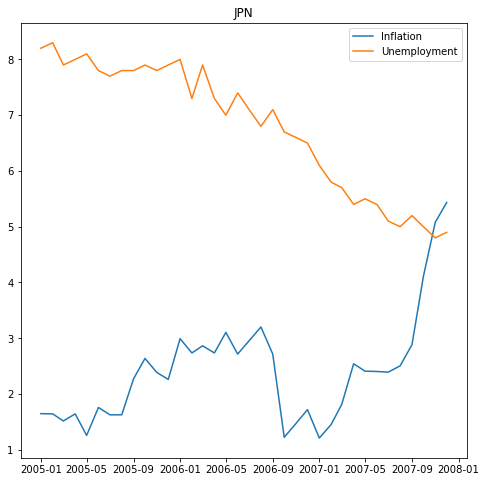

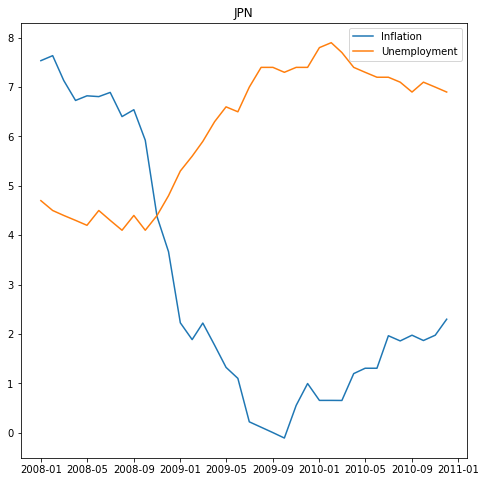

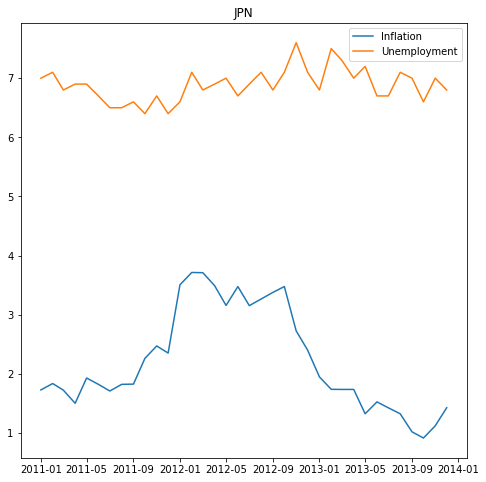

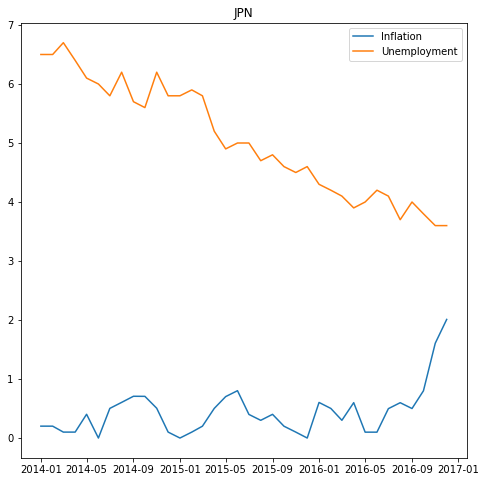

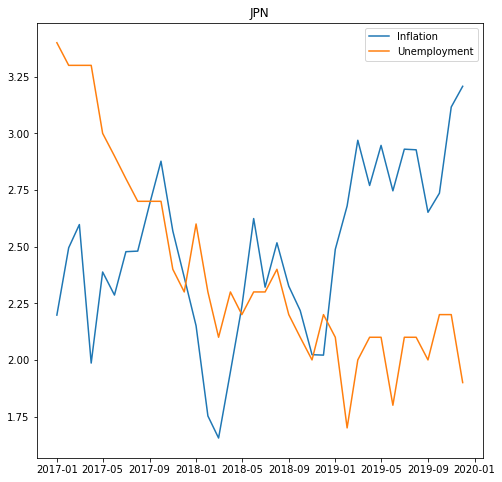

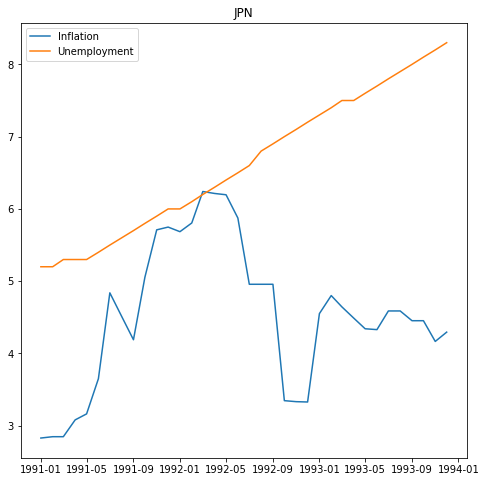

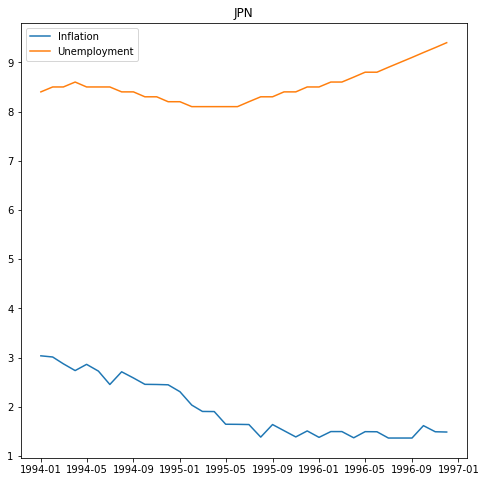

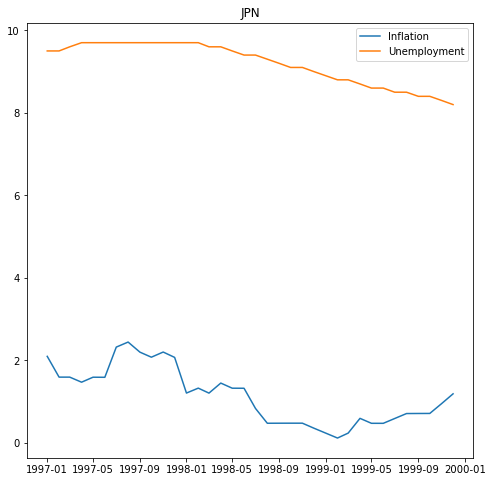

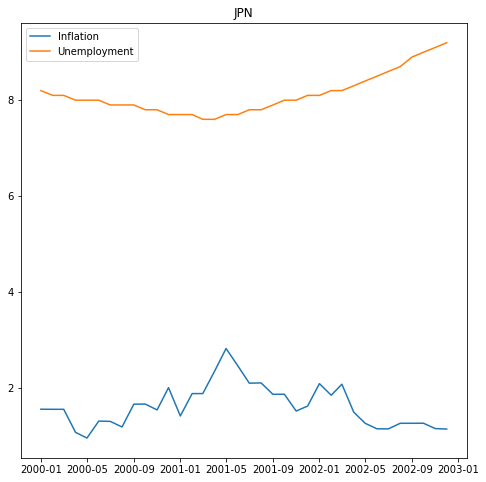

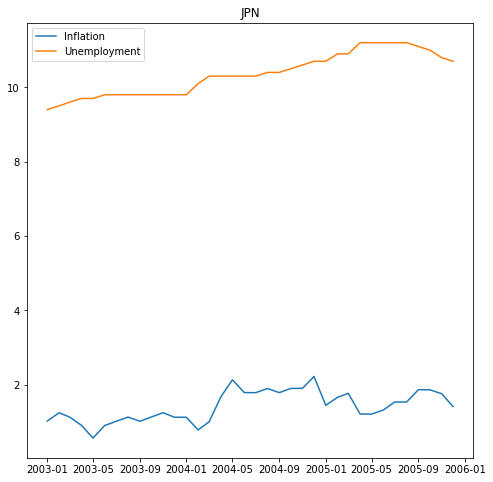

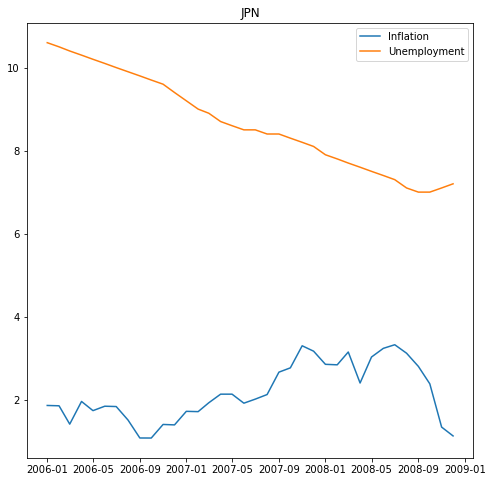

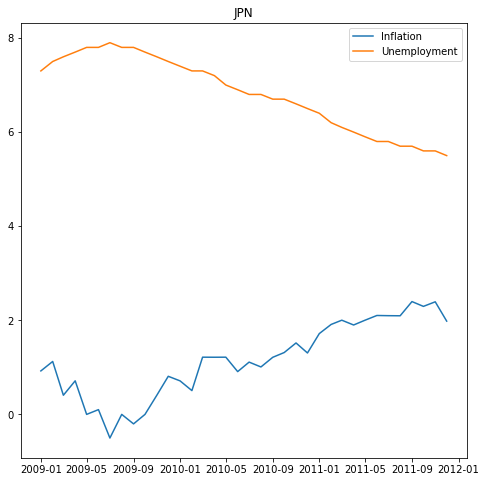

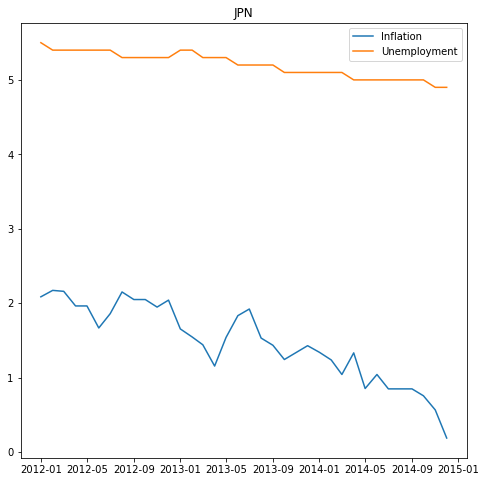

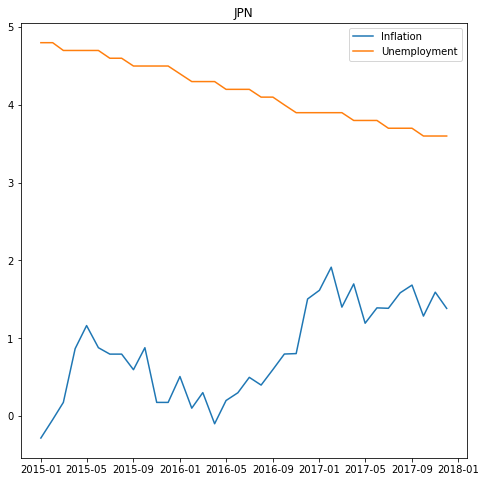

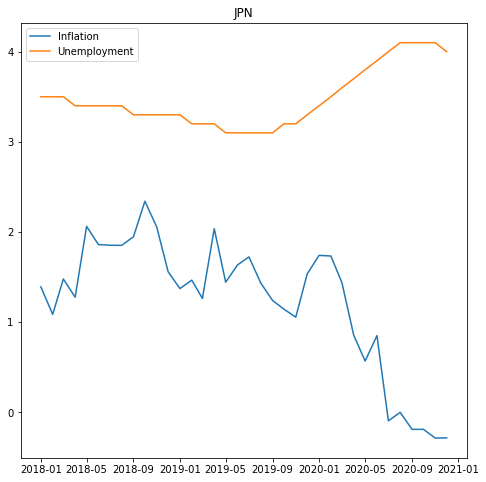

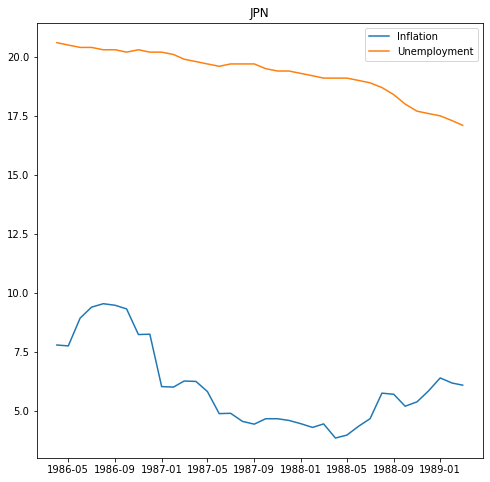

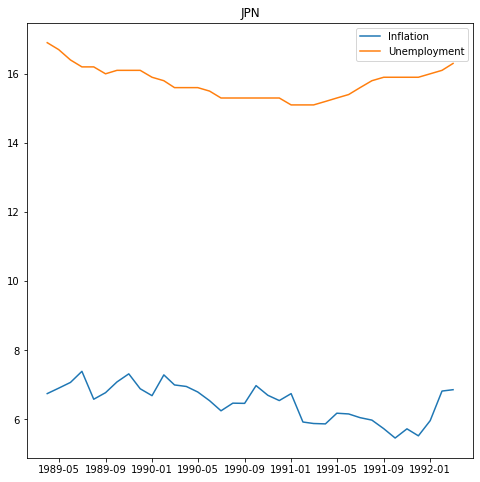

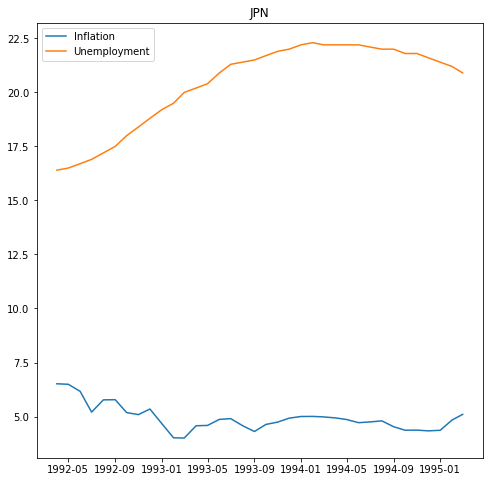

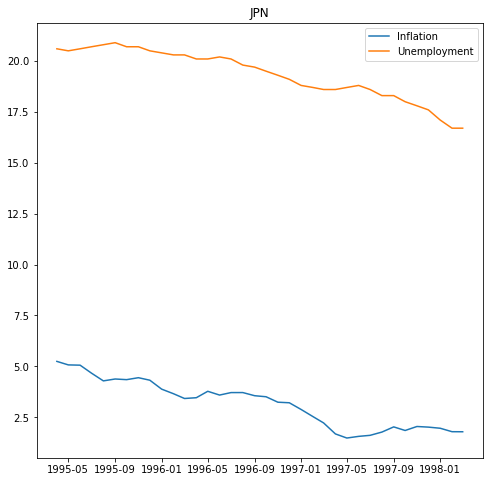

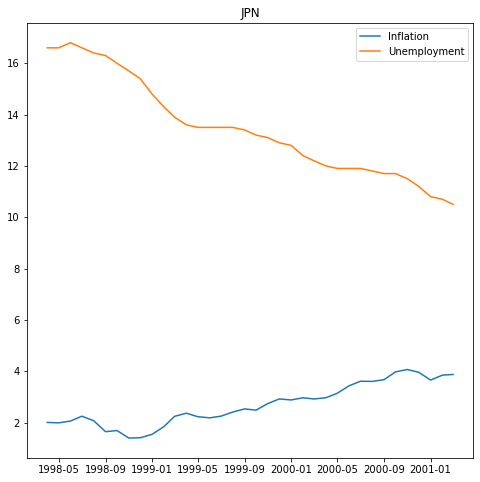

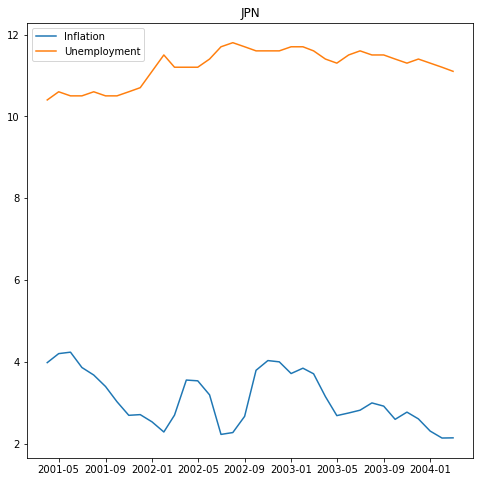

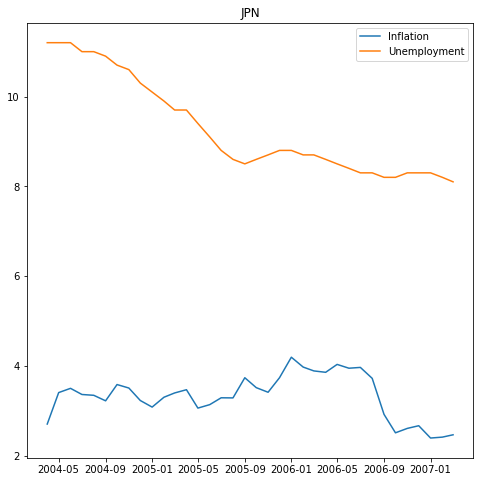

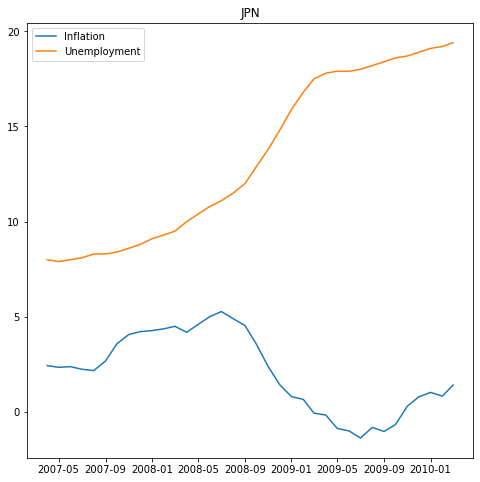

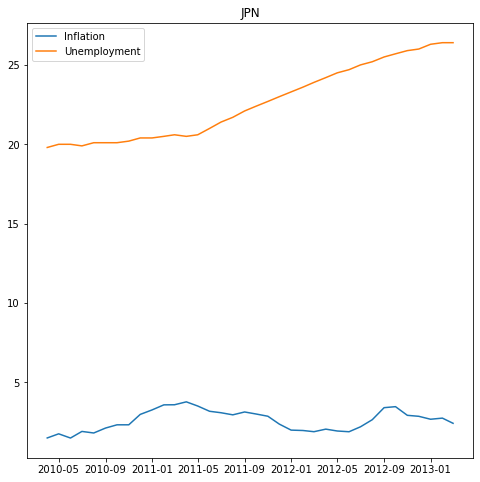

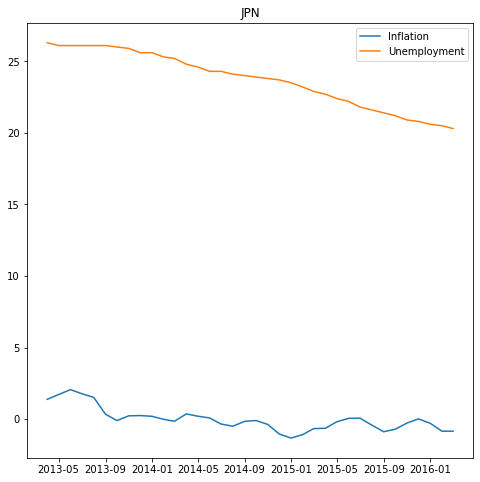

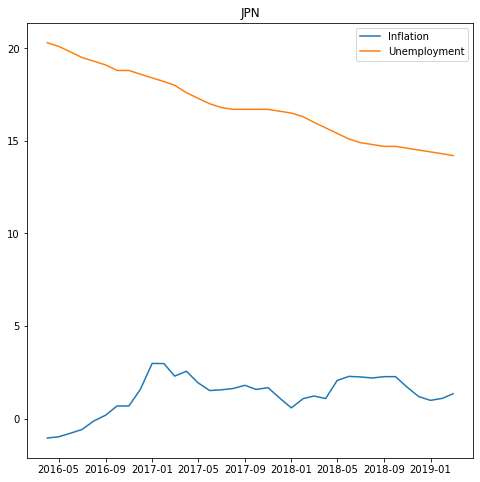

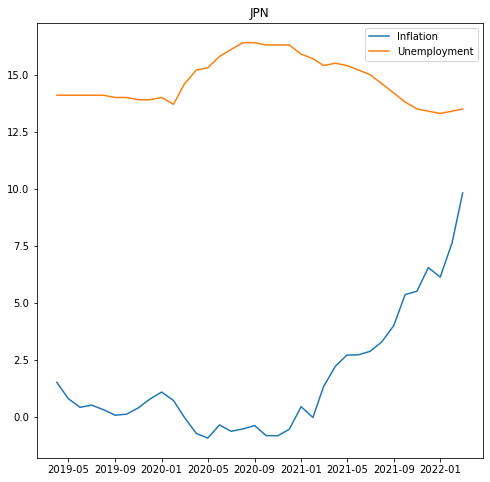

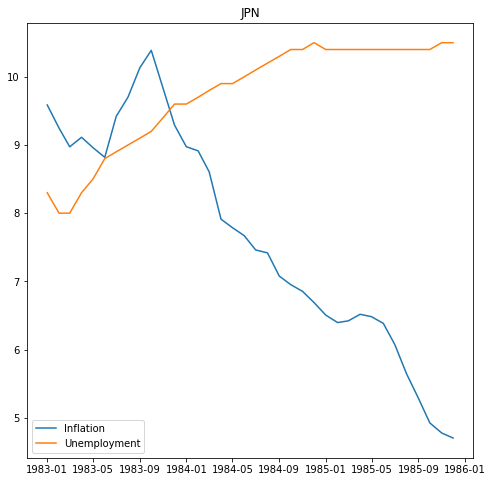

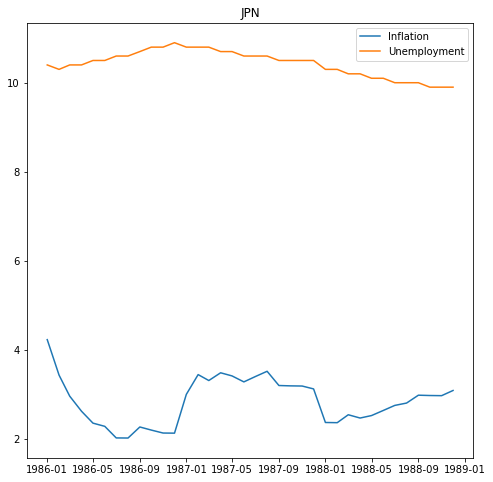

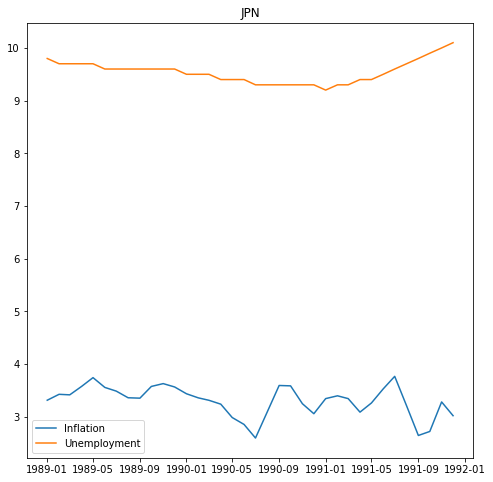

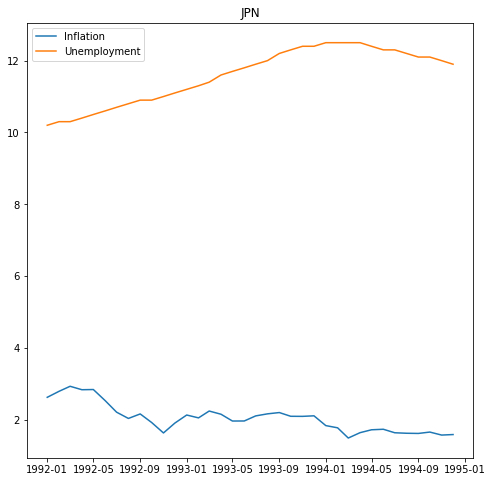

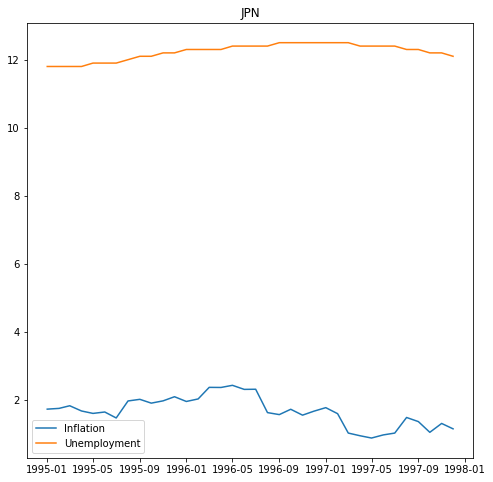

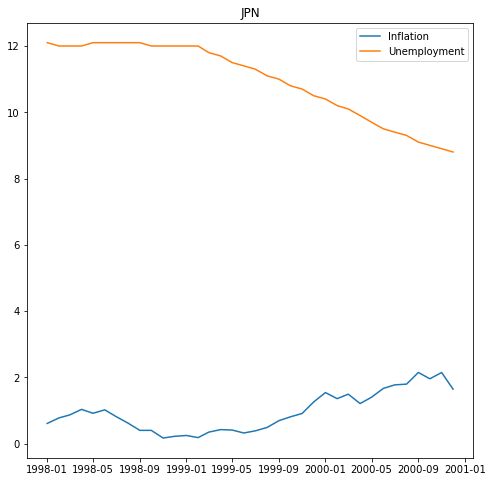

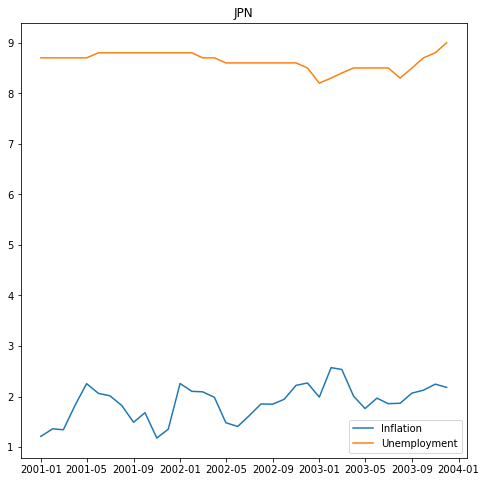

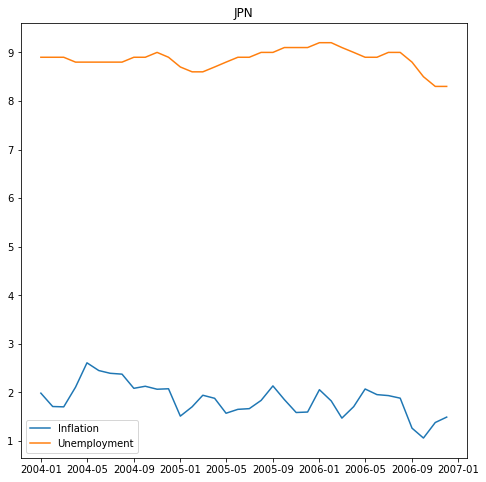

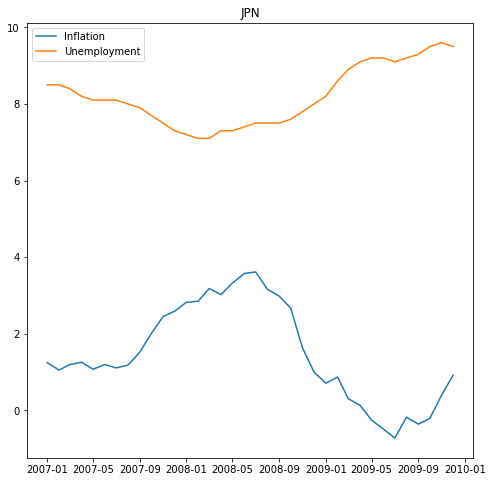

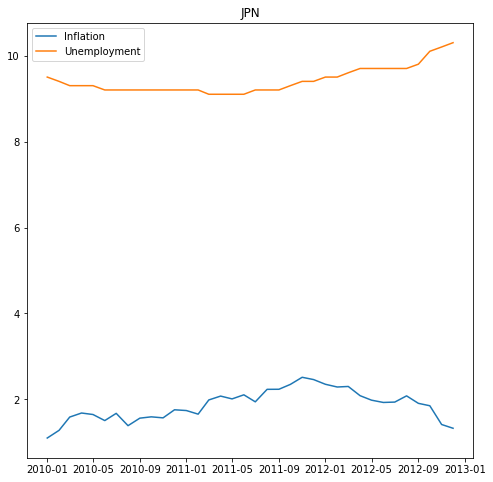

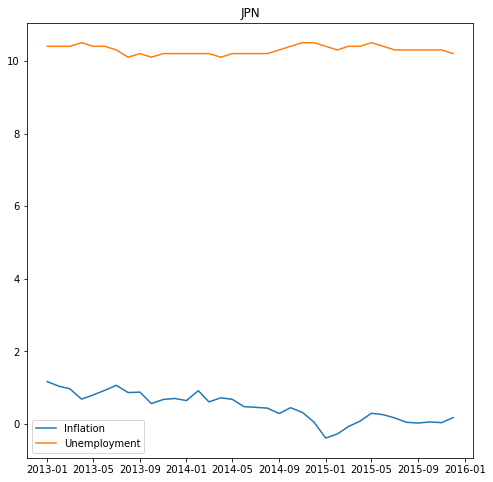

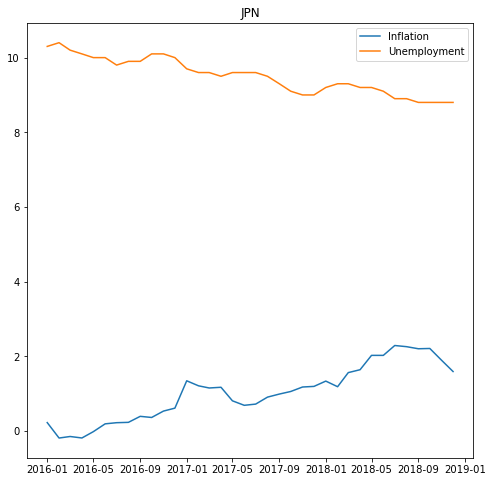

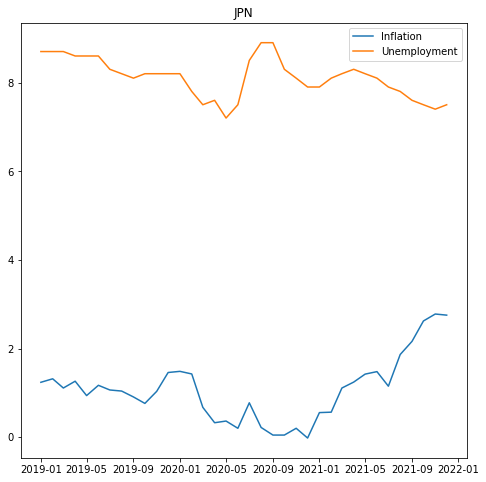

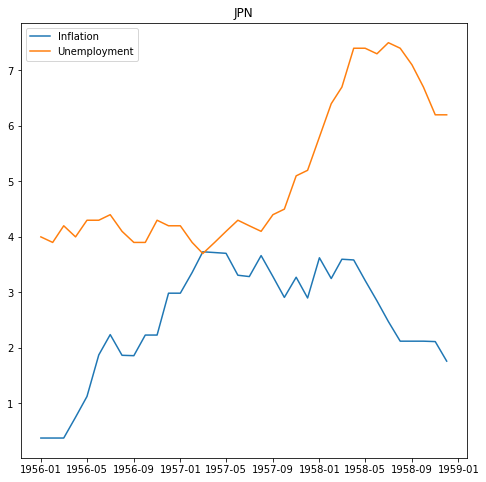

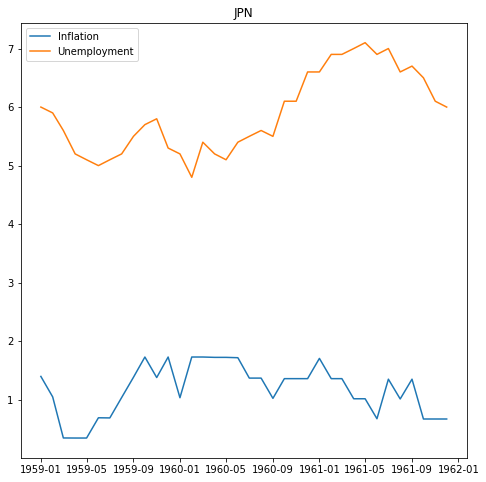

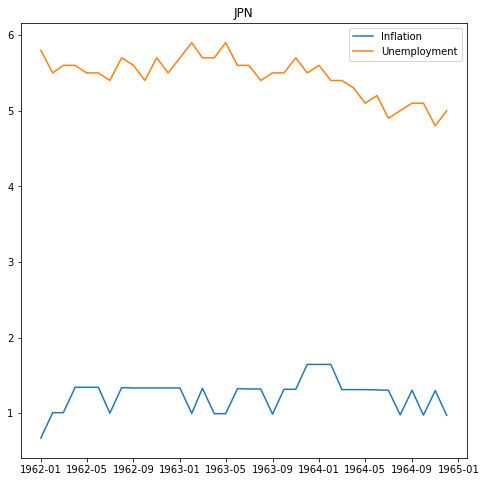

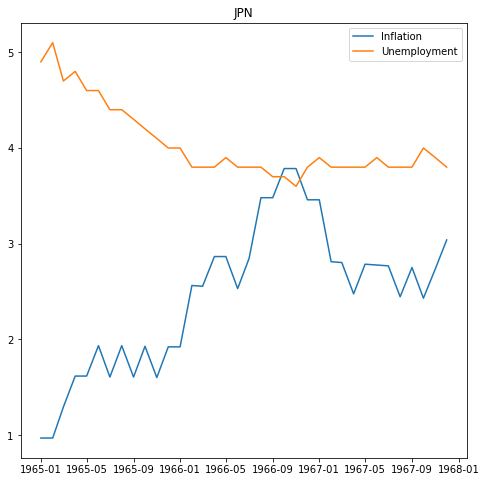

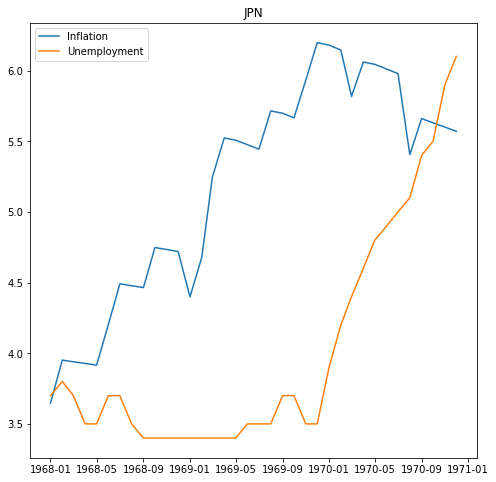

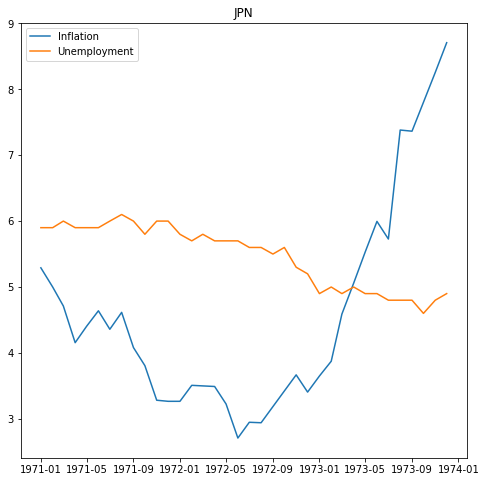

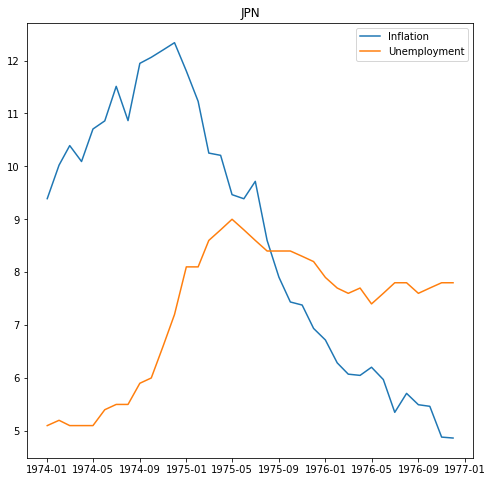

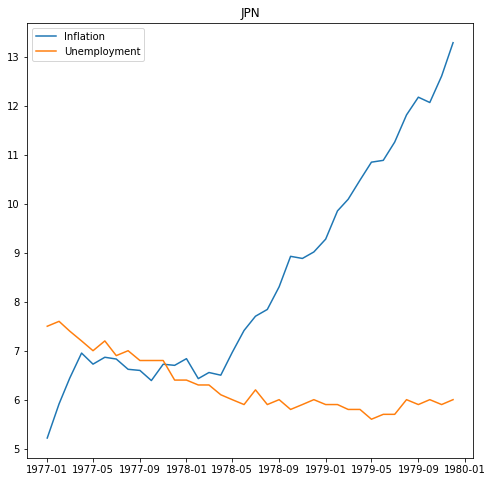

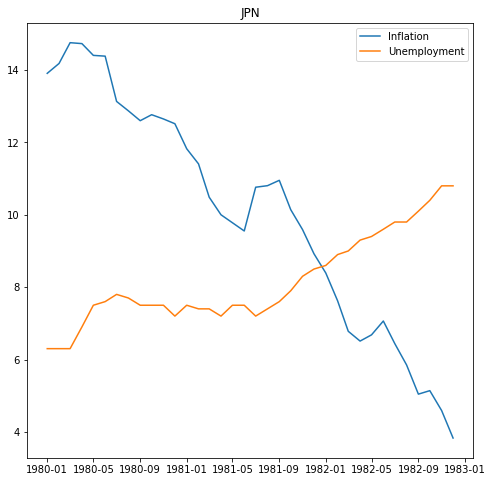

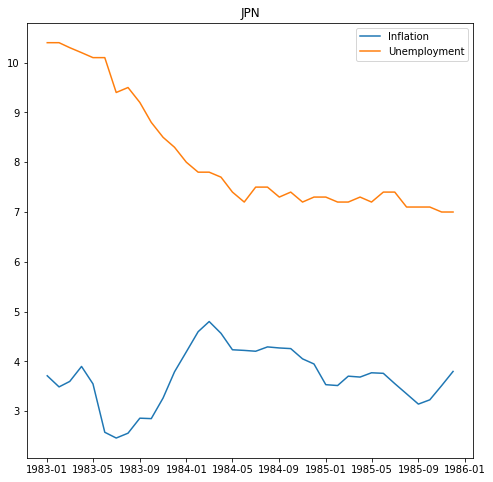

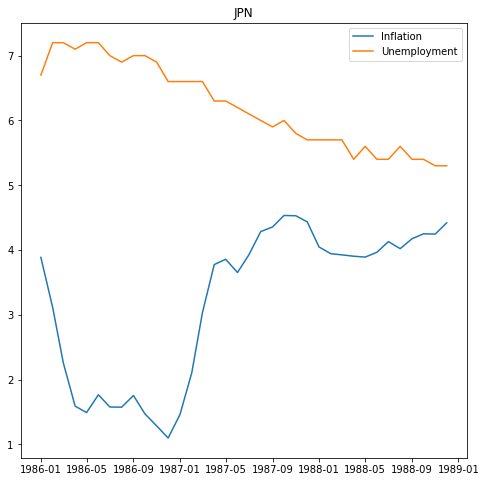

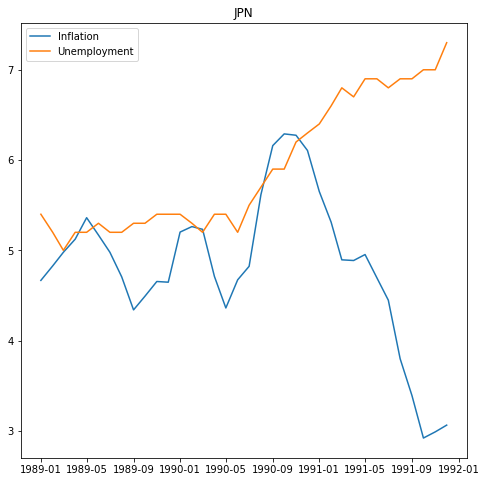

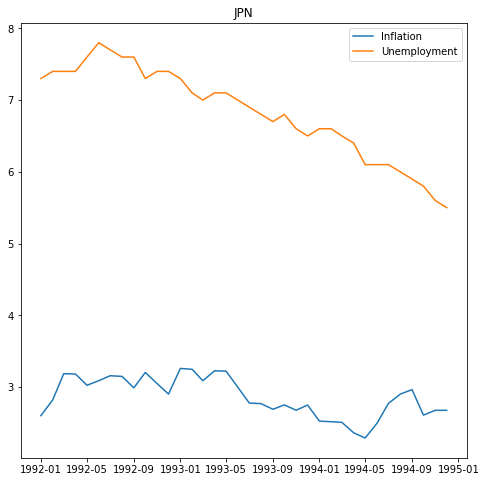

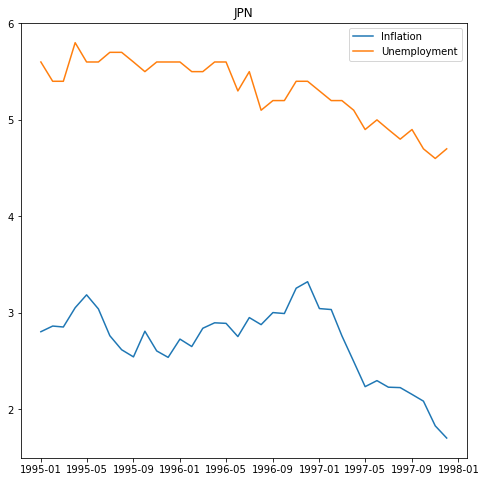

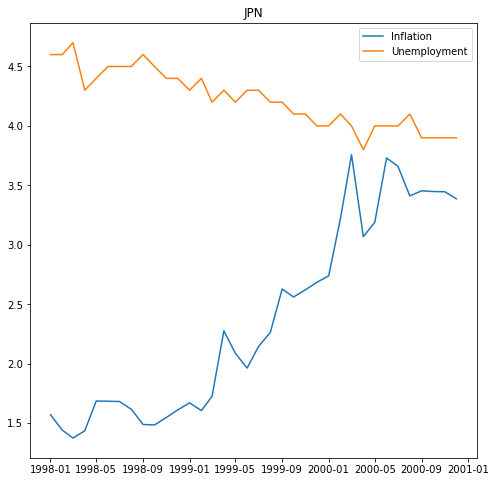

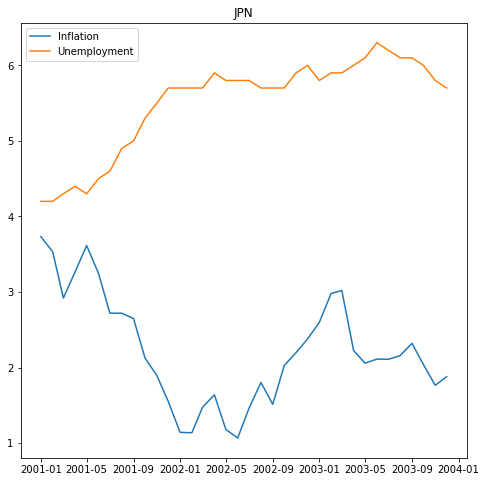

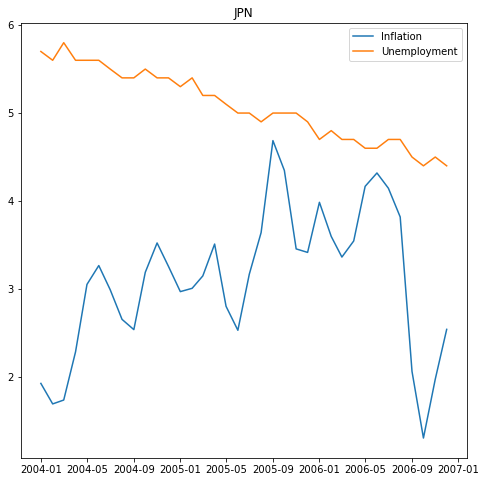

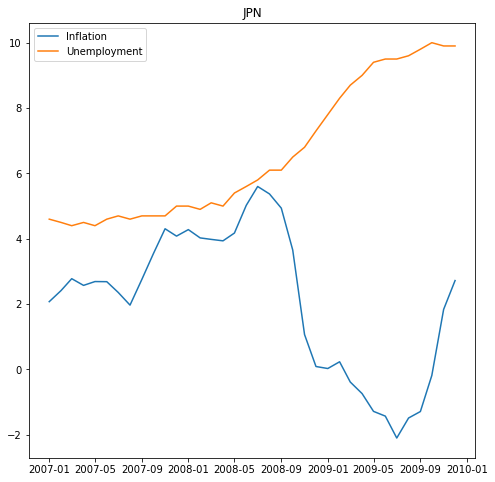

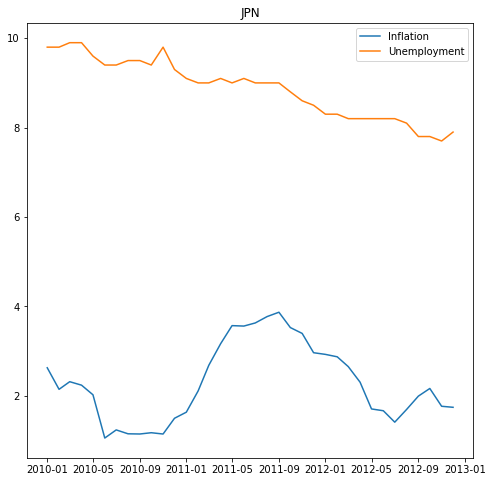

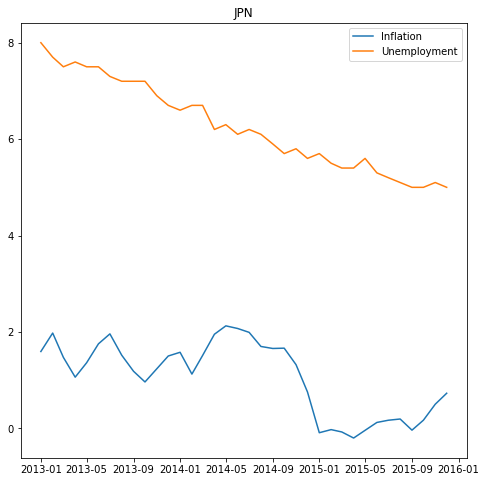

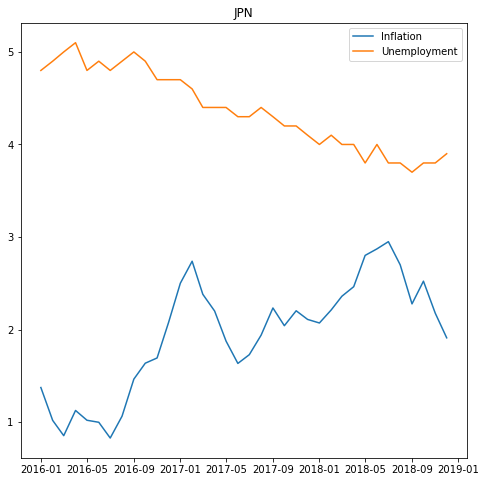

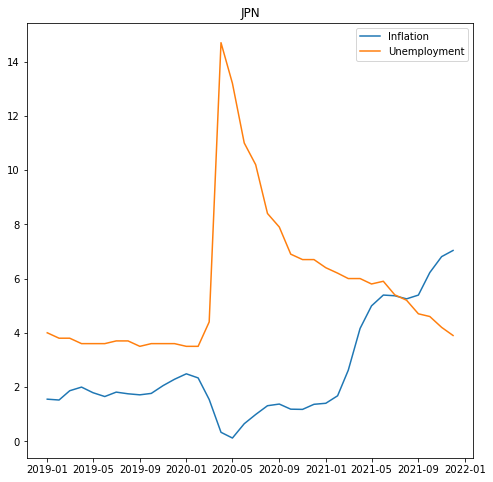

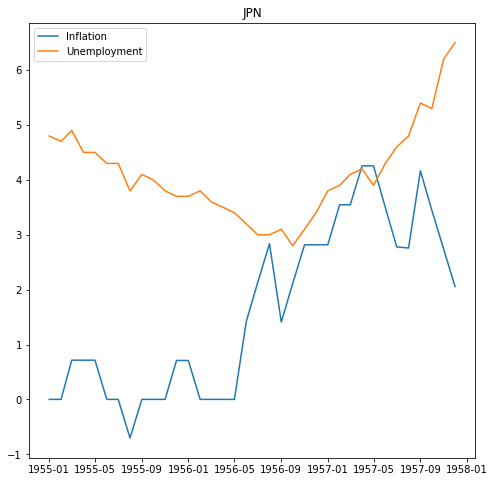

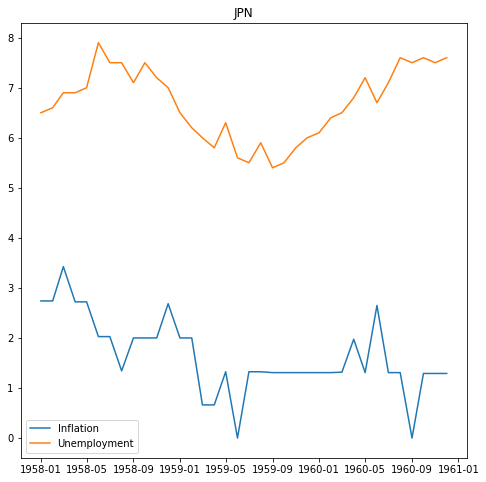

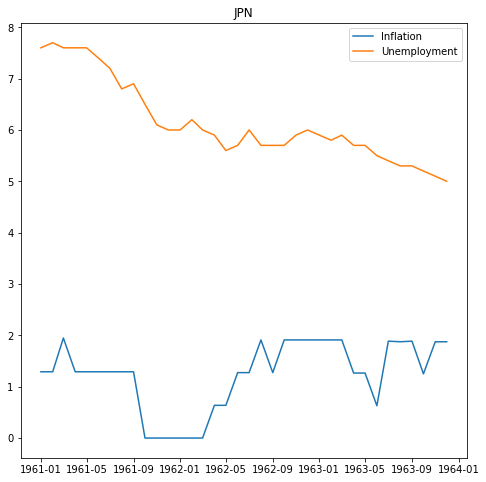

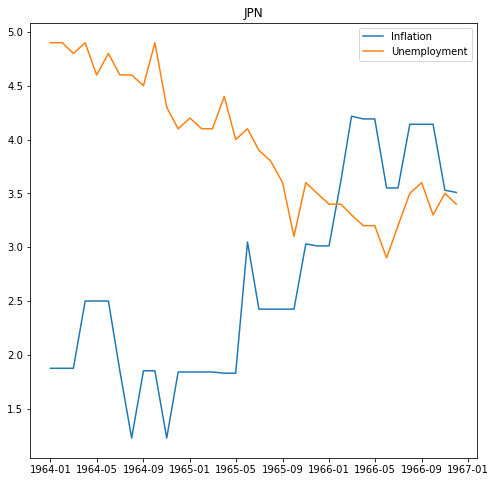

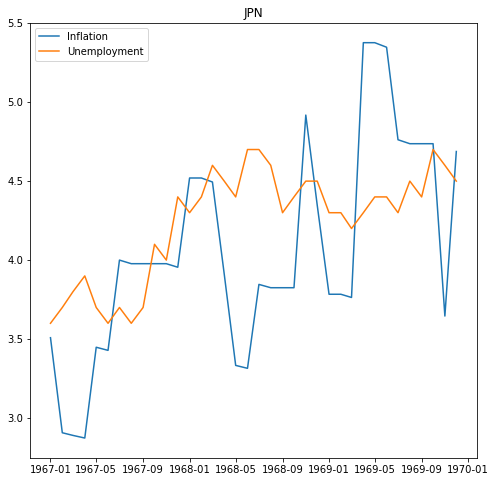

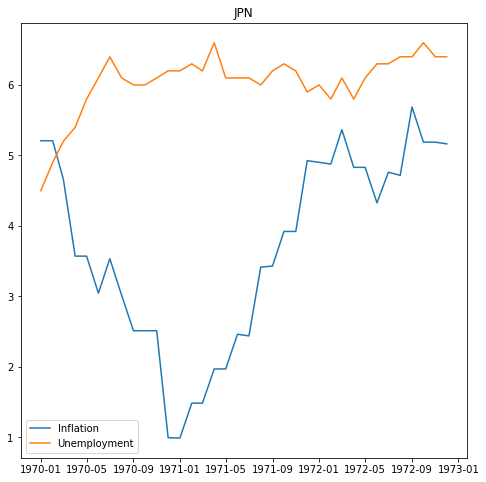

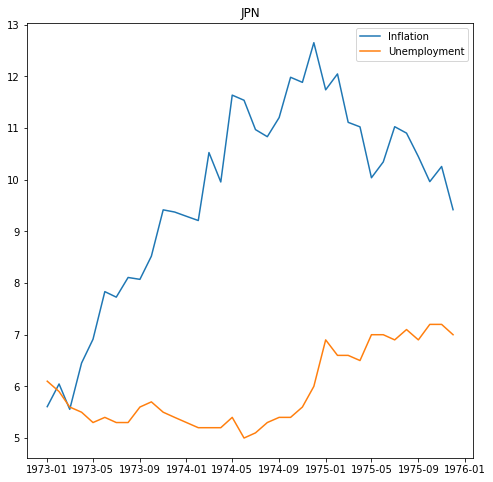

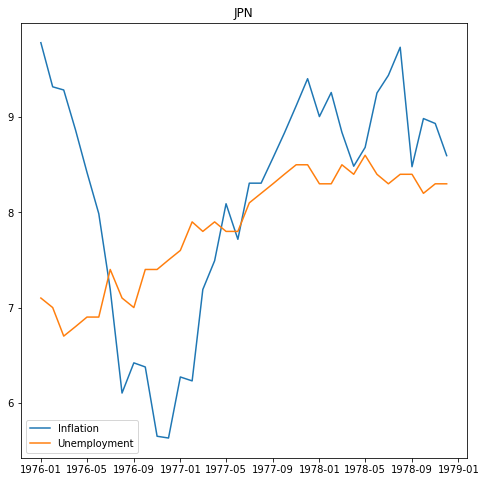

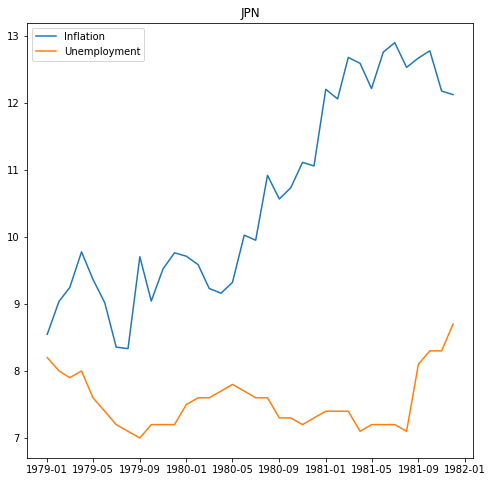

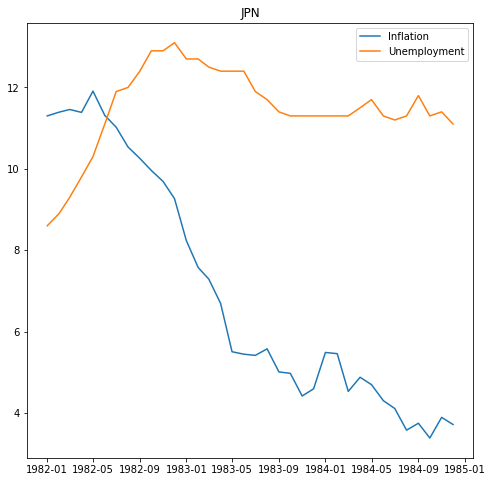

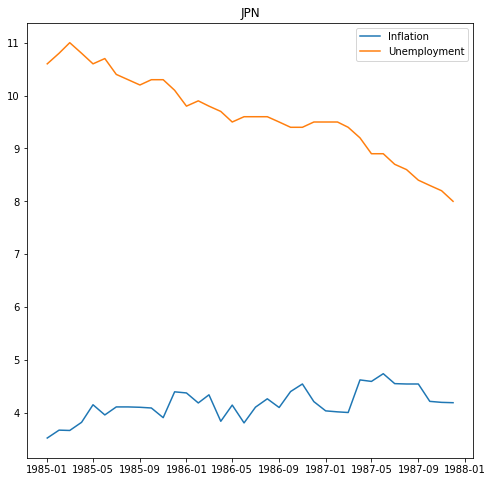

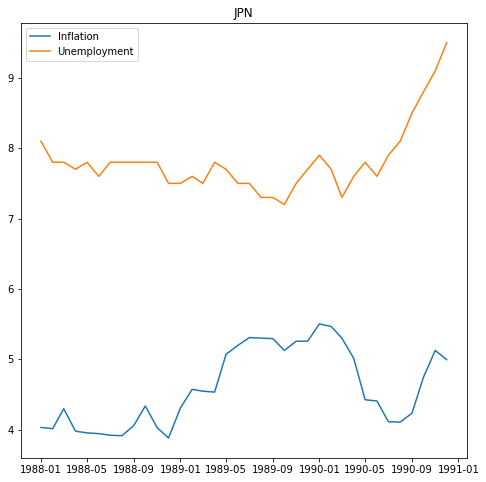

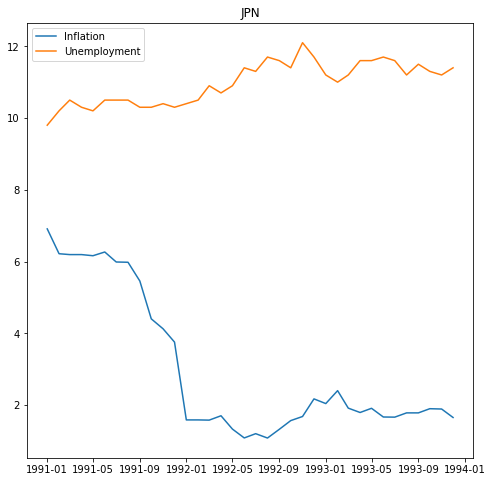

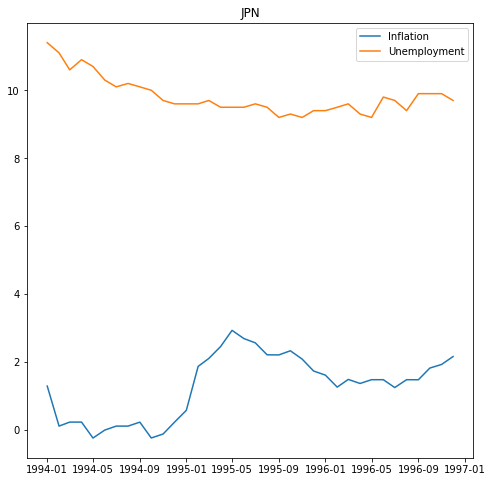

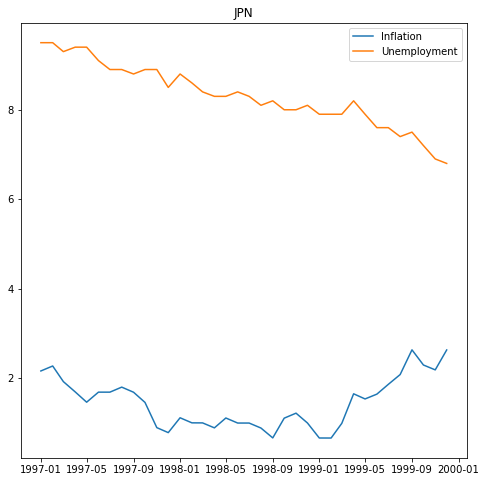

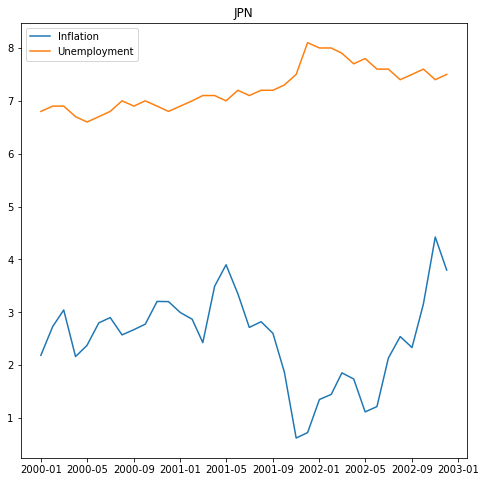

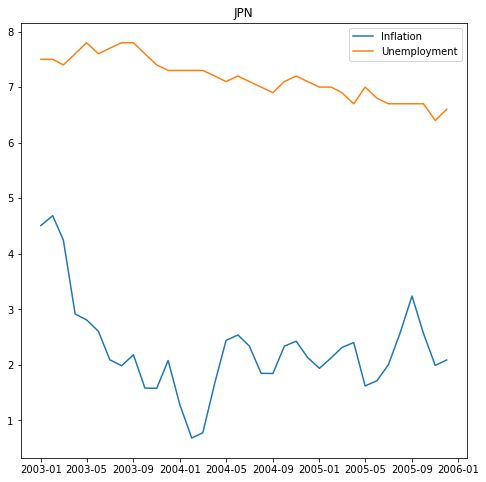

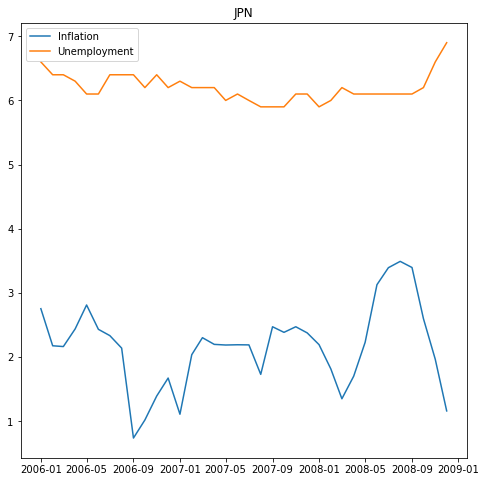

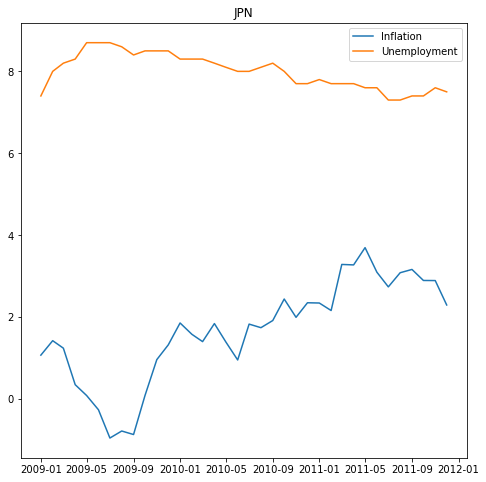

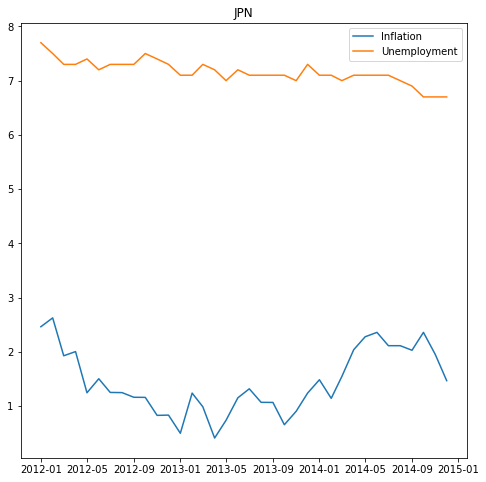

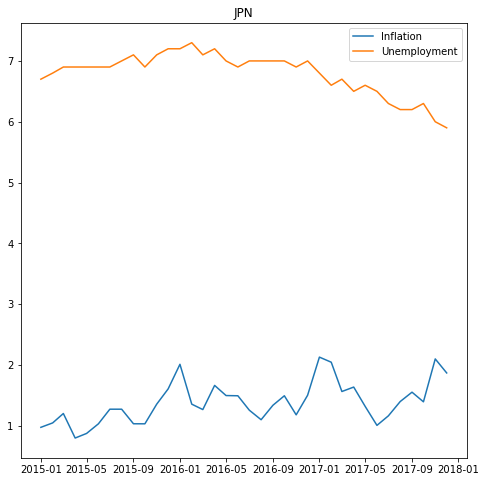

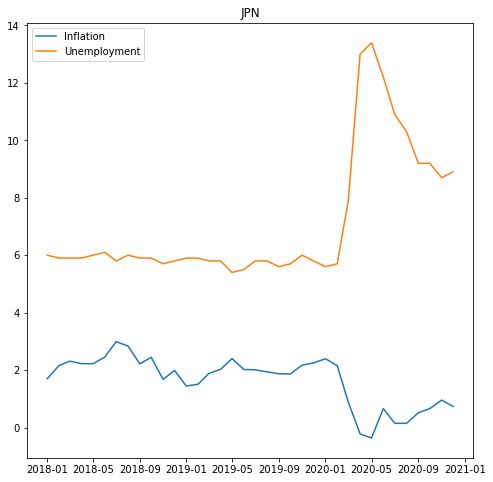

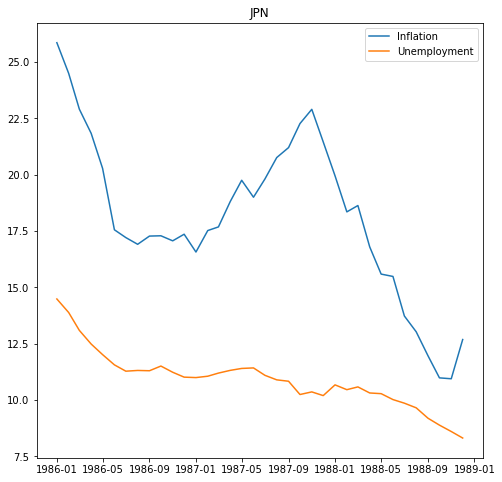

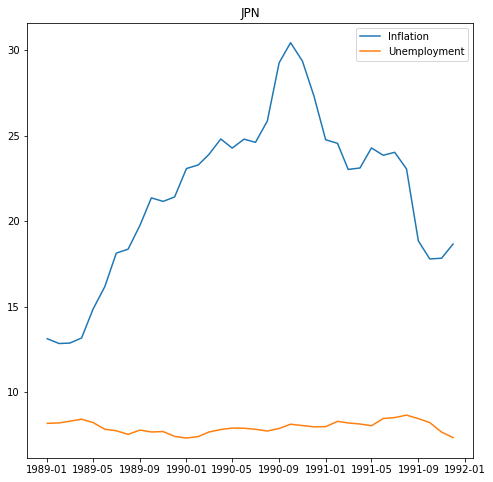

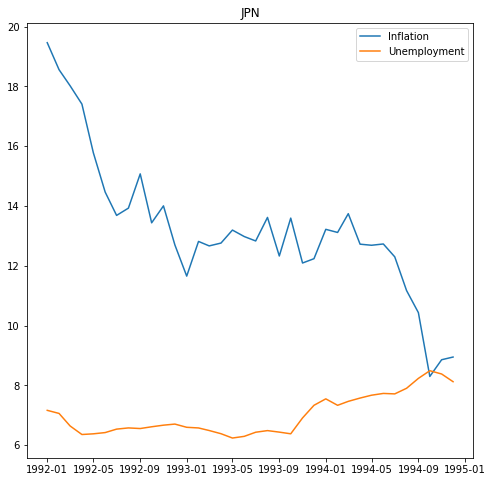

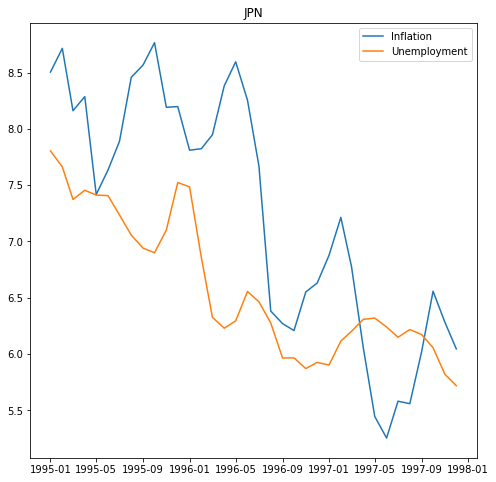

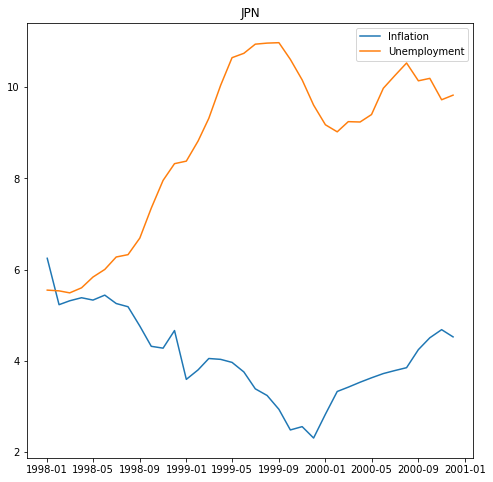

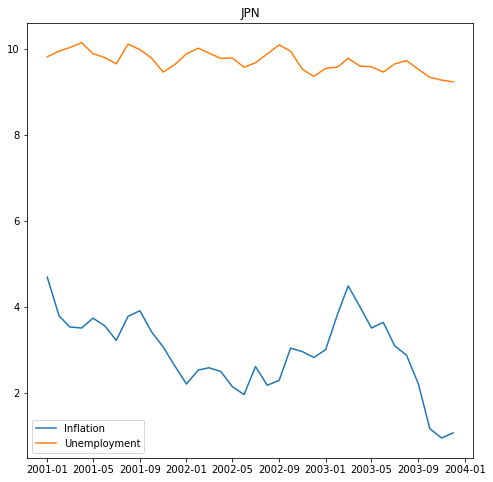

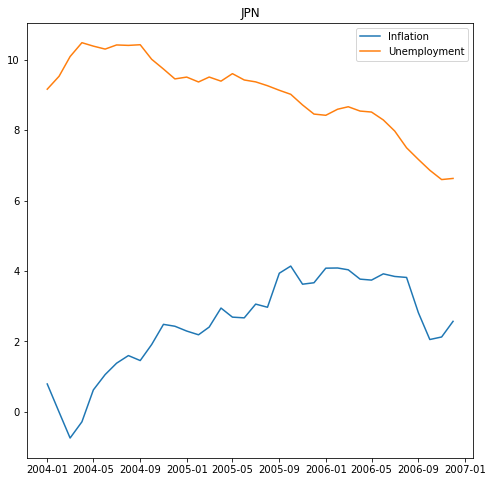

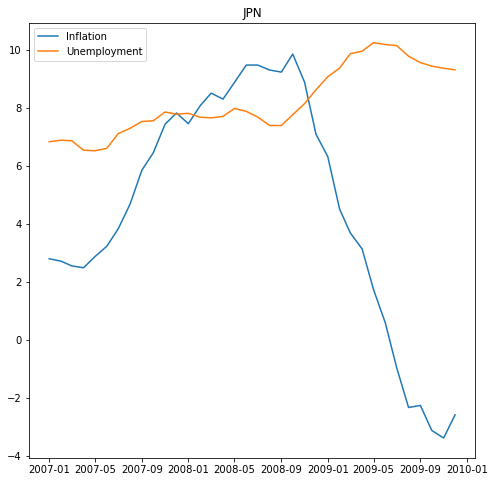

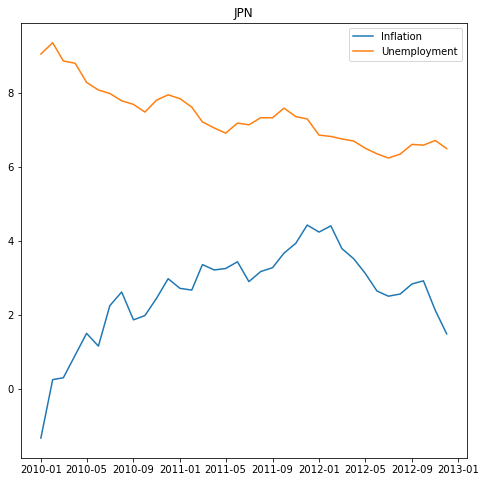

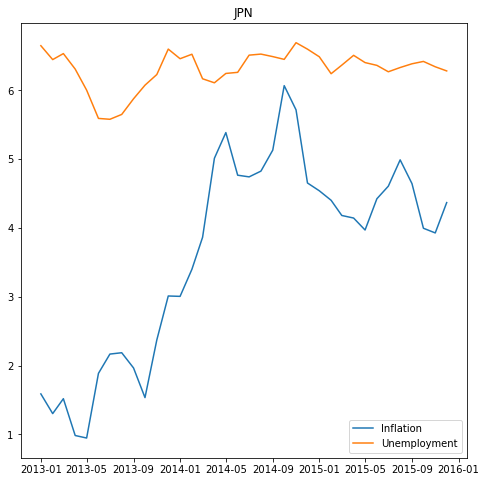

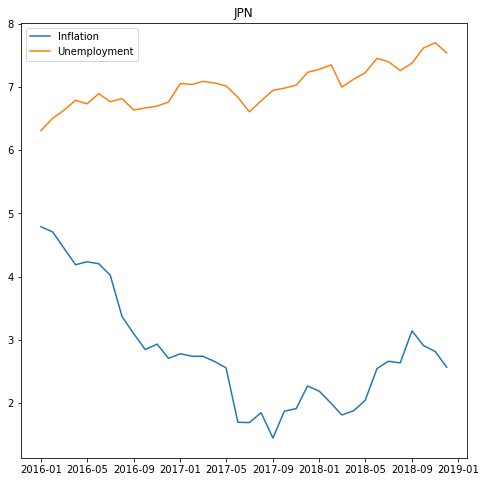

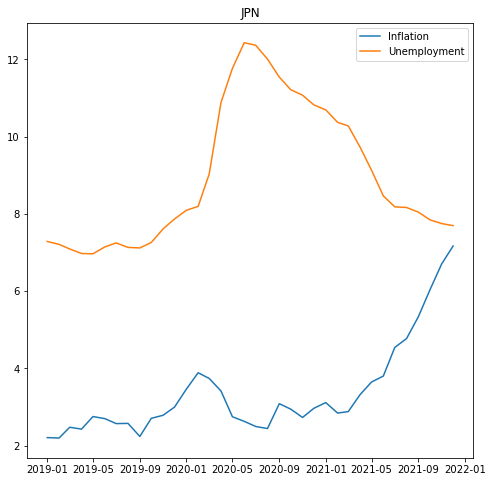

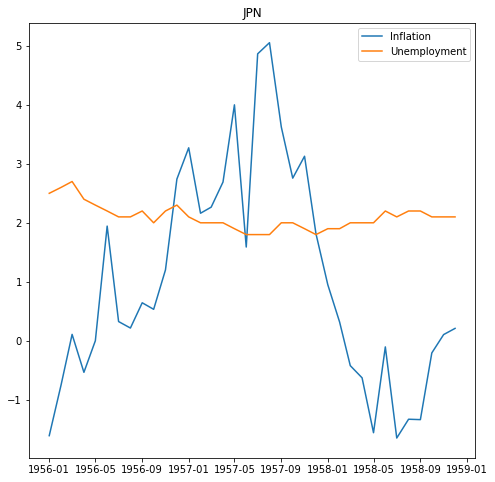

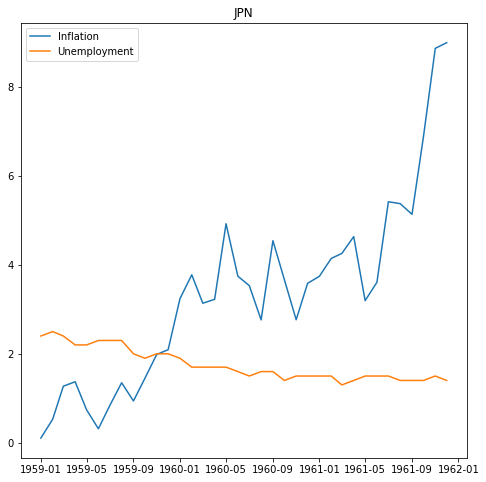

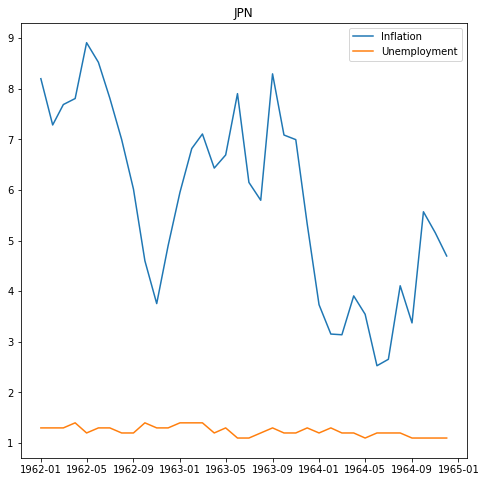

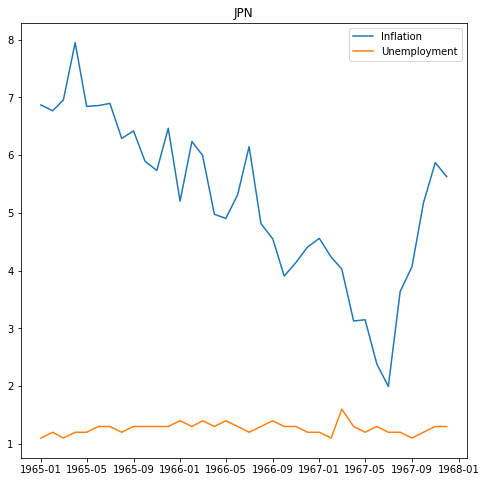

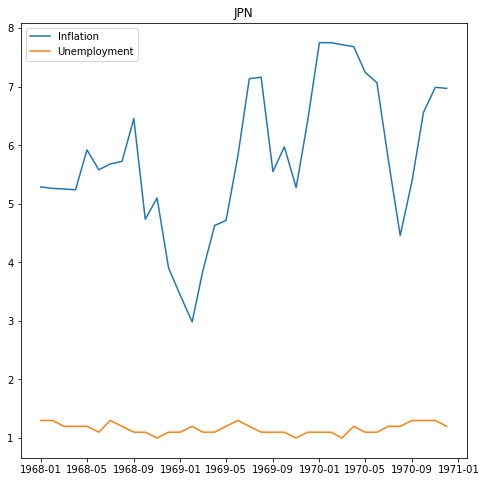

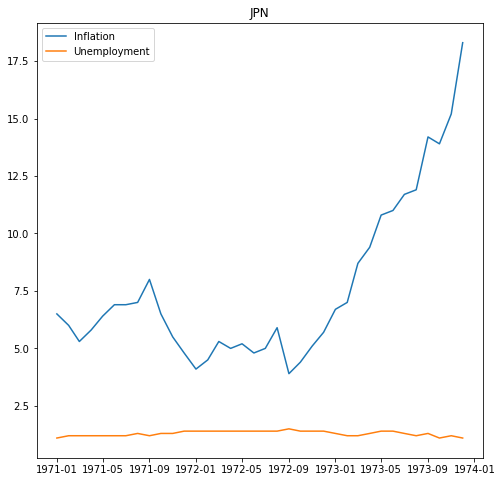

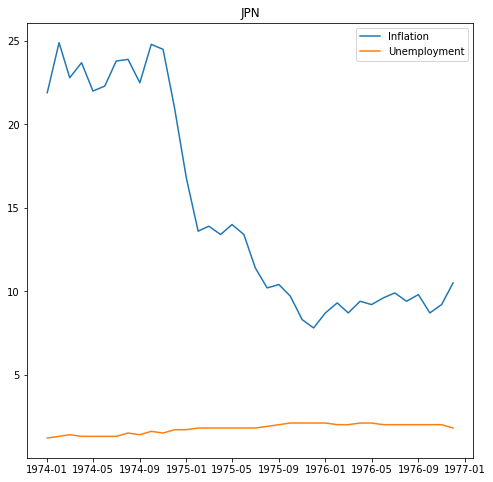

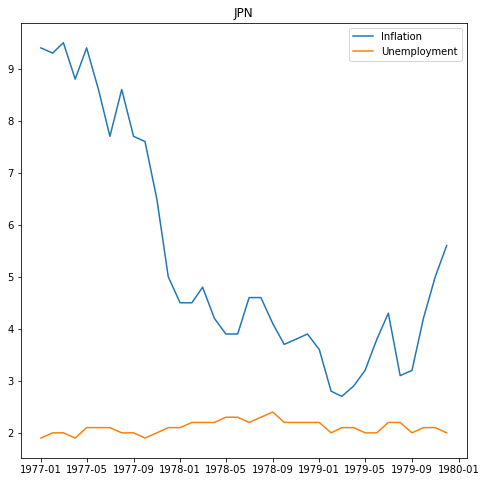

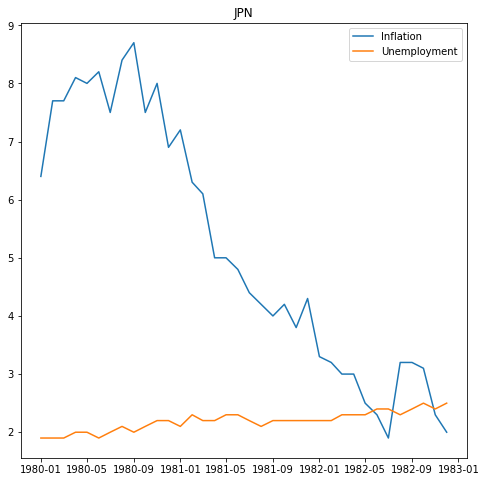

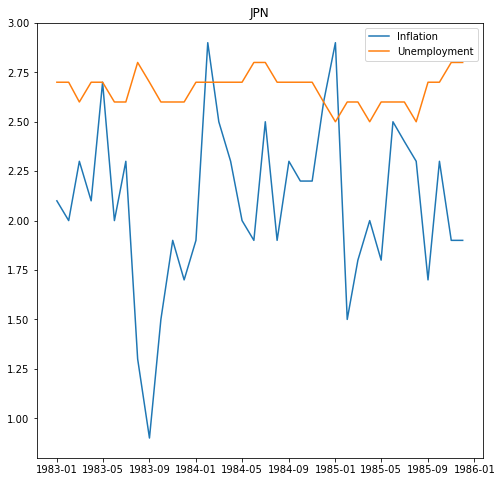

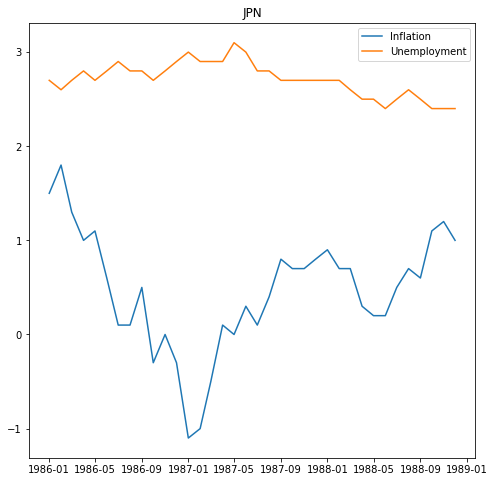

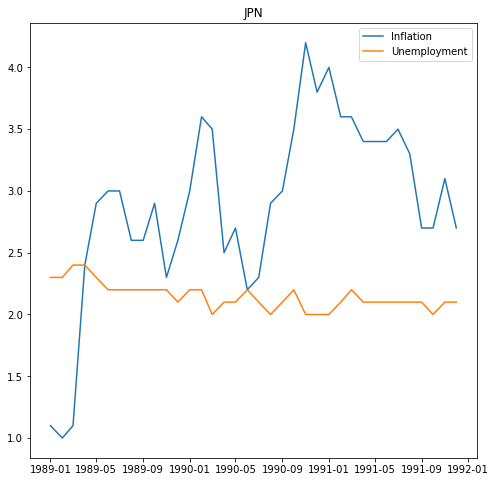

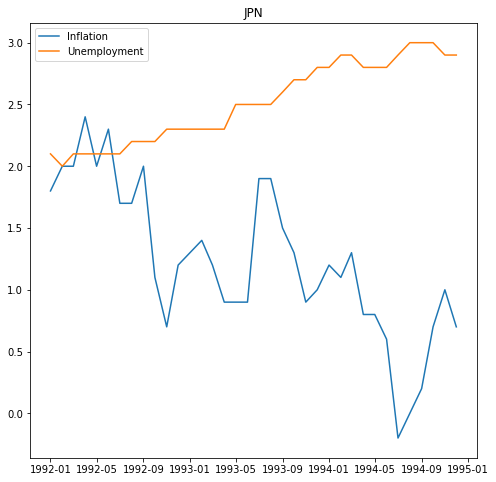

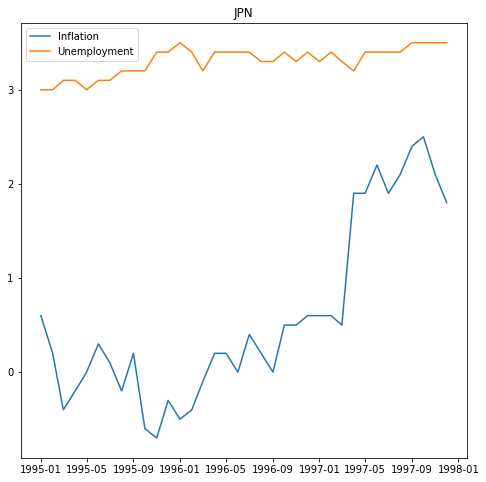

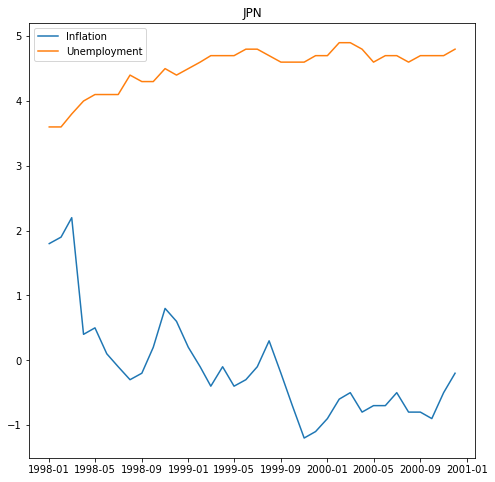

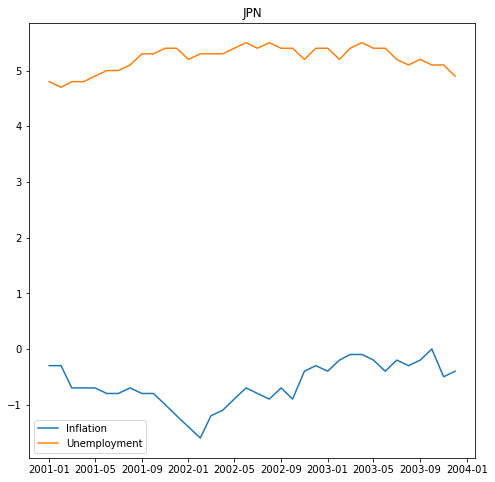

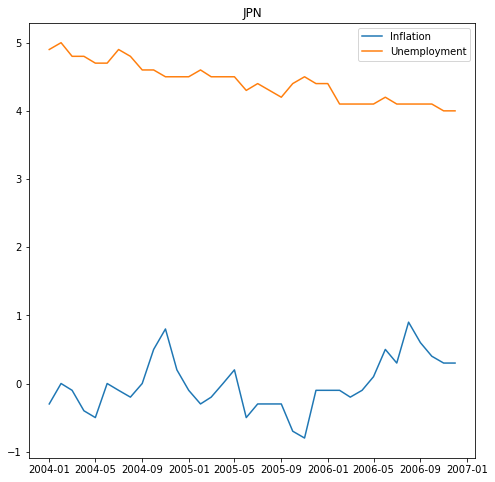

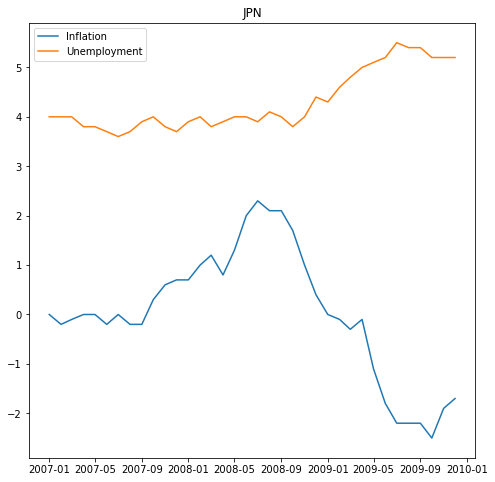

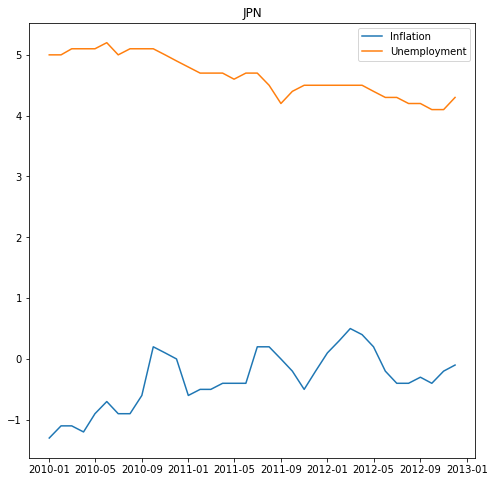

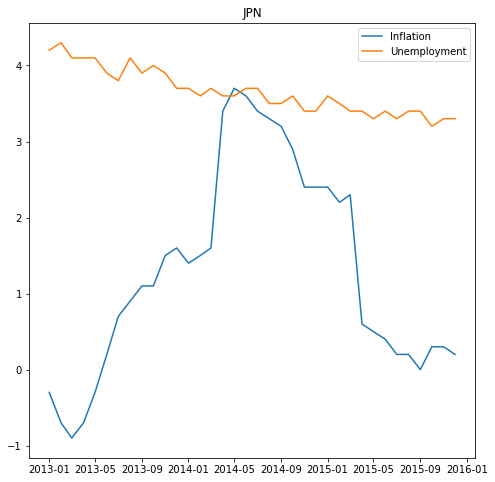

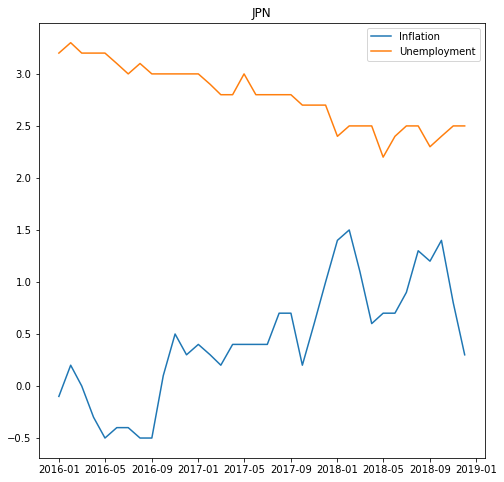

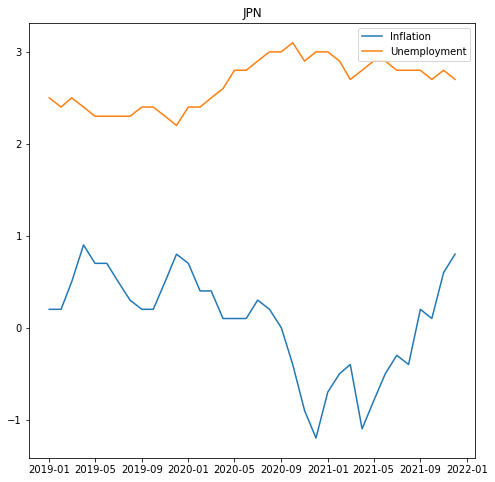

In [277]:
plt_num = 0
for country in country_list:
    for span in range(int(len(country[0])/36)):
        # 3 years = 36 samples
        span = span * 36
        plt.figure(plt_num, figsize=(8, 8))
        plt.plot(country[0]["TIME"][span:span + 36], country[0]["Value"][span:span + 36])
        plt.plot(country[1]["TIME"][span:span + 36], country[1]["Value"][span:span + 36])
        plt.legend(["Inflation", "Unemployment"])
        plt.title(location)
        plt.show
        plt_num += 1

In [5]:
stan_file_linear = r"C:\Studia\Data-Analytics\Projekt-Proper\Inflation_model_linear.stan"
model_linear = CmdStanModel(stan_file=stan_file_linear)

INFO:cmdstanpy:found newer exe file, not recompiling


In [6]:
stan_file_phillips = r"C:\Studia\Data-Analytics\Projekt-Proper\Inflation_model_phillips.stan"
model_phillips = CmdStanModel(stan_file=stan_file_phillips)

INFO:cmdstanpy:found newer exe file, not recompiling


In [92]:
country = country_list[0]
span_start_idx = 36
span = 36
fit1, fit2 = sample_models(country=country, span=span, span_start_idx=span_start_idx, model1=model_linear, model2=model_phillips)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)

chain 1 |███▌      | 00:00 Iteration:  400 / 1500 [ 26%]  (Warmup)


chain 1 |██████▍   | 00:00 Iteration:  800 / 1500 [ 53%]  (Sampling)


chain 1 |█████████▍| 00:00 Iteration: 1300 / 1500 [ 86%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status




chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  100 / 1500 [  6%]  (Warmup)
chain 1 |██▎       | 00:01 Iteration:  200 / 1500 [ 13%]  (Warmup)


chain 1 |██▉       | 00:02 Iteration:  300 / 1500 [ 20%]  (Warmup)




chain 1 |███▌      | 00:02 Iteration:  400 / 1500 [ 26%]  (Warmup)


chain 1 |████▋     | 00:03 Iteration:  501 / 1500 [ 33%]  (Sampling)



chain 1 |█████▎    | 00:04 Iteration:  600 / 1500 [ 40%]  (Sampling)


chain 1 |█████▉    | 00:05 Iteration:  700 / 1500 [ 46%]  (Sampling)


chain 1 |██████▍   | 00:06 Iteration:  800 / 1500 [ 53%]  (Sampling)


chain 1 |███████   | 00:07 Iteration:  900 / 1500 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:08 Iteration: 1000 / 1500 [ 66%]  (Sampling)


chain 1 |████████▏ | 00:09 Iteration: 1100 / 1500 [ 73%]  (Sampling)


chain 1 |████████▊ | 00:09 Iteration: 1200 / 1500 [ 80%]  (Sampling)


chain 1 |█████████▍| 00:10 Iteration: 1300 / 150


INFO:cmdstanpy:CmdStan done processing.


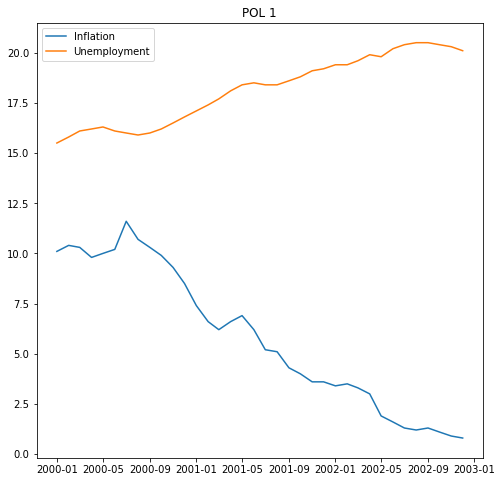

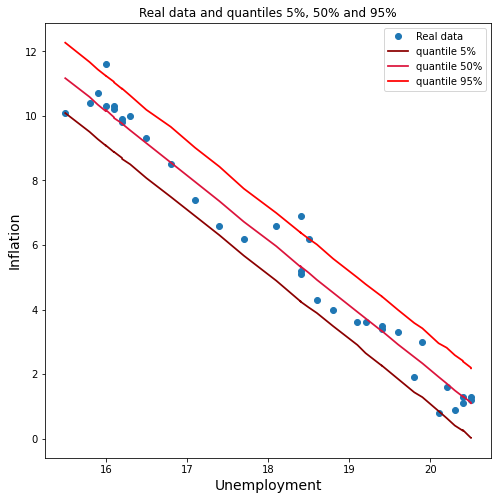

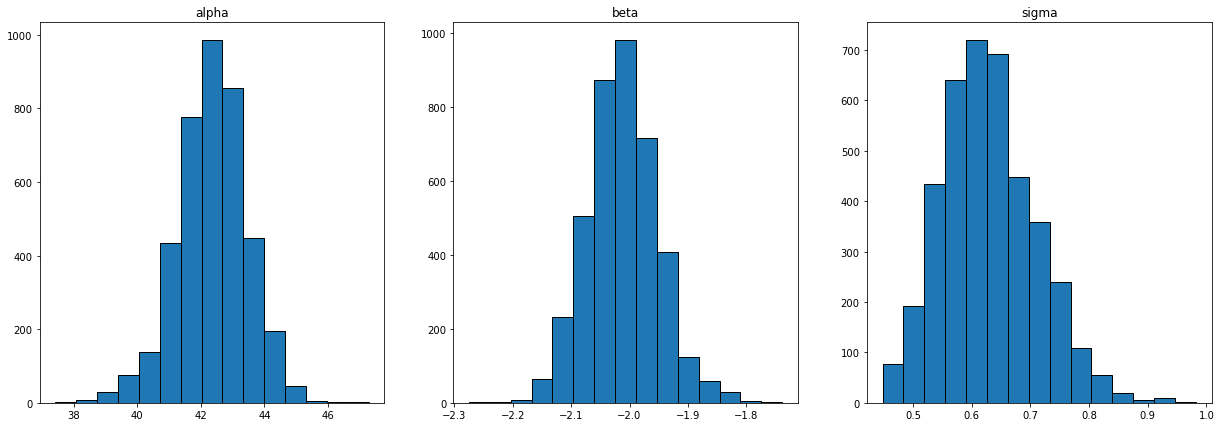

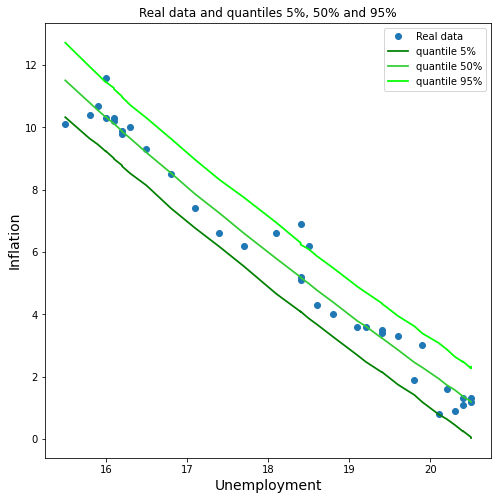

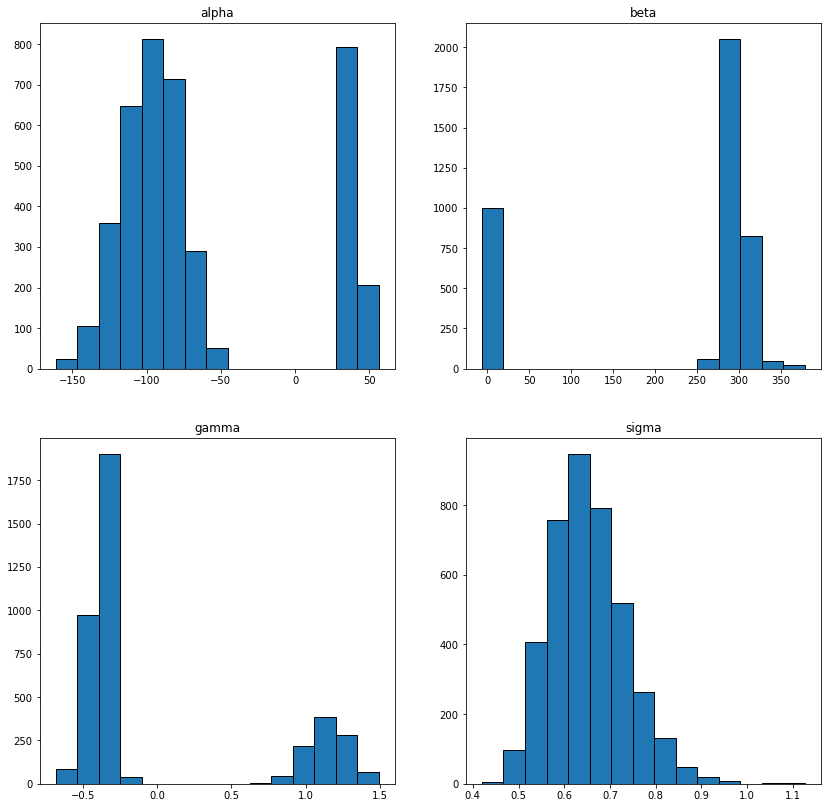

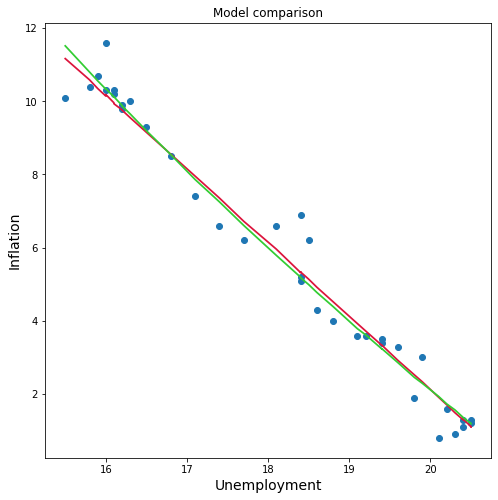

In [99]:
plot_results(country = country_list[0], fit1 = fit1, fit2 = fit2, fig_nr = 0, span = 36)

In [34]:
fit2.summary()

Mean    MCSE  StdDev       5%     50%     95%   N_Eff  N_Eff/s  \
name                                                                          
lp__        -4.50  0.0590   1.600   -7.600   -4.20   -2.60   740.0     23.0   
alpha      -98.00  0.7300  19.000 -130.000  -97.00  -69.00   670.0     21.0   
beta       300.00  0.4000  12.000  280.000  300.00  320.00   850.0     26.0   
gamma       -0.37  0.0029   0.069   -0.500   -0.36   -0.27   580.0     18.0   
sigma        0.66  0.0029   0.087    0.540    0.65    0.82   940.0     29.0   
y_gen[1]    12.00  0.0110   0.690   10.000   12.00   13.00  3895.0    120.0   
y_gen[2]    11.00  0.0120   0.710    9.700   11.00   12.00  3706.0    114.0   
y_gen[3]    11.00  0.0110   0.690    9.500   11.00   12.00  3752.0    116.0   
y_gen[4]    10.00  0.0110   0.680    9.300   10.00   12.00  3932.0    121.0   
y_gen[5]    10.00  0.0110   0.680    9.300   10.00   12.00  3885.0    120.0   
y_gen[6]    10.00  0.0110   0.710    9.000   10.00   11.00  3910.0    121.0   
y_gen[7]    10.00  0.0110   0.690    9.000   10.00   11.00  3838.0    118.0   
y_gen[8]     9.90  0.0110   0.670    8.800    9.90   11.00  3835.0    118.0   
y_gen[9]     9.90  0.0110   0.690    8.800    9.90   11.00  3693.0    114.0   
y_gen[10]    9.70  0.0110   0.680    8.500    9.70   11.00  3626.0    112.0   
y_gen[11]    9.20  0.0110   0.670    8.100    9.20   10.00  3892.0    120.0   
y_gen[12]    8.50  0.0110   0.670    7.400    8.50    9.70  3775.0    117.0   
y_gen[13]    7.80  0.0110   0.680    6.700    7.80    9.00  4040.0    125.0   
y_gen[14]    7.20  0.0110   0.680    6.100    7.20    8.30  3702.0    114.0   
y_gen[15]    6.50  0.0110   0.690    5.400    6.50    7.70  3949.0    122.0   
y_gen[16]    5.70  0.0110   0.680    4.600    5.70    6.90  4051.0    125.0   
y_gen[17]    5.20  0.0110   0.680    4.000    5.20    6.30  3859.0    119.0   
y_gen[18]    5.10  0.0110   0.670    4.000    5.10    6.30  4092.0    126.0   
y_gen[19]    5.10  0.0110   0.690    4.000    5.10    6.20  3791.0    117.0   
y_gen[20]    4.90  0.0110   0.670    3.800    4.90    6.00  3740.0    115.0   
y_gen[21]    4.70  0.0110   0.670    3.600    4.70    5.80  3762.0    116.0   
y_gen[22]    4.30  0.0110   0.680    3.200    4.30    5.50  3959.0    122.0   
y_gen[23]    3.80  0.0110   0.680    2.600    3.80    4.90  3828.0    118.0   
y_gen[24]    3.60  0.0110   0.670    2.500    3.60    4.60  3874.0    120.0   
y_gen[25]    3.20  0.0110   0.680    2.100    3.20    4.30  3501.0    108.0   
y_gen[26]    3.20  0.0110   0.680    2.000    3.20    4.30  3691.0    114.0   
y_gen[27]    2.80  0.0110   0.690    1.700    2.80    4.00  3847.0    119.0   
y_gen[28]    2.50  0.0110   0.680    1.300    2.50    3.60  3925.0    121.0   
y_gen[29]    2.30  0.0110   0.680    1.200    2.30    3.40  3954.0    122.0   
y_gen[30]    1.90  0.0110   0.680    0.810    1.90    3.00  3646.0    113.0   
y_gen[31]    1.80  0.0120   0.680    0.650    1.80    2.90  3499.0    108.0   
y_gen[32]    1.60  0.0110   0.690    0.450    1.60    2.70  3658.0    113.0   
y_gen[33]    1.40  0.0120   0.690    0.250    1.40    2.50  3500.0    108.0   
y_gen[34]    1.40  0.0110   0.680    0.300    1.40    2.60  3953.0    122.0   
y_gen[35]    1.30  0.0110   0.700    0.081    1.20    2.40  3795.0    117.0   
y_gen[36]    1.30  0.0110   0.690    0.100    1.30    2.40  3898.0    120.0   

           R_hat  
name              
lp__         1.0  
alpha        1.0  
beta         1.0  
gamma        1.0  
sigma        1.0  
y_gen[1]     1.0  
y_gen[2]     1.0  
y_gen[3]     1.0  
y_gen[4]     1.0  
y_gen[5]     1.0  
y_gen[6]     1.0  
y_gen[7]     1.0  
y_gen[8]     1.0  
y_gen[9]     1.0  
y_gen[10]    1.0  
y_gen[11]    1.0  
y_gen[12]    1.0  
y_gen[13]    1.0  
y_gen[14]    1.0  
y_gen[15]    1.0  
y_gen[16]    1.0  
y_gen[17]    1.0  
y_gen[18]    1.0  
y_gen[19]    1.0  
y_gen[20]    1.0  
y_gen[21]    1.0  
y_gen[22]    1.0  
y_gen[23]    1.0  
y_gen[24]    1.0  
y_gen[25]    1.0  
y_gen[2

chain 1 |          | 00:00 Status





chain 1 |█▊        | 00:00 Iteration:  100 / 1500 [  6%]  (Warmup)


chain 1 |█████▎    | 00:00 Iteration:  600 / 1500 [ 40%]  (Sampling)



chain 1 |███████▋  | 00:00 Iteration: 1000 / 1500 [ 66%]  (Sampling)

chain 1 |██████████| 00:00 Iteration: 1400 / 1500 [ 93%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

chain 1 |          | 00:00 Status




chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  100 / 1500 [  6%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  200 / 1500 [ 13%]  (Warmup)


chain 1 |██▉       | 00:01 Iteration:  300 / 1500 [ 20%]  (Warmup)


chain 1 |███▌      | 00:01 Iteration:  400 / 1500 [ 26%]  (Warmup)


chain 1 |████▋     | 00:01 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |█████▎    | 00:02 Iteration:  600 / 1500 [ 40%]  (Sampling)


chain 1 |█████▉    | 00:02 Iteration:  700 / 1500 [ 46%]  (Sampling)


chain 1 |██████▍   | 00:02 Iteration:  800 / 1500 [ 53%]  (Sampling)


chain 1 |███████   | 00:02 Iteration:  900 / 1500 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:03 Iteration: 1000 / 1500 [ 66%]  (Sampling)


chain 1 |████████▏ | 00:03 Iteration: 1100 / 1500 [ 73%]  (Sampling)


chain 1 |████████▊ | 00:03 Iteration: 1200 / 1500 [ 80%]  (Sampling)




chain 1 |█████████▍| 00:04 Iteration: 1300 / 15

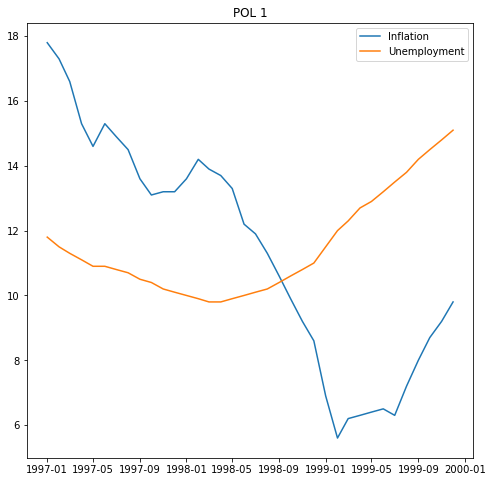

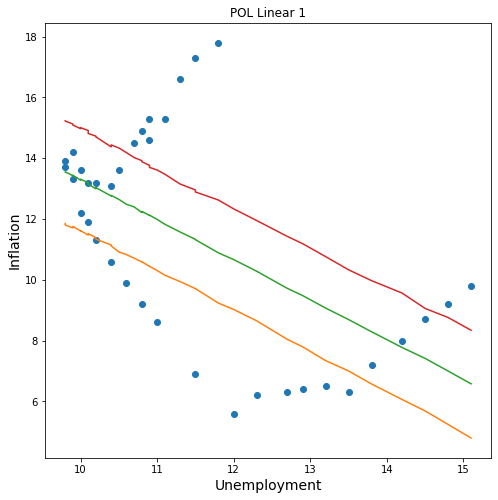

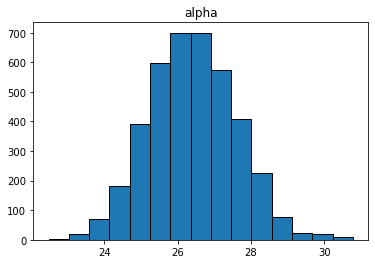

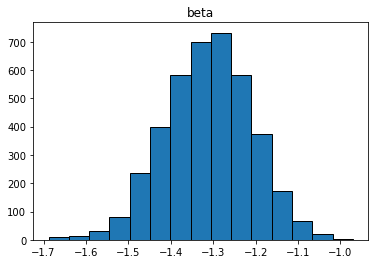

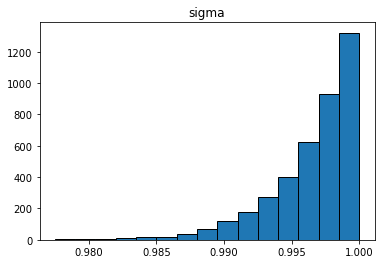

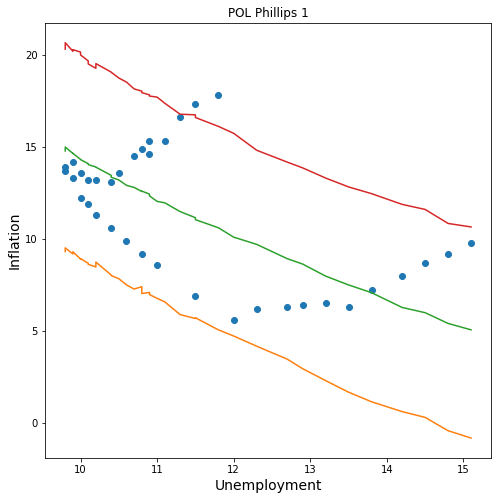

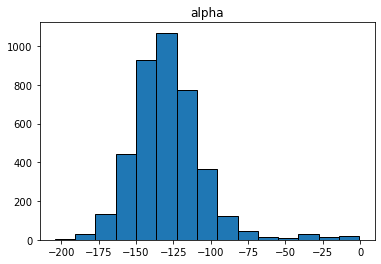

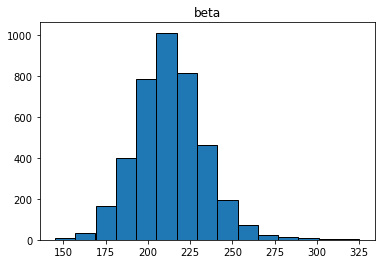

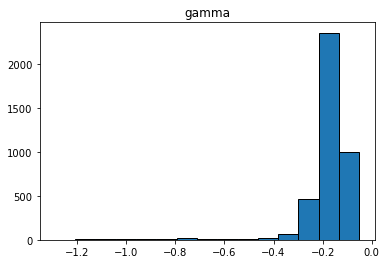

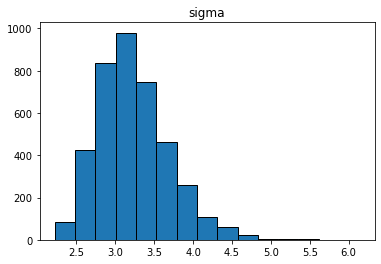

chain 1 |          | 00:00 Status




chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)


chain 1 |███▌      | 00:00 Iteration:  400 / 1500 [ 26%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration:  700 / 1500 [ 46%]  (Sampling)
chain 1 |███████▋  | 00:00 Iteration: 1000 / 1500 [ 66%]  (Sampling)


chain 1 |█████████▍| 00:00 Iteration: 1300 / 1500 [ 86%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

chain 1 |          | 00:00 Status


chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)





chain 1 |█▊        | 00:01 Iteration:  100 / 1500 [  6%]  (Warmup)


chain 1 |██▉       | 00:02 Iteration:  300 / 1500 [ 20%]  (Warmup)


chain 1 |███▌      | 00:03 Iteration:  400 / 1500 [ 26%]  (Warmup)




chain 1 |████▋     | 00:04 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |█████▎    | 00:05 Iteration:  600 / 1500 [ 40%]  (Sampling)


chain 1 |█████▉    | 00:06 Iteration:  700 / 1500 [ 46%]  (Sampling)


chain 1 |██████▍   | 00:07 Iteration:  800 / 1500 [ 53%]  (Sampling)


chain 1 |███████   | 00:08 Iteration:  900 / 1500 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:09 Iteration: 1000 / 1500 [ 66%]  (Sampling)


chain 1 |████████▏ | 00:10 Iteration: 1100 / 1500 [ 73%]  (Sampling)


chain 1 |████████▊ | 00:11 Iteration: 1200 / 1500 [ 80%]  (Sampling)


chain 1 |█████████▍| 00:12 Iteration: 1300 / 1500 [ 86%]  (Sampling)


chain 1 |██████████| 00:13 Iteration: 1400 /

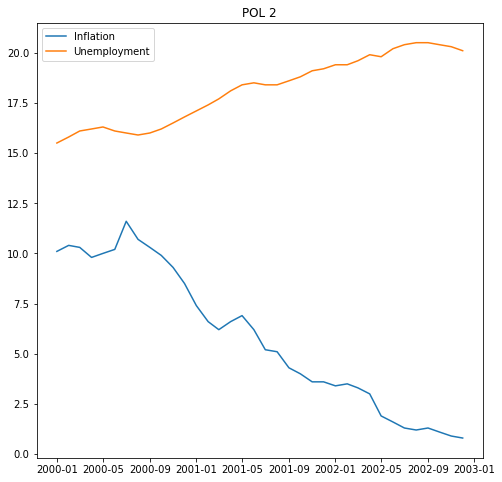

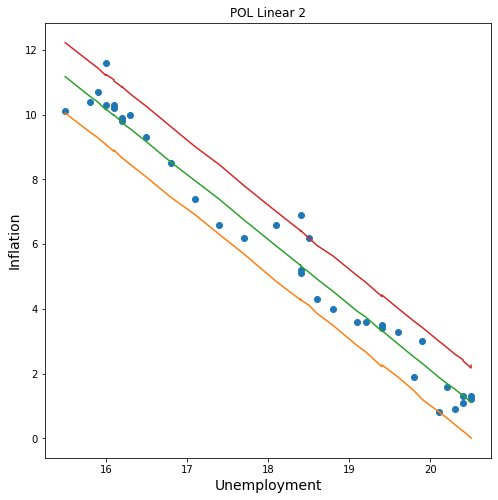

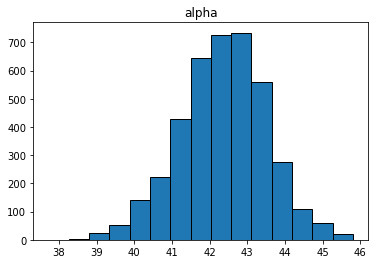

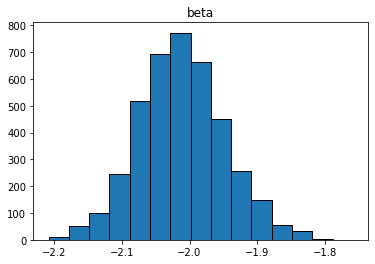

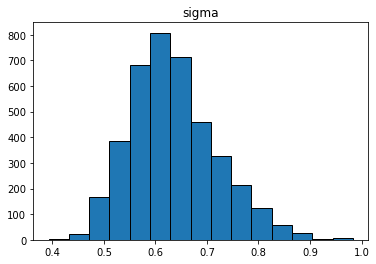

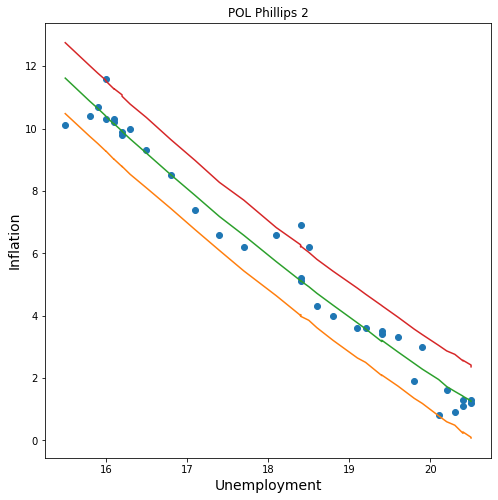

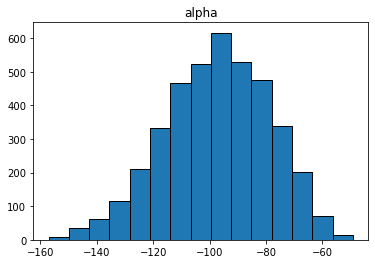

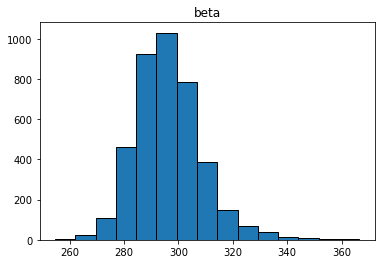

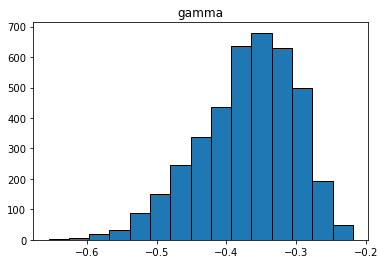

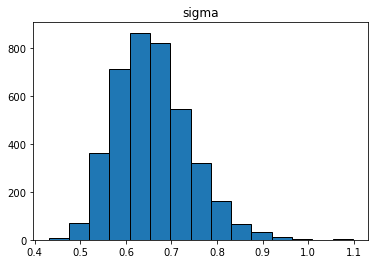

chain 1 |          | 00:00 Status





chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)


chain 1 |██▉       | 00:00 Iteration:  300 / 1500 [ 20%]  (Warmup)


chain 1 |█████▎    | 00:00 Iteration:  600 / 1500 [ 40%]  (Sampling)
chain 1 |███████   | 00:00 Iteration:  900 / 1500 [ 60%]  (Sampling)




chain 1 |████████▊ | 00:00 Iteration: 1200 / 1500 [ 80%]  (Sampling)



chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       

chain 1 |          | 00:00 Status


chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)

chain 1 |█▊        | 00:00 Iteration:  100 / 1500 [  6%]  (Warmup)
chain 1 |██▎       | 00:01 Iteration:  200 / 1500 [ 13%]  (Warmup)




chain 1 |██▉       | 00:02 Iteration:  300 / 1500 [ 20%]  (Warmup)



chain 1 |███▌      | 00:02 Iteration:  400 / 1500 [ 26%]  (Warmup)





chain 1 |████▋     | 00:04 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |█████▎    | 00:05 Iteration:  600 / 1500 [ 40%]  (Sampling)



chain 1 |█████▉    | 00:06 Iteration:  700 / 1500 [ 46%]  (Sampling)



chain 1 |██████▍   | 00:07 Iteration:  800 / 1500 [ 53%]  (Sampling)



chain 1 |███████   | 00:09 Iteration:  900 / 1500 [ 60%]  (Sampling)



chain 1 |███████▋  | 00:10 Iteration: 1000 / 1500 [ 66%]  (Sampling)

chain 1 |████████▏ | 00:11 Iteration: 1100 / 1500 [ 73%]  (Sampling)

chain 1 |████████▊ | 00:12 Iteration: 1200 / 1500 [ 80%]  (Sampling)

chain 1 |█████████▍| 00:13 Iteration: 1300 / 15

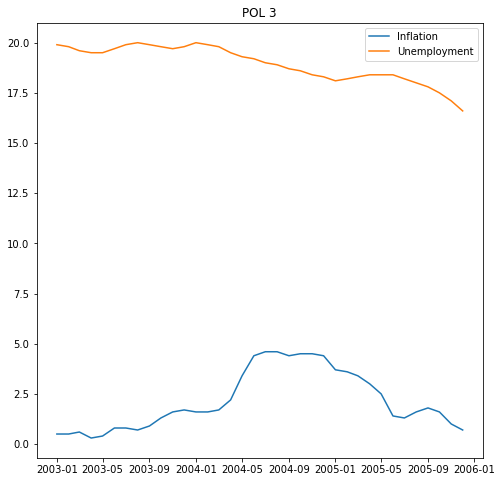

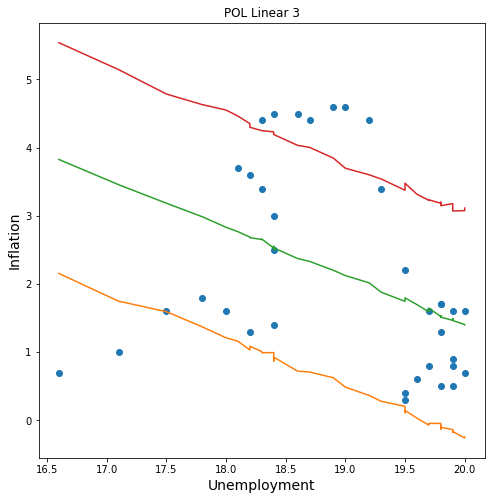

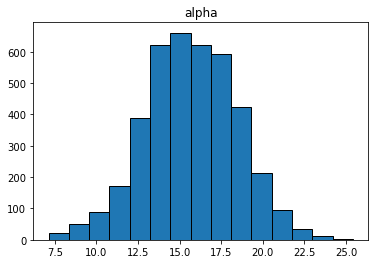

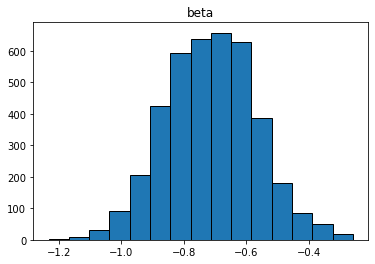

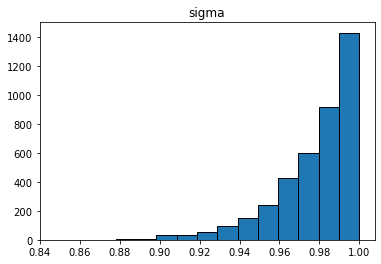

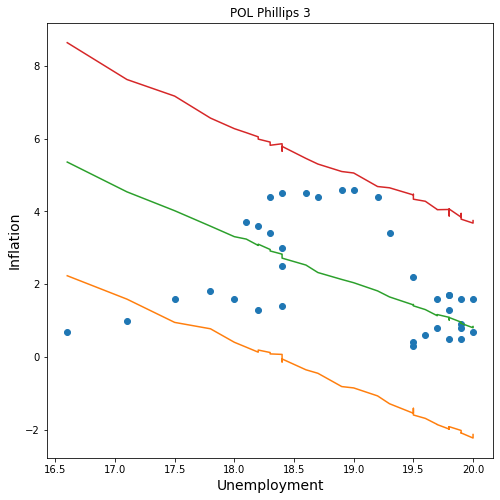

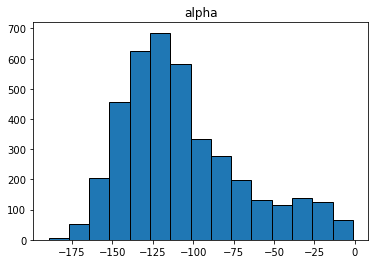

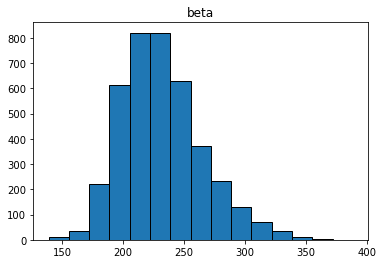

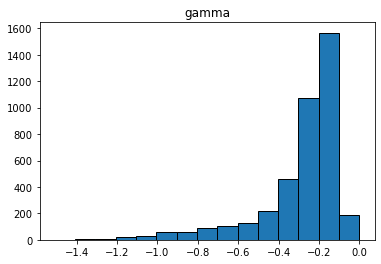

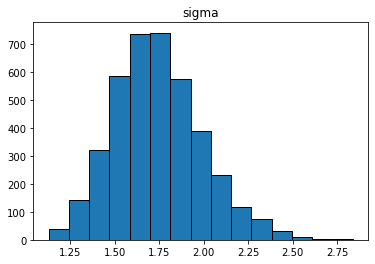

chain 1 |          | 00:00 Status


chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration:  700 / 1500 [ 46%]  (Sampling)


chain 1 |████████▊ | 00:00 Iteration: 1200 / 1500 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

chain 1 |          | 00:00 Status








chain 1 |█▏        | 00:01 Iteration:    1 / 1500 [  0%]  (Warmup)














chain 1 |██████████| 00:11 Sampling completed                       
chain 2 |██████████| 00:11 Sampling completed                       
chain 3 |██████████| 00:11 Sampling completed                       
chain 4 |██████████| 00:11 Sampling completed                       

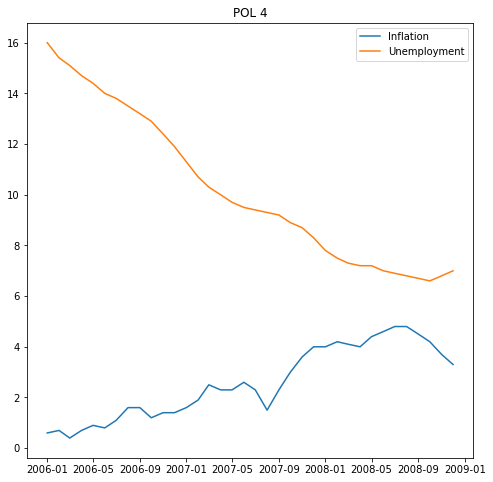

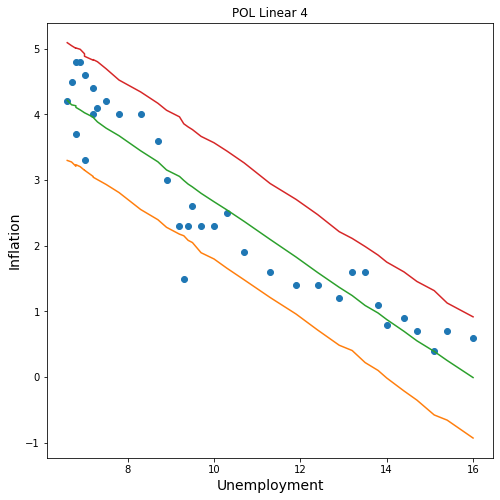

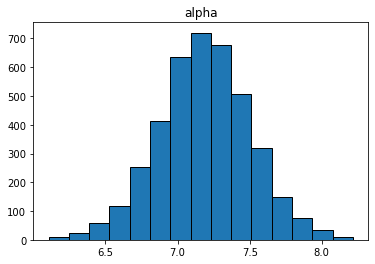

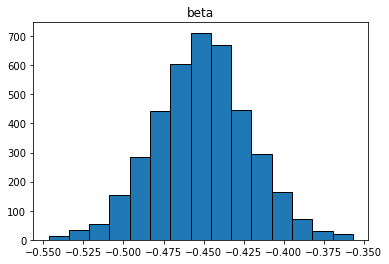

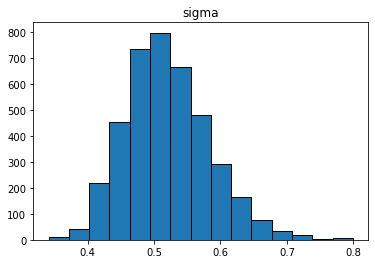

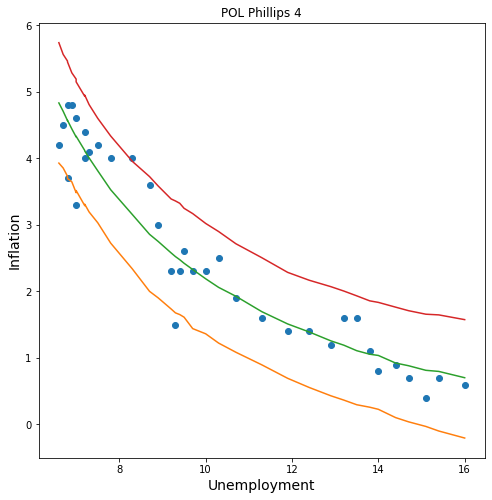

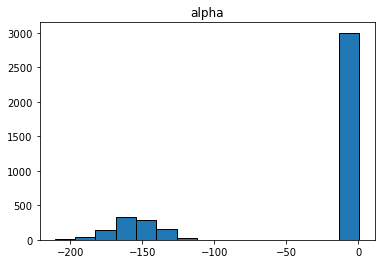

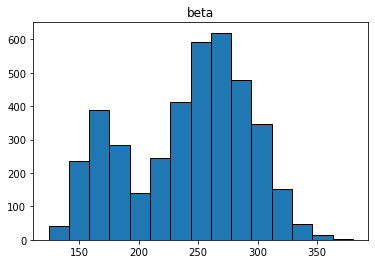

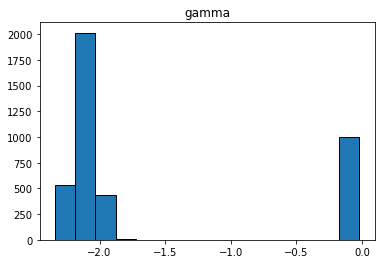

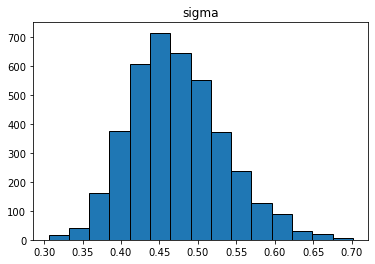

             Mean     MCSE  StdDev       5%      50%      95%   N_Eff  \
name                                                                    
lp__       -13.00   4.1000   5.900  -19.000  -16.000   -2.000     2.1   
alpha      -39.00  48.0000  68.000 -170.000   -0.033    0.350     2.0   
beta       240.00  31.0000  51.000  150.000  250.000  310.000     2.8   
gamma       -1.60   0.6400   0.900   -2.200   -2.100   -0.027     2.0   
sigma        0.47   0.0051   0.061    0.380    0.470    0.580   140.0   
y_gen[1]     4.80   0.1600   0.550    3.900    4.800    5.700    12.0   
y_gen[2]     4.70   0.1300   0.530    3.900    4.700    5.600    16.0   
y_gen[3]     4.60   0.1200   0.530    3.700    4.600    5.500    19.0   
y_gen[4]     4.60   0.1300   0.530    3.700    4.600    5.400    17.0   
y_gen[5]     4.50   0.0810   0.510    3.600    4.400    5.300    40.0   
y_gen[6]     4.30   0.0660   0.510    3.500    4.300    5.200    61.0   
y_gen[7]     4.30   0.0430   0.500    3.500    4.30

chain 1 |          | 00:00 Status


chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)


chain 1 |███▌      | 00:00 Iteration:  400 / 1500 [ 26%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration:  700 / 1500 [ 46%]  (Sampling)


chain 1 |███████▋  | 00:00 Iteration: 1000 / 1500 [ 66%]  (Sampling)


chain 1 |█████████▍| 00:00 Iteration: 1300 / 1500 [ 86%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

chain 1 |          | 00:00 Status






chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)
chain 1 |█▊        | 00:00 Iteration:  100 / 1500 [  6%]  (Warmup)
chain 1 |███▌      | 00:00 Iteration:  400 / 1500 [ 26%]  (Warmup)
chain 1 |█████▉    | 00:00 Iteration:  700 / 1500 [ 46%]  (Sampling)
chain 1 |██████████| 00:01 Iteration: 1400 / 1500 [ 93%]  (Sampling)



























chain 1 |██████████| 00:08 Sampling completed                       
chain 2 |██████████| 00:08 Sampling completed                       

chain 3 |██████████| 00:08 Sampling completed
chain 4 |██████████| 00:08 Sampling completed                       

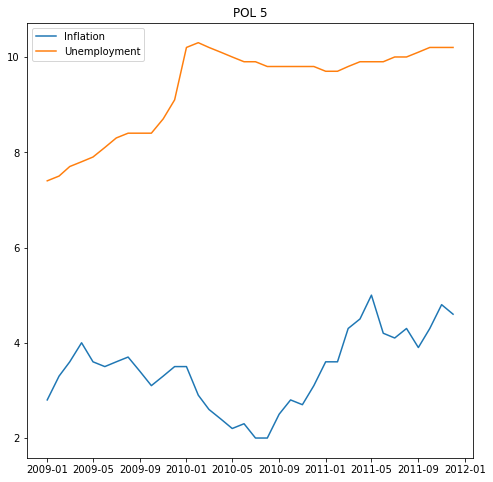

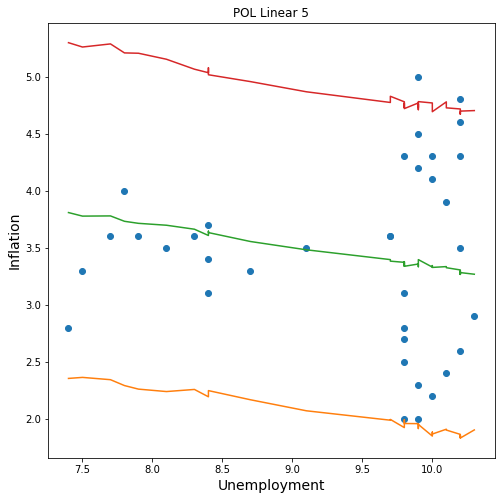

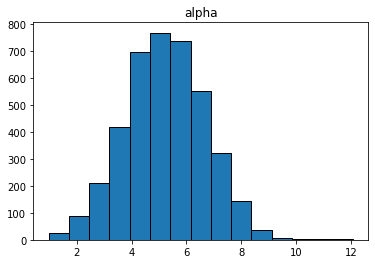

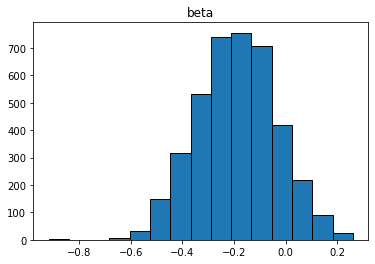

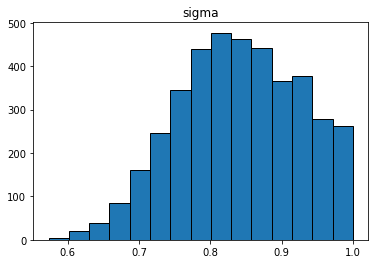

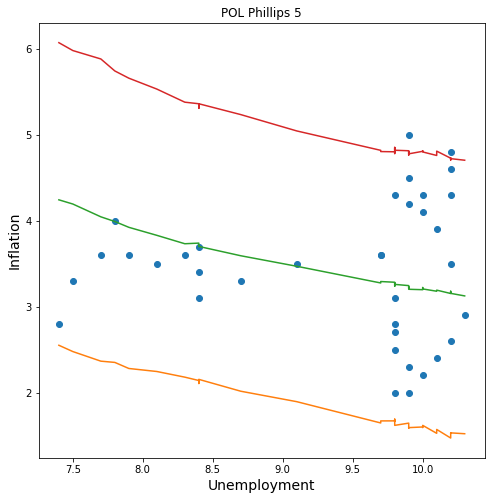

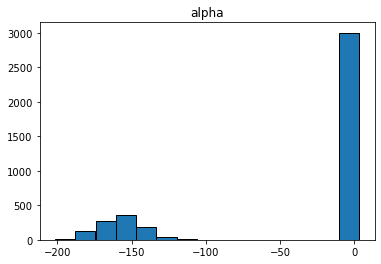

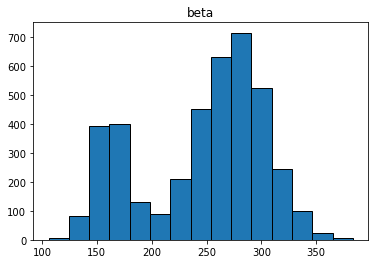

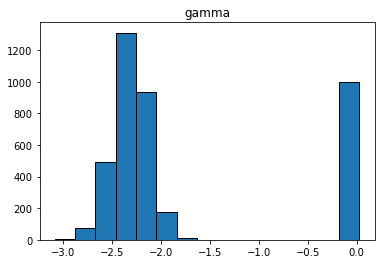

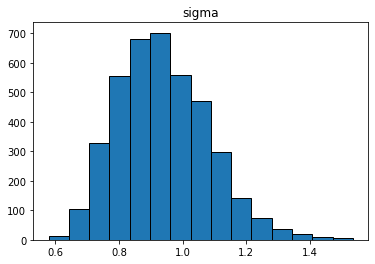

             Mean    MCSE  StdDev      5%     50%       95%   N_Eff  N_Eff/s  \
name                                                                           
lp__       -40.00   5.300    7.60  -46.00  -43.00  -25.0000     2.1     0.30   
alpha      -38.00  49.000   70.00 -170.00    1.50    2.6000     2.0     0.30   
beta       250.00  35.000   56.00  150.00  260.00  320.0000     2.5     0.37   
gamma       -1.70   0.710    1.00   -2.60   -2.20    0.0037     2.0     0.30   
sigma        0.94   0.039    0.14    0.73    0.93    1.2000    14.0     2.00   
y_gen[1]     4.30   0.310    1.10    2.60    4.20    6.1000    12.0     1.70   
y_gen[2]     4.20   0.280    1.10    2.50    4.20    6.0000    14.0     2.10   
y_gen[3]     4.10   0.240    1.10    2.40    4.00    5.9000    20.0     2.90   
y_gen[4]     4.00   0.220    1.10    2.30    4.00    5.7000    24.0     3.50   
y_gen[5]     3.90   0.190    1.00    2.30    3.90    5.7000    28.0     4.10   
y_gen[6]     3.80   0.120    1.00    2.2

chain 1 |          | 00:00 Status


chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)


chain 1 |██▉       | 00:00 Iteration:  300 / 1500 [ 20%]  (Warmup)


chain 1 |█████▎    | 00:00 Iteration:  600 / 1500 [ 40%]  (Sampling)


chain 1 |███████   | 00:00 Iteration:  900 / 1500 [ 60%]  (Sampling)


chain 1 |████████▊ | 00:00 Iteration: 1200 / 1500 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

chain 1 |          | 00:00 Status








chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)






chain 1 |█▊        | 00:01 Iteration:  100 / 1500 [  6%]  (Warmup)
chain 1 |██▎       | 00:02 Iteration:  200 / 1500 [ 13%]  (Warmup)
chain 1 |██▉       | 00:02 Iteration:  300 / 1500 [ 20%]  (Warmup)
chain 1 |███▌      | 00:02 Iteration:  400 / 1500 [ 26%]  (Warmup)
chain 1 |████▋     | 00:03 Iteration:  501 / 1500 [ 33%]  (Sampling)
chain 1 |█████▎    | 00:03 Iteration:  600 / 1500 [ 40%]  (Sampling)
chain 1 |█████▉    | 00:04 Iteration:  700 / 1500 [ 46%]  (Sampling)
chain 1 |██████▍   | 00:04 Iteration:  800 / 1500 [ 53%]  (Sampling)
chain 1 |███████   | 00:05 Iteration:  900 / 1500 [ 60%]  (Sampling)
chain 1 |███████▋  | 00:05 Iteration: 1000 / 1500 [ 66%]  (Sampling)
chain 1 |████████▊ | 00:06 Iteration: 1200 / 1500 [ 80%]  (Sampling)
chain 1 |█████████▍| 00:06 Iteration: 1300 / 1500 [ 86%]  (Sampling)
chain 1 |██████████| 00:07 Iteration: 1400 / 1500 [ 93%]  (Sampli

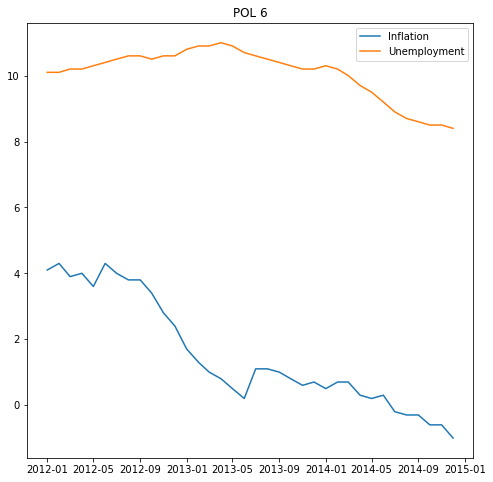

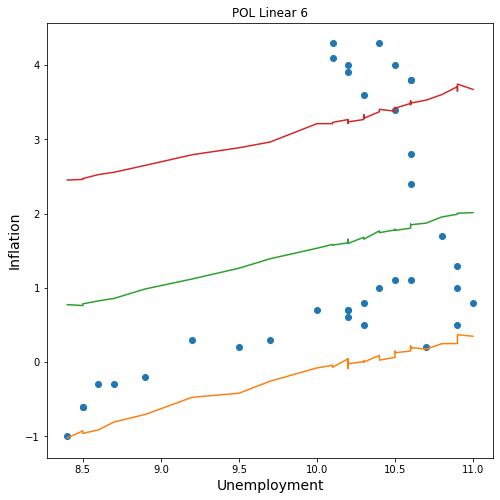

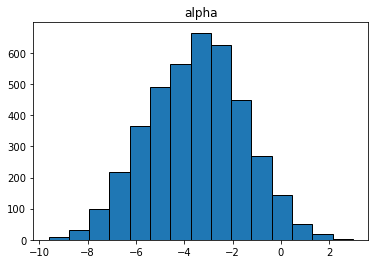

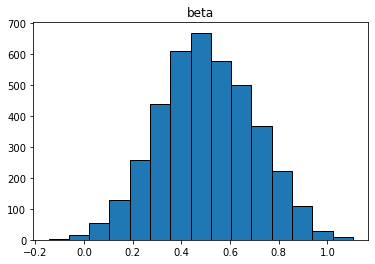

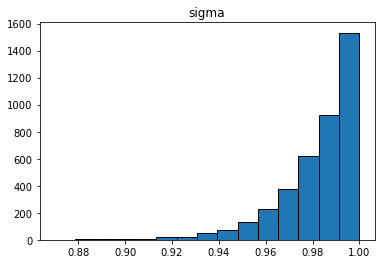

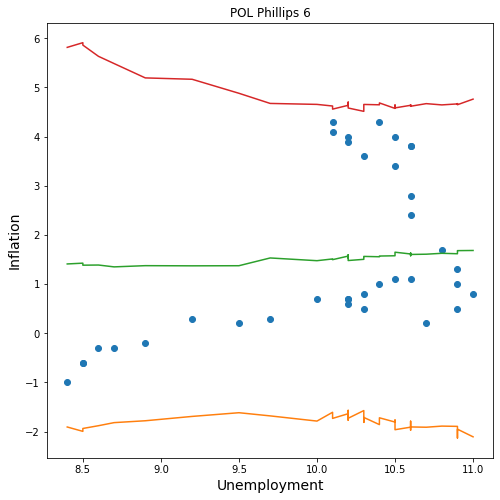

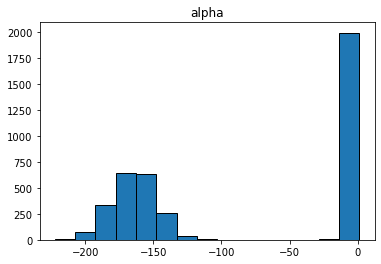

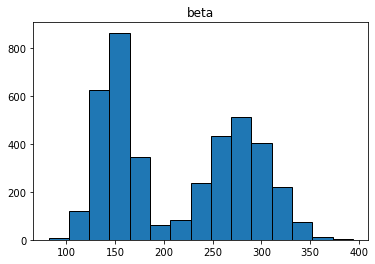

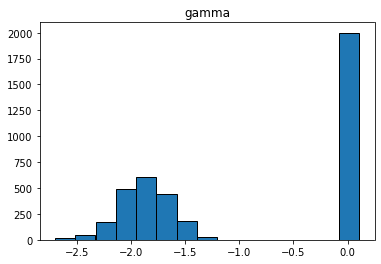

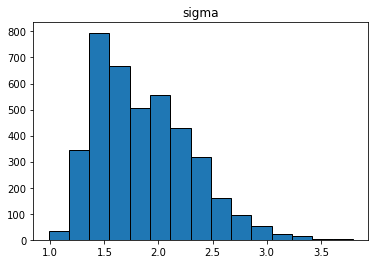

             Mean    MCSE  StdDev     5%      50%      95%   N_Eff  N_Eff/s  \
name                                                                          
lp__       -58.00   5.500    7.90  -68.0  -59.000  -49.000     2.1     0.20   
alpha      -84.00  57.000   82.00 -190.0  -15.000   -0.440     2.0     0.19   
beta       210.00  46.000   69.00  130.0  200.000  320.000     2.2     0.21   
gamma       -0.91   0.680    0.97   -2.2   -0.035    0.071     2.1     0.20   
sigma        1.90   0.240    0.44    1.3    1.800    2.700     3.2     0.31   
y_gen[1]     1.60   1.000    2.40   -1.9    1.400    5.800     5.8     0.55   
y_gen[2]     1.60   0.960    2.40   -2.0    1.400    5.900     6.3     0.59   
y_gen[3]     1.60   0.990    2.40   -1.9    1.400    5.900     5.9     0.56   
y_gen[4]     1.60   0.840    2.30   -1.9    1.400    5.600     7.6     0.72   
y_gen[5]     1.50   0.820    2.20   -1.8    1.400    5.500     7.3     0.70   
y_gen[6]     1.50   0.660    2.10   -1.8    1.400   

chain 1 |          | 00:00 Status





chain 1 |█▊        | 00:00 Iteration:  100 / 1500 [  6%]  (Warmup)


chain 1 |█████▎    | 00:00 Iteration:  600 / 1500 [ 40%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

chain 1 |          | 00:00 Status








chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)



chain 1 |█▊        | 00:01 Iteration:  100 / 1500 [  6%]  (Warmup)

chain 1 |██▎       | 00:02 Iteration:  200 / 1500 [ 13%]  (Warmup)

chain 1 |██▉       | 00:03 Iteration:  300 / 1500 [ 20%]  (Warmup)

chain 1 |███▌      | 00:03 Iteration:  400 / 1500 [ 26%]  (Warmup)

chain 1 |████▋     | 00:04 Iteration:  501 / 1500 [ 33%]  (Sampling)

chain 1 |█████▎    | 00:05 Iteration:  600 / 1500 [ 40%]  (Sampling)

chain 1 |█████▉    | 00:06 Iteration:  700 / 1500 [ 46%]  (Sampling)

chain 1 |██████▍   | 00:07 Iteration:  800 / 1500 [ 53%]  (Sampling)

chain 1 |███████   | 00:08 Iteration:  900 / 1500 [ 60%]  (Sampling)

chain 1 |███████▋  | 00:09 Iteration: 1000 / 1500 [ 66%]  (Sampling)

chain 1 |████████▏ | 00:09 Iteration: 1100 / 1500 [ 73%]  (Sampling)

chain 1 |████████▊ | 00:10 Iteration: 1200 / 1500 [ 80%]  (Sampling)

chain 1 |█████████▍| 00:11 Iteration: 1300 / 1500 [ 86%]

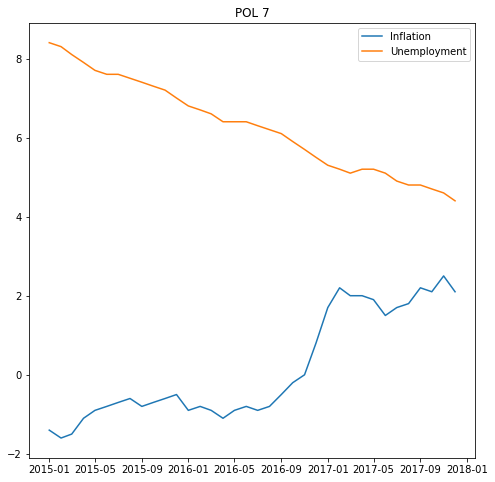

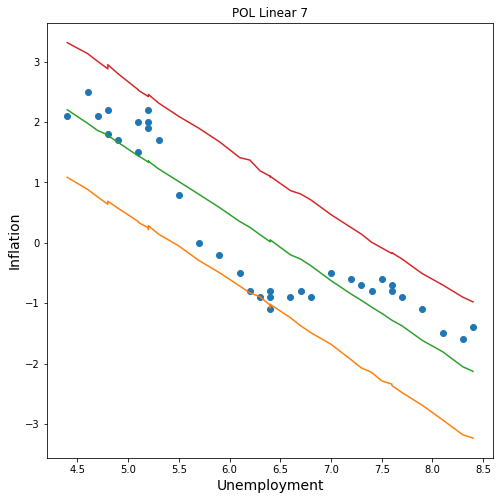

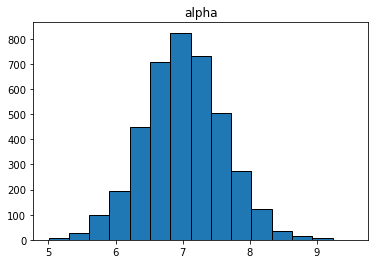

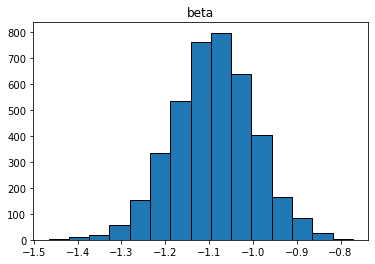

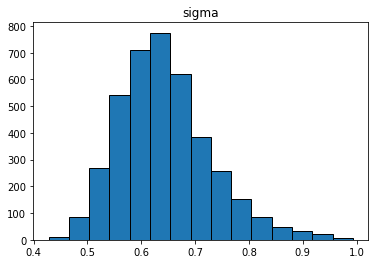

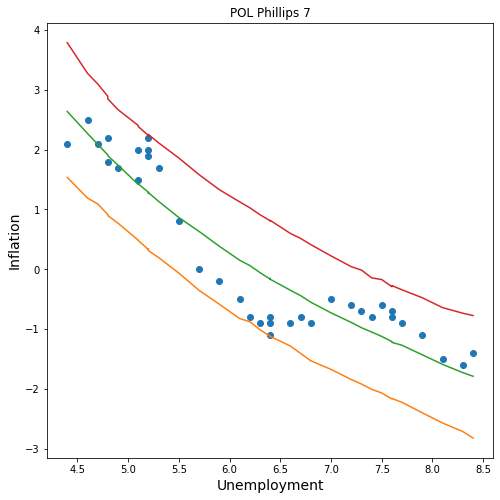

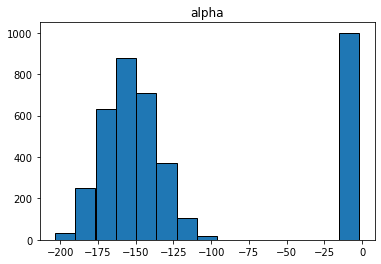

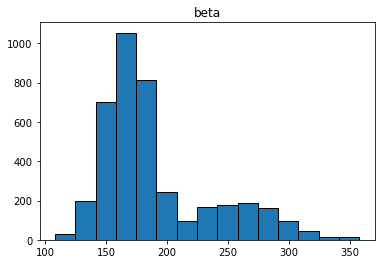

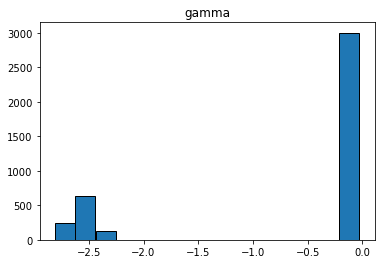

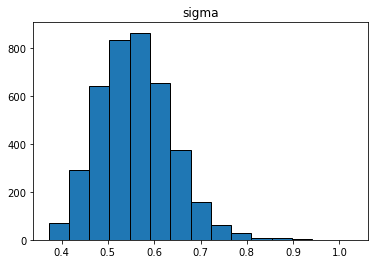

              Mean     MCSE  StdDev       5%      50%      95%   N_Eff  \
name                                                                     
lp__       -15.000   3.7000   5.400  -25.000  -12.000  -10.000     2.1   
alpha     -120.000  46.0000  67.000 -180.000 -150.000   -2.400     2.1   
beta       190.000  29.0000  46.000  140.000  170.000  290.000     2.5   
gamma       -0.670   0.7700   1.100   -2.600   -0.046   -0.036     2.0   
sigma        0.560   0.0230   0.079    0.440    0.550    0.690    12.0   
y_gen[1]     2.600   0.2700   0.690    1.500    2.600    3.800     6.5   
y_gen[2]     2.300   0.1500   0.640    1.200    2.300    3.300    17.0   
y_gen[3]     2.100   0.1000   0.610    1.100    2.100    3.100    34.0   
y_gen[4]     1.900   0.0580   0.600    0.920    1.900    2.900   108.0   
y_gen[5]     1.900   0.0360   0.600    0.900    1.900    2.800   277.0   
y_gen[6]     1.700   0.0110   0.590    0.770    1.700    2.700  2653.0   
y_gen[7]     1.400   0.0092   0.580   

chain 1 |          | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  100 / 1500 [  6%]  (Warmup)



chain 1 |████▋     | 00:00 Iteration:  501 / 1500 [ 33%]  (Sampling)



chain 1 |███████   | 00:00 Iteration:  900 / 1500 [ 60%]  (Sampling)

chain 1 |█████████▍| 00:00 Iteration: 1300 / 1500 [ 86%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

chain 1 |          | 00:00 Status




chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  100 / 1500 [  6%]  (Warmup)
chain 1 |██▎       | 00:02 Iteration:  200 / 1500 [ 13%]  (Warmup)


chain 1 |██▉       | 00:03 Iteration:  300 / 1500 [ 20%]  (Warmup)


chain 1 |███▌      | 00:03 Iteration:  400 / 1500 [ 26%]  (Warmup)


chain 1 |████▋     | 00:04 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |█████▎    | 00:05 Iteration:  600 / 1500 [ 40%]  (Sampling)


chain 1 |█████▉    | 00:06 Iteration:  700 / 1500 [ 46%]  (Sampling)


chain 1 |██████▍   | 00:07 Iteration:  800 / 1500 [ 53%]  (Sampling)
chain 1 |███████   | 00:08 Iteration:  900 / 1500 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:09 Iteration: 1000 / 1500 [ 66%]  (Sampling)

chain 1 |████████▏ | 00:10 Iteration: 1100 / 1500 [ 73%]  (Sampling)


chain 1 |████████▊ | 00:12 Iteration: 1200 / 1500 [ 80%]  (Sampling)


chain 1 |█████████▍| 00:13 Iteration: 1300 / 1500 [ 86

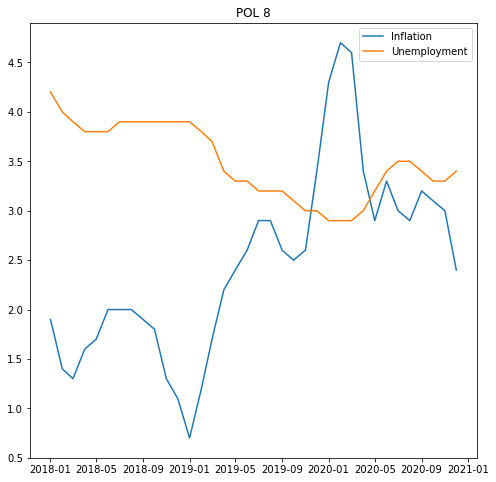

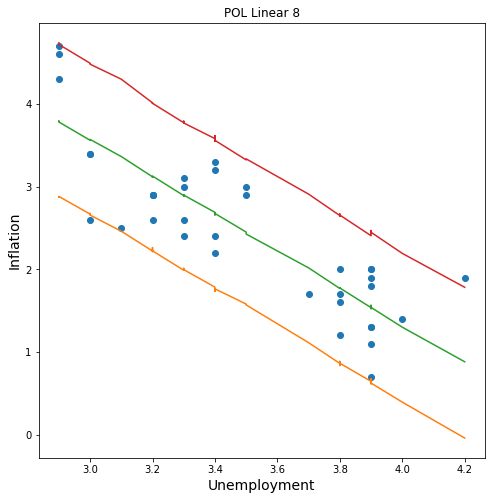

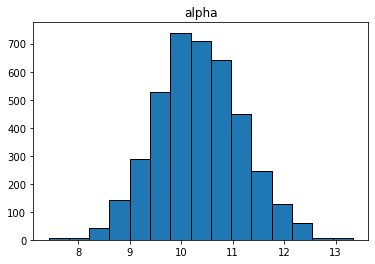

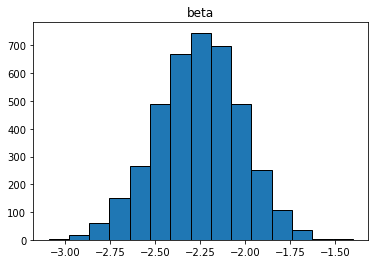

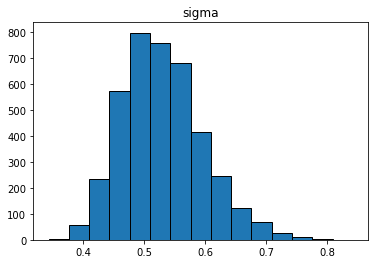

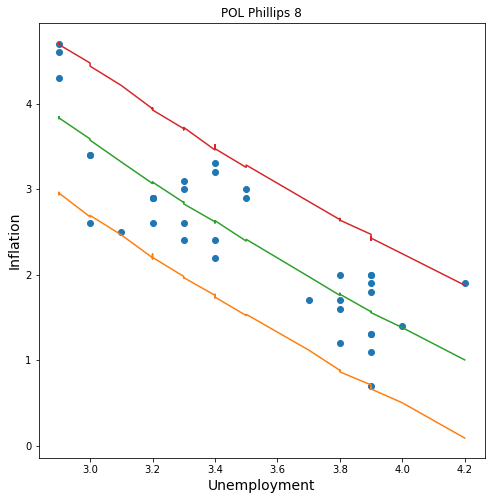

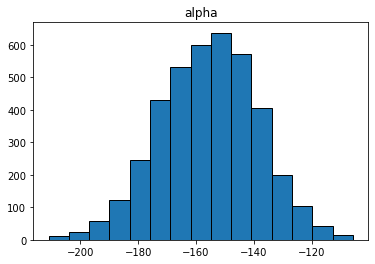

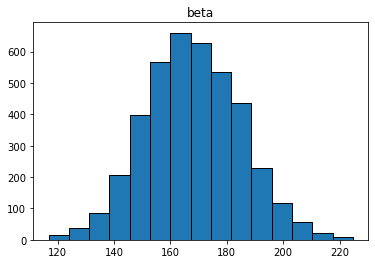

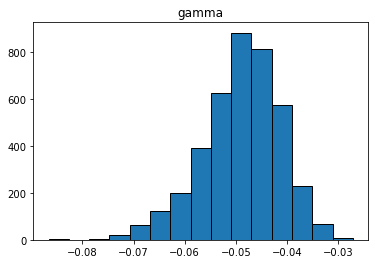

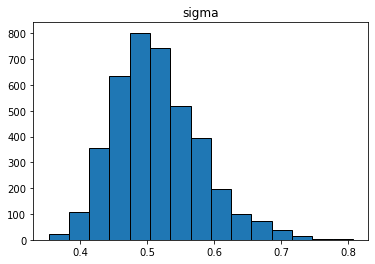

In [320]:
country = country_list[0]
for i in range(int(len(country[0])/36)):
    span_start_idx = i*36
    create_two_plots(country=country, span_start_idx=span_start_idx, model1=model_linear, model2=model_phillips, fig_nr=i)

In [64]:
all_countries = concatenate_all_data(country_list=country_list)

In [65]:
len(all_countries[1])

5080

In [90]:
country = all_countries
span_start_idx = 0
span = len(all_countries[1])
fit1, fit2 = sample_models_all_data(country=country, span=span, span_start_idx=span_start_idx, model1=model_linear, model2=model_phillips)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  200 / 1500 [ 13%]  (Warmup)

chain 1 |██▉       | 00:01 Iteration:  300 / 1500 [ 20%]  (Warmup)
chain 1 |███▌      | 00:01 Iteration:  400 / 1500 [ 26%]  (Warmup)








chain 1 |████▋     | 00:02 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |█████▎    | 00:03 Iteration:  600 / 1500 [ 40%]  (Sampling)


chain 1 |█████▉    | 00:04 Iteration:  700 / 1500 [ 46%]  (Sampling)


chain 1 |██████▍   | 00:05 Iteration:  800 / 1500 [ 53%]  (Sampling)


chain 1 |███████   | 00:06 Iteration:  900 / 1500 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:07 Iteration: 1000 / 1500 [ 66%]  (Sampling)


chain 1 |████████▏ | 00:08 Iteration: 1100 / 1500 [ 73%]  (Sampling)


chain 1 |████████▊ | 00:09 Iteration: 1200 / 1500 [ 80%]  (Sampling)


chain 1 |█████████▍| 00:10 Iteration: 1300 / 1500 [ 86%]  (Sampling)


chain 


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status








chain 1 |█▏        | 00:03 Iteration:    1 / 1500 [  0%]  (Warmup)


chain 1 |█▊        | 00:04 Iteration:  100 / 1500 [  6%]  (Warmup)


chain 1 |██▎       | 00:05 Iteration:  200 / 1500 [ 13%]  (Warmup)


chain 1 |███▌      | 00:07 Iteration:  400 / 1500 [ 26%]  (Warmup)


chain 1 |████▋     | 00:08 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |█████▎    | 00:10 Iteration:  600 / 1500 [ 40%]  (Sampling)


chain 1 |█████▉    | 00:12 Iteration:  700 / 1500 [ 46%]  (Sampling)




chain 1 |██████▍   | 00:16 Iteration:  800 / 1500 [ 53%]  (Sampling)


chain 1 |███████   | 00:17 Iteration:  900 / 1500 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:19 Iteration: 1000 / 1500 [ 66%]  (Sampling)



chain 1 |████████▏ | 00:23 Iteration: 1100 / 1500 [ 73%]  (Sampling)


chain 1 |████████▊ | 00:25 Iteration: 1200 / 1500 [ 80%]  (Sampling)


chain 1 |██████████| 00:29 Sampling completed                       
ch


INFO:cmdstanpy:CmdStan done processing.


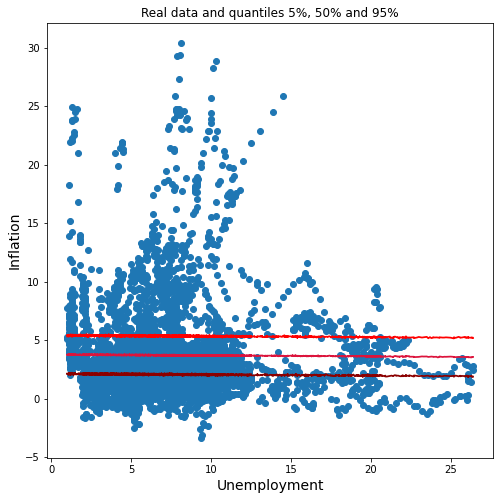

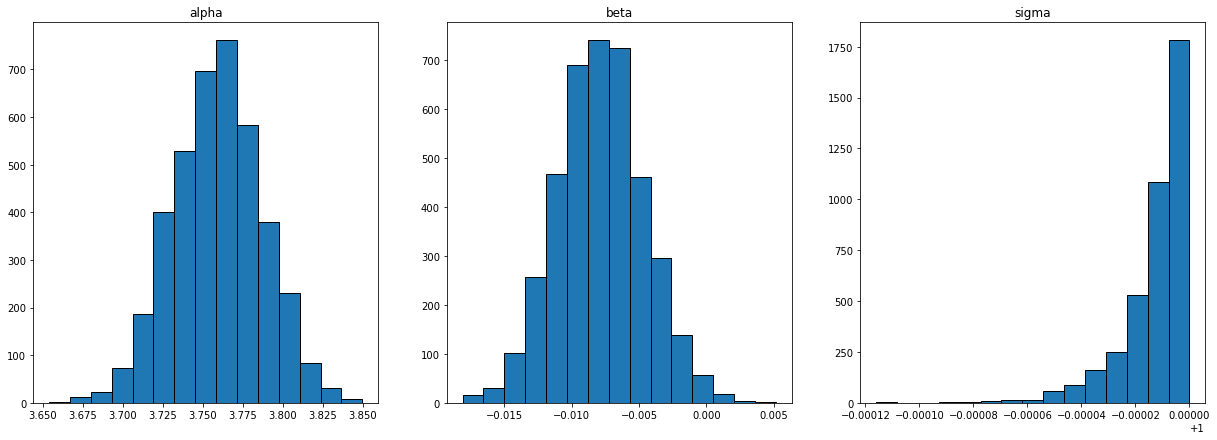

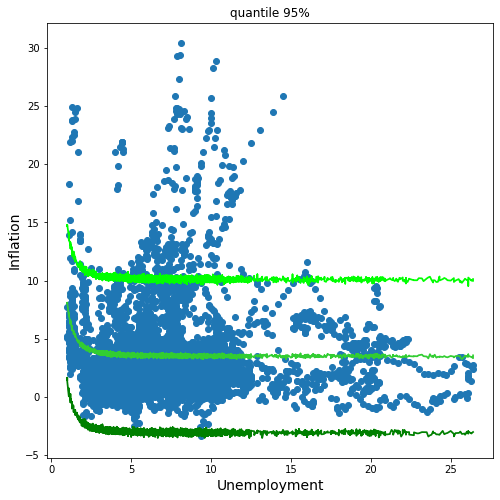

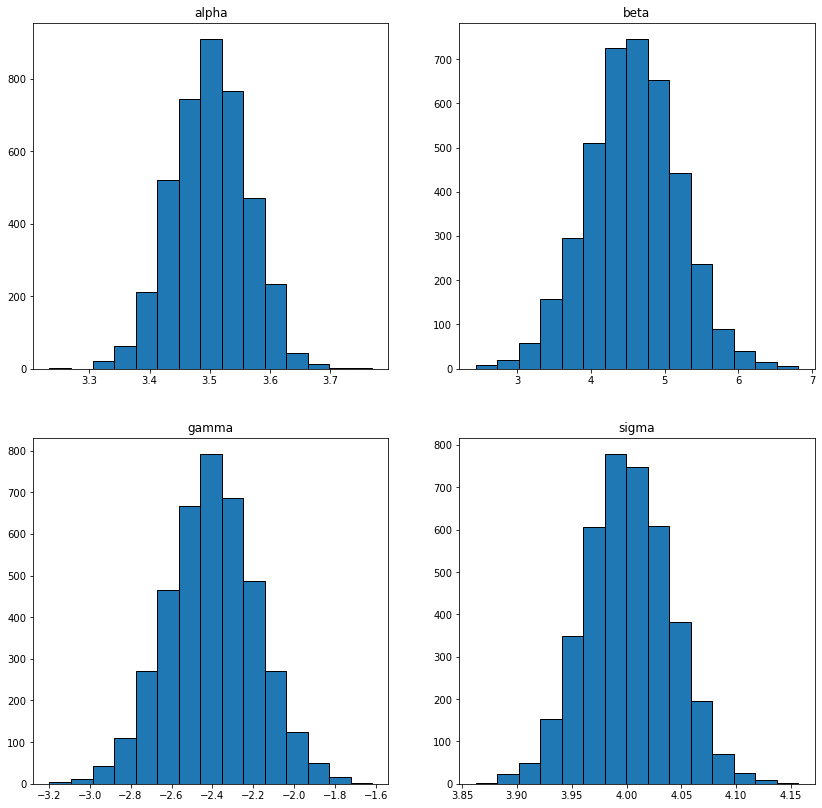

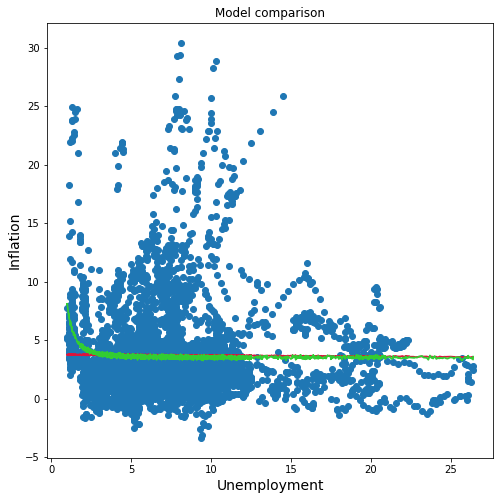

In [91]:
plot_results_all_data(country = all_countries, fit1 = fit1, fit2 = fit2, fig_nr = 0, span=span)

In [107]:
stan_file_gen_quant = r"C:\Studia\Data-Analytics\Projekt-Proper\generated_quantities.stan"
gen_quant = CmdStanModel(stan_file=stan_file_gen_quant)

INFO:cmdstanpy:found newer exe file, not recompiling


In [110]:
data = {
"N": 2000,
"x": np.linspace(0, 30, 2000)
}

fit1 = gen_quant.sample(data = data, iter_sampling = 1000, iter_warmup=500)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▌         | 00:00 Status
chain 1 |█▏        | 00:00 Iteration:   1 / 1000 [  0%]  (Sampling)



chain 1 |█▊        | 00:01 Iteration: 100 / 1000 [ 10%]  (Sampling)


chain 1 |██▎       | 00:01 Iteration: 200 / 1000 [ 20%]  (Sampling)


chain 1 |██▉       | 00:02 Iteration: 300 / 1000 [ 30%]  (Sampling)


chain 1 |███▌      | 00:03 Iteration: 400 / 1000 [ 40%]  (Sampling)


chain 1 |████      | 00:03 Iteration: 500 / 1000 [ 50%]  (Sampling)


chain 1 |████▋     | 00:04 Iteration: 600 / 1000 [ 60%]  (Sampling)


chain 1 |█████▎    | 00:04 Iteration: 700 / 1000 [ 70%]  (Sampling)


chain 1 |█████▉    | 00:05 Iteration: 800 / 1000 [ 80%]  (Sampling)


chain 1 |██████▍   | 00:05 Iteration: 900 / 1000 [ 90%]  (Sampling)

chain 1 |██████████| 00:06 Sampling completed                      
chain 2 |██████████| 00:06 Sampling completed

chain 3 |██████████| 00:06 Sampling completed
chain 4 |██████████| 00:06 


INFO:cmdstanpy:CmdStan done processing.


In [112]:
fit1.draws_pd()
# fit1

lp__  accept_stat__  alpha_l    beta_l   sigma_l   y_l[1]   y_l[2]  \
0      0.0            0.0  15.4932  0.303988  0.833145  13.9699  15.2275   
1      0.0            0.0   0.0000  0.000000  0.000000   0.0000   0.0000   
2      0.0            0.0  33.3672 -3.520840  0.544455  34.3629  33.1803   
3      0.0            0.0   0.0000  0.000000  0.000000   0.0000   0.0000   
4      0.0            0.0   0.0000  0.000000  0.000000   0.0000   0.0000   
...    ...            ...      ...       ...       ...      ...      ...   
3995   0.0            0.0   0.0000  0.000000  0.000000   0.0000   0.0000   
3996   0.0            0.0   0.0000  0.000000  0.000000   0.0000   0.0000   
3997   0.0            0.0   0.0000  0.000000  0.000000   0.0000   0.0000   
3998   0.0            0.0   0.0000  0.000000  0.000000   0.0000   0.0000   
3999   0.0            0.0  27.4472 -0.969036  0.419192  28.0727  28.0330   

       y_l[3]   y_l[4]   y_l[5]  ...  y_p[1991]  y_p[1992]  y_p[1993]  \
0     15.1172  15.4013  13.7592  ...    129.941    132.226    130.341   
1      0.0000   0.0000   0.0000  ...      0.000      0.000      0.000   
2     33.6256  34.0440  33.4283  ...    337.561    334.101    336.576   
3      0.0000   0.0000   0.0000  ...      0.000      0.000      0.000   
4      0.0000   0.0000   0.0000  ...      0.000      0.000      0.000   
...       ...      ...      ...  ...        ...        ...        ...   
3995   0.0000   0.0000   0.0000  ...      0.000      0.000      0.000   
3996   0.0000   0.0000   0.0000  ...      0.000      0.000      0.000   
3997   0.0000   0.0000   0.0000  ...      0.000      0.000      0.000   
3998   0.0000   0.0000   0.0000  ...      0.000      0.000      0.000   
3999  27.1991  27.4641  27.5387  ...    639.651    642.484    651.671   

      y_p[1994]  y_p[1995]  y_p[1996]  y_p[1997]  y_p[1998]  y_p[1999]  \
0       127.299    128.511    127.535    130.510    128.287    127.938   
1         0.000      0.000      0.000      0.000      0.000      0.000   
2       340.848    333.694    334.334    339.253    337.951    338.573   
3         0.000      0.000      0.000      0.000      0.000      0.000   
4         0.000      0.000      0.000      0.000      0.000      0.000   
...         ...        ...        ...        ...        ...        ...   
3995      0.000      0.000      0.000      0.000      0.000      0.000   
3996      0.000      0.000      0.000      0.000      0.000      0.000   
3997      0.000      0.000      0.000      0.000      0.000      0.000   
3998      0.000      0.000      0.000      0.000      0.000      0.000   
3999    648.676    646.005    643.183    643.713    645.205    646.439   

      y_p[2000]  
0       129.207  
1         0.000  
2       334.965  
3         0.000  
4         0.000  
...         ...  
3995      0.000  
3996      0.000  
3997      0.000  
3998      0.000  
3999    644.688  

[4000 rows x 4009 columns]